<a href="https://colab.research.google.com/github/lucenfort/olistbr-brazilian-ecommerce/blob/main/brazilian_e_commerce_triggoai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊 Análise de Dados do E-commerce Brasileiro - Olist

Este projeto em **Python** realiza uma análise completa dos dados da Olist, uma das maiores plataformas de e-commerce do Brasil.  
O script foi desenvolvido como parte do desafio técnico do programa trainee da **Triggo.AI**.

---
## 🚀 DESAFIO TÉCNICO - PROGRAMA TRAINEE TRIGGO.AI

---
### 0. Configuração Inicial

In [ ]:
# =============================================================================
# Bibliotecas de Sistema e Utilidades Gerais
# =============================================================================
import os                              # Operações com sistema de arquivos
import shutil                          # Manipulação de diretórios
import time                            # Medição de tempo
import warnings                        # Controle e supressão de avisos
from datetime import datetime          # Manipulação e formatação de datas
import zipfile                         # Compactação e descompactação de arquivos

# =============================================================================
# Bibliotecas de Requisições e Download
# =============================================================================
import requests                        # Requisições HTTP
from tqdm import tqdm                  # Barra de progresso em loops

# =============================================================================
# Bibliotecas de Banco de Dados
# =============================================================================
import sqlite3                         # Interface com banco de dados SQLite

# =============================================================================
# Bibliotecas de Manipulação e Análise de Dados
# =============================================================================
import numpy as np                     # Operações numéricas e matriciais
import pandas as pd                    # Estruturas e operações com tabelas (DataFrames)

# =============================================================================
# Bibliotecas de Visualização de Dados e Imagens
# =============================================================================
import matplotlib.pyplot as plt        # Visualizações básicas (gráficos estáticos)
import seaborn as sns                  # Visualizações estatísticas avançadas
import plotly.express as px            # Visualizações interativas com Plotly
import plotly.graph_objects as go      # Gráficos personalizados interativos
from plotly.subplots import make_subplots  # Composição de múltiplos gráficos interativos
from IPython.display import Image, display

# =============================================================================
# Bibliotecas de Machine Learning e Estatística
# =============================================================================
from sklearn.cluster import KMeans                     # Algoritmo de agrupamento (clustering)
from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve, silhouette_score
)                                                      # Métricas de avaliação
from sklearn.model_selection import train_test_split  # Divisão de dados em treino/teste
from sklearn.preprocessing import StandardScaler       # Normalização de variáveis

# =============================================================================
# Técnicas de Balanceamento de Classes
# =============================================================================
from imblearn.over_sampling import SMOTE              # Oversampling da classe minoritária

# =============================================================================
# Modelos de Machine Learning
# =============================================================================
import xgboost as xgb                                 # Modelo de classificação baseado em gradiente

In [ ]:
# Suprimir warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

In [ ]:
# Configuração de cores padrão para todos os gráficos
COLORS = {
    'primary': '#1f77b4',    # Azul
    'secondary': '#2ca02c',  # Verde
    'tertiary': '#ff7f0e',   # Laranja
    'quaternary': '#d62728', # Vermelho
    'background': '#f8f9fa', # Cinza claro
    'grid': '#e9ecef',       # Cinza mais claro
    'text': '#2c3e50'        # Azul escuro
}

# Configuração de estilo para os gráficos
plt.style.use('default')
plt.rcParams.update({
    'figure.figsize': (12, 8),
    'figure.dpi': 300,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.color': COLORS['grid'],
    'axes.facecolor': COLORS['background'],
    'axes.edgecolor': COLORS['text'],
    'axes.labelcolor': COLORS['text'],
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'lines.linewidth': 2,
    'lines.markersize': 6,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.2
})

# Configuração de cores para seaborn
sns.set_palette("husl")
sns.set_style("whitegrid")

In [ ]:
def show_image(image_path, width=800):
    """
    Exibe uma imagem PNG salva localmente no Jupyter Notebook ou Google Colab.

    Parâmetros:
        image_path (str): Caminho completo ou relativo da imagem .png
        width (int): Largura da imagem (em pixels) para visualização
    """
    if os.path.exists(image_path):
        display(Image(filename=image_path, width=width))
    else:
        print(f"❌ Arquivo não encontrado: {image_path}")

In [ ]:
# Função para medir tempo de execução
def timer_decorator(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        print(f"\nIniciando {func.__name__}...")
        result = func(*args, **kwargs)
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"Tempo de execução de {func.__name__}: {execution_time:.2f} segundos")

        # Salva o tempo de execução
        with open(os.path.join(RESULTS_PATH, 'execution_times.txt'), 'a') as f:
            f.write(f"{datetime.now()}: {func.__name__} - {execution_time:.2f} segundos\n")

        return result
    return wrapper

In [ ]:
# --------------------------------------------------------
# Configurações iniciais
# --------------------------------------------------------
BASE_PATH = "./data"                      # Diretório base onde estão os arquivos CSV
DB_PATH   = "olist.db"                    # Caminho do arquivo de banco SQLite
RESULTS_PATH = "resultado"                # Diretório para salvar os gráficos

In [ ]:
# Função para limpar a pasta de resultados
def clean_results_folder():
    """Limpa a pasta de resultados para garantir dados atualizados."""
    if os.path.exists(RESULTS_PATH):
        try:
            shutil.rmtree(RESULTS_PATH)
            print(f"Pasta {RESULTS_PATH} removida com sucesso.")
        except Exception as e:
            print(f"Erro ao limpar pasta de resultados: {e}")

    # Cria diretório de resultados
    os.makedirs(RESULTS_PATH, exist_ok=True)
    print(f"Pasta {RESULTS_PATH} criada com sucesso.")

# Limpar pasta de resultados antes de iniciar
clean_results_folder()


Pasta resultado criada com sucesso.


In [ ]:
# Configuração para salvar arquivos
def save_file(fig, filename):
    """Função segura para salvar arquivos."""
    try:
        full_path = os.path.join(RESULTS_PATH, filename)
        fig.savefig(full_path)
        plt.close(fig)
        print(f"Arquivo salvo: {full_path}")
        return True
    except Exception as e:
        print(f"Erro ao salvar {filename}: {e}")
        plt.close(fig)
        return False

---
### 📦 1. Preparação dos Dados

In [ ]:
@timer_decorator
def download_and_extract_dataset():
    """
    Função para baixar e extrair o dataset do Kaggle.
    Retorna o tempo de execução para métricas.
    """
    # Definir diretório de destino
    data_dir = 'data'
    zip_path = os.path.join(data_dir, 'brazilian-ecommerce.zip')
    url = 'https://www.kaggle.com/api/v1/datasets/download/olistbr/brazilian-ecommerce'

    # Criar diretório se não existir
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    try:
        # Baixar o dataset com barra de progresso
        print('Baixando o dataset...')
        response = requests.get(url, stream=True)
        total_size = int(response.headers.get('content-length', 0))
        block_size = 1024
        progress_bar = tqdm(total=total_size, unit='iB', unit_scale=True)

        with open(zip_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=block_size):
                if chunk:
                    progress_bar.update(len(chunk))
                    f.write(chunk)
        progress_bar.close()
        print('Download concluído.')

        # Descompactar o arquivo
        print('Descompactando o arquivo...')
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(data_dir)
        print('Descompactação concluída.')

        # Fechar explicitamente o arquivo ZIP antes de tentar removê-lo
        zip_ref.close()

        # Aguardar um momento para garantir que o arquivo foi liberado
        time.sleep(1)

        # Tentar remover o arquivo ZIP
        try:
            os.remove(zip_path)
            print('Arquivo ZIP removido.')
        except PermissionError:
            print('Aviso: Não foi possível remover o arquivo ZIP. Ele pode estar em uso.')
        except Exception as e:
            print(f'Aviso: Erro ao tentar remover o arquivo ZIP: {str(e)}')

        print('Dataset da Olist baixado e organizado com sucesso na pasta data/.')

    except Exception as e:
        print(f'Erro durante o download ou extração: {str(e)}')
        raise

# Executa o download e extração
download_and_extract_dataset()


Iniciando download_and_extract_dataset...
Baixando o dataset...


100%|██████████| 44.7M/44.7M [00:00<00:00, 62.4MiB/s]


Download concluído.
Descompactando o arquivo...
Descompactação concluída.
Arquivo ZIP removido.
Dataset da Olist baixado e organizado com sucesso na pasta data/.
Tempo de execução de download_and_extract_dataset: 3.68 segundos


In [ ]:
# --------------------------------------------------------
# Função para importar CSVs para tabelas SQLite
# --------------------------------------------------------
@timer_decorator
def import_csv_to_sqlite(csv_path, table_name, conn):
    """
    Lê um CSV e armazena seu conteúdo em uma tabela SQLite.
    Corrige nomes de colunas específicas antes de gravar.
    Se a tabela já existir, ela será substituída.

    Args:
        csv_path (str): Caminho do arquivo CSV
        table_name (str): Nome da tabela no SQLite
        conn (sqlite3.Connection): Conexão com o banco de dados
    """
    # Lê CSV usando pandas
    df = pd.read_csv(csv_path)

    # Corrige nome de coluna com erro de digitação no arquivo de produtos
    if table_name == 'products' and 'product_name_lenght' in df.columns:
        df.rename(columns={'product_name_lenght': 'product_name_length'}, inplace=True)

    # Grava DataFrame em tabela SQLite, substituindo se já existir
    df.to_sql(table_name, conn, if_exists='replace', index=False)
    print(f"Tabela '{table_name}' importada: {len(df)} registros.")

@timer_decorator
def setup_database():
    """
    Configura o banco de dados SQLite e importa todos os datasets.
    Cria índices e views necessárias para otimização.
    """
    # Conecta (ou cria) o banco de dados SQLite
    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()

    # Importação dos datasets principais
    datasets = [
        ("olist_order_items_dataset.csv", "order_items"),
        ("olist_order_reviews_dataset.csv", "order_reviews"),
        ("olist_orders_dataset.csv", "orders"),
        ("olist_products_dataset.csv", "products"),
        ("olist_geolocation_dataset.csv", "geolocation"),
        ("olist_sellers_dataset.csv", "sellers"),
        ("olist_order_payments_dataset.csv", "payments"),
        ("olist_customers_dataset.csv", "customers"),
        ("product_category_name_translation.csv", "category_translation")
    ]

    for csv_file, table_name in datasets:
        import_csv_to_sqlite(f"{BASE_PATH}/{csv_file}", table_name, conn)

    # Criação de índices para otimização
    cursor.executescript("""
    CREATE INDEX IF NOT EXISTS idx_orders_order_id       ON orders(order_id);
    CREATE INDEX IF NOT EXISTS idx_items_order_id        ON order_items(order_id);
    CREATE INDEX IF NOT EXISTS idx_payments_order_id     ON payments(order_id);
    CREATE INDEX IF NOT EXISTS idx_reviews_order_id      ON order_reviews(order_id);
    CREATE INDEX IF NOT EXISTS idx_products_product_id   ON products(product_id);
    CREATE INDEX IF NOT EXISTS idx_customers_customer_id ON customers(customer_id);
    CREATE INDEX IF NOT EXISTS idx_sellers_seller_id     ON sellers(seller_id);
    """)
    conn.commit()

    # Criação da view para dados mesclados
    cursor.execute("DROP VIEW IF EXISTS merged_data")
    cursor.execute("""
    CREATE VIEW merged_data AS
    SELECT
        o.order_id,
        o.customer_id,
        o.order_status,
        o.order_purchase_timestamp,
        o.order_approved_at,
        o.order_delivered_carrier_date,
        o.order_delivered_customer_date,
        o.order_estimated_delivery_date,
        i.order_item_id,
        i.product_id,
        i.seller_id,
        i.shipping_limit_date,
        i.price,
        i.freight_value,
        pay.payment_sequential,
        pay.payment_type,
        pay.payment_installments,
        pay.payment_value,
        r.review_id,
        r.review_score,
        r.review_comment_title,
        r.review_comment_message,
        r.review_creation_date,
        r.review_answer_timestamp,
        p.product_category_name,
        p.product_name_length,
        p.product_description_lenght,
        p.product_photos_qty,
        p.product_weight_g,
        p.product_length_cm,
        p.product_height_cm,
        p.product_width_cm,
        c.customer_unique_id,
        c.customer_zip_code_prefix,
        c.customer_city,
        c.customer_state,
        s.seller_zip_code_prefix,
        s.seller_city,
        s.seller_state
    FROM orders o
    INNER JOIN order_items i           ON o.order_id = i.order_id
    INNER JOIN payments pay            ON o.order_id = pay.order_id
    INNER JOIN order_reviews r         ON o.order_id = r.order_id
    INNER JOIN products p              ON i.product_id = p.product_id
    INNER JOIN customers c             ON o.customer_id = c.customer_id
    INNER JOIN sellers s               ON i.seller_id = s.seller_id
    """)
    conn.commit()

    return conn

# Executa a configuração do banco de dados
conn = setup_database()

# --------------------------------------------------------
# Leitura da view mesclada para um DataFrame pandas
# --------------------------------------------------------
df = pd.read_sql_query("SELECT * FROM merged_data", conn)

# Verifica as colunas disponíveis
print("\nColunas disponíveis no DataFrame:")
print(df.columns.tolist())


Iniciando setup_database...

Iniciando import_csv_to_sqlite...
Tabela 'order_items' importada: 112650 registros.
Tempo de execução de import_csv_to_sqlite: 1.21 segundos

Iniciando import_csv_to_sqlite...
Tabela 'order_reviews' importada: 99224 registros.
Tempo de execução de import_csv_to_sqlite: 1.15 segundos

Iniciando import_csv_to_sqlite...
Tabela 'orders' importada: 99441 registros.
Tempo de execução de import_csv_to_sqlite: 1.22 segundos

Iniciando import_csv_to_sqlite...
Tabela 'products' importada: 32951 registros.
Tempo de execução de import_csv_to_sqlite: 0.34 segundos

Iniciando import_csv_to_sqlite...
Tabela 'geolocation' importada: 1000163 registros.
Tempo de execução de import_csv_to_sqlite: 5.23 segundos

Iniciando import_csv_to_sqlite...
Tabela 'sellers' importada: 3095 registros.
Tempo de execução de import_csv_to_sqlite: 0.05 segundos

Iniciando import_csv_to_sqlite...
Tabela 'payments' importada: 103886 registros.
Tempo de execução de import_csv_to_sqlite: 0.41 seg

In [ ]:
# --------------------------------------------------------
# Limpeza e preparação dos dados
# --------------------------------------------------------
@timer_decorator
def prepare_data(conn):
    """Prepara e limpa os dados."""
    df = pd.read_sql_query("""
        SELECT
            o.order_id, o.customer_id, o.order_status,
            o.order_purchase_timestamp, o.order_delivered_customer_date,
            o.order_estimated_delivery_date,
            i.price, i.freight_value, i.seller_id,
            p.product_category_name,
            c.customer_unique_id, c.customer_state,
            s.seller_state,
            r.review_score
        FROM orders o
        INNER JOIN order_items i ON o.order_id = i.order_id
        INNER JOIN products p ON i.product_id = p.product_id
        INNER JOIN customers c ON o.customer_id = c.customer_id
        INNER JOIN sellers s ON i.seller_id = s.seller_id
        LEFT JOIN order_reviews r ON o.order_id = r.order_id
    """, conn)

    # Limpeza básica
    df = df.dropna(subset=['order_purchase_timestamp', 'order_delivered_customer_date'])
    df = df[df['price'] > 0]
    df = df[df['freight_value'] >= 0]

    # Preenche valores nulos de review_score com a mediana
    df['review_score'] = df['review_score'].fillna(df['review_score'].median())

    # Conversão de datas
    df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
    df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
    df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])

    # Features básicas
    df['delivery_time'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days
    df['is_late'] = (df['order_delivered_customer_date'] > df['order_estimated_delivery_date']).astype(int)
    df['order_month'] = df['order_purchase_timestamp'].dt.to_period('M').astype(str)

    return df

# Executa a preparação dos dados
df = prepare_data(conn)

# --------------------------------------------------------
# Criação de novas features a partir de timestamps
# --------------------------------------------------------
# Dia da semana (1=Segunda, ..., 7=Domingo)
df['day_of_week_int'] = df['order_purchase_timestamp'].dt.weekday + 1
# Mês do pedido (YYYY-MM)
df['order_month'] = df['order_purchase_timestamp'].dt.to_period('M').astype(str)
# Tempo de entrega em dias
df['delivery_time'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days


Iniciando prepare_data...
Tempo de execução de prepare_data: 3.94 segundos


---
### 📈 2. Análise Exploratória de Dados (EDA)


In [ ]:
@timer_decorator
def analyze_monthly_orders(df):
    """
    Analisa o volume de pedidos por mês.
    """
    monthly_orders = df.groupby('order_month')['order_id'].nunique().reset_index(name='order_count')

    plt.figure(figsize=(12, 8))
    sns.lineplot(data=monthly_orders, x='order_month', y='order_count',
                marker='o', color=COLORS['primary'], linewidth=2)
    plt.title('Volume de Pedidos por Mês', color=COLORS['text'], pad=20)
    plt.xlabel('Mês', color=COLORS['text'])
    plt.ylabel('Número de Pedidos', color=COLORS['text'])
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    save_file(plt.gcf(), 'volume_pedidos_mes.png')

analyze_monthly_orders(df)


Iniciando analyze_monthly_orders...
Arquivo salvo: resultado/volume_pedidos_mes.png
Tempo de execução de analyze_monthly_orders: 1.24 segundos


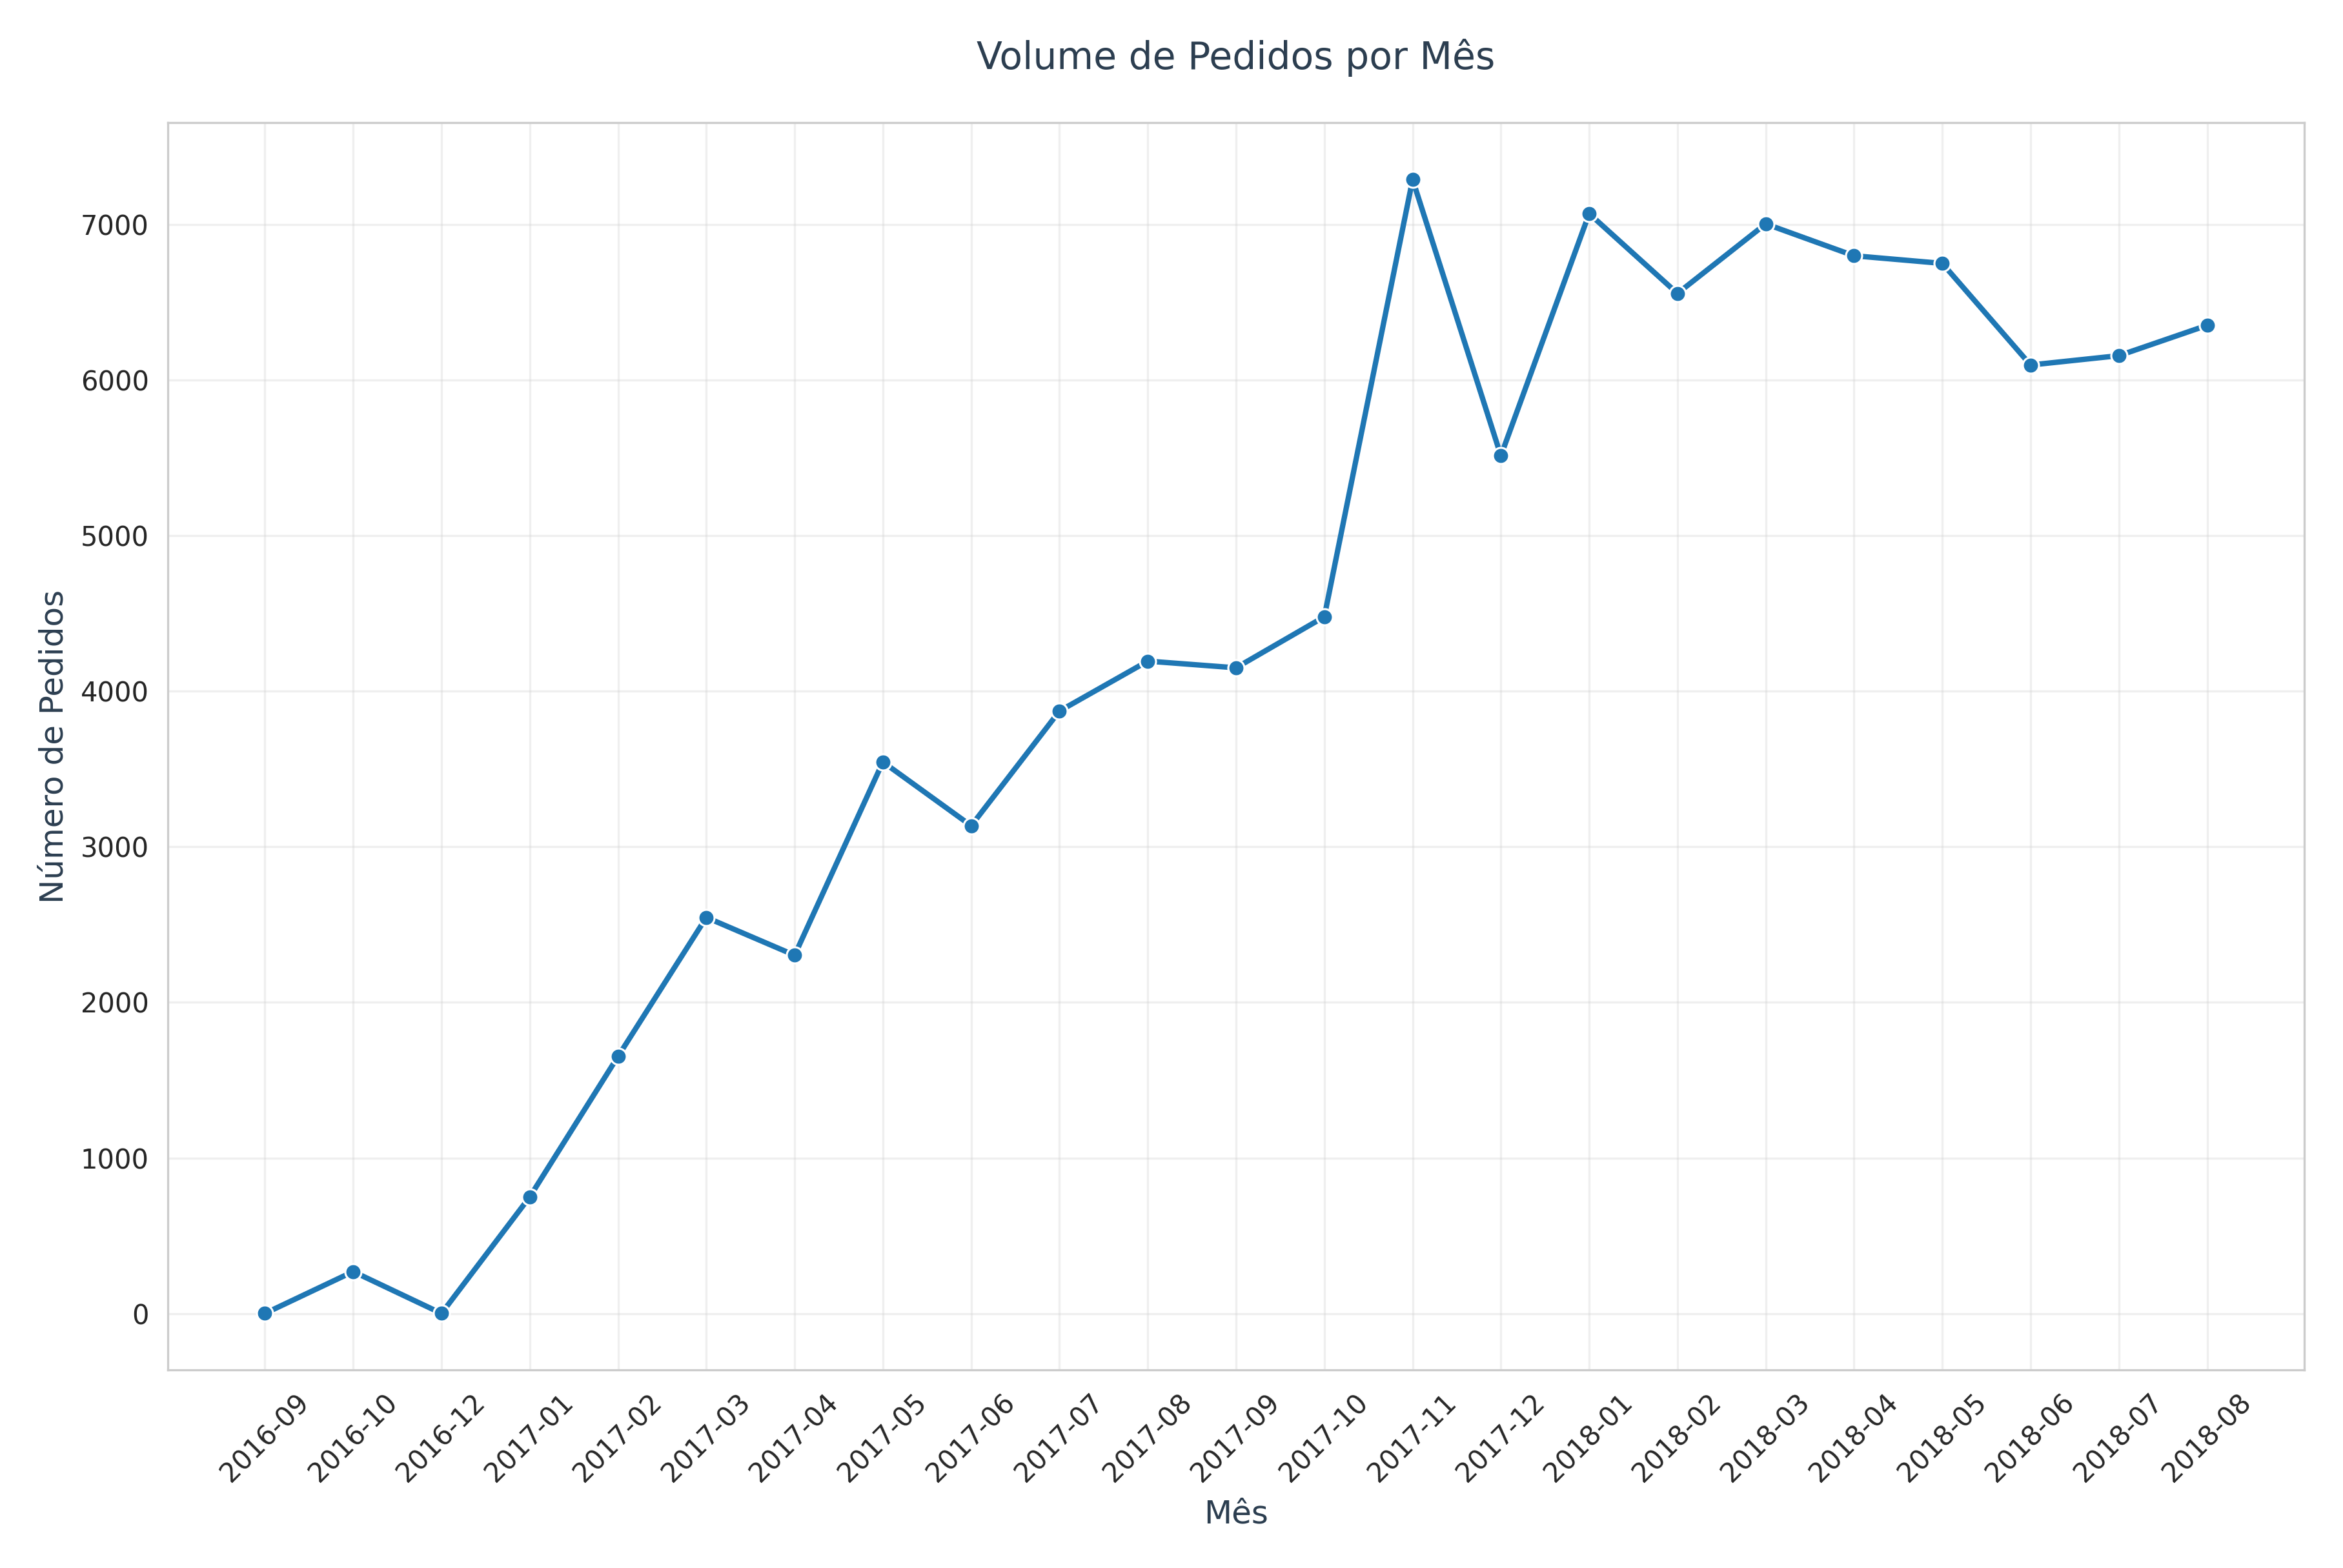

In [ ]:
show_image('./resultado/volume_pedidos_mes.png')

Fase de lançamento (set–dez/2016): volumes muito baixos, com zero em dez/16 (provável falta de dados ou inatividade naquele mês).

Crescimento acelerado (jan–nov/2017): passa de ~800 pedidos em jan/17 para um pico de ~7 300 em nov/17, indicando rápida adoção (e possivelmente efeito Black Friday).

Queda sazonal (dez/2017): recuo para ~5 500 pedidos, possivelmente reflexo de feriados e menor atividade de compras.

Estabilização em 2018: dois picos discretos em jan/18 (~7 100) e mar/18 (~7 000), seguidos por um plateau entre 6 100–6 800 até ago/18, sugerindo maturação da plataforma e consolidação da base de pedidos.

> Conclusão: o e-commerce passou por um crescimento explosivo até nov/17, depois ajustou‐se a um patamar estável de ~6–7 000 pedidos/mês a partir de jan/18.

In [ ]:
@timer_decorator
def analyze_delivery_time(df):
    """
    Analisa a distribuição do tempo de entrega.
    """
    plt.figure(figsize=(12, 8))
    sns.histplot(df['delivery_time'], bins=30, kde=True,
                color=COLORS['primary'], alpha=0.6)
    plt.title('Distribuição do Tempo de Entrega (dias)', color=COLORS['text'], pad=20)
    plt.xlabel('Dias', color=COLORS['text'])
    plt.ylabel('Frequência', color=COLORS['text'])
    plt.grid(True, alpha=0.3)
    save_file(plt.gcf(), 'distribuicao_tempo_entrega.png')

analyze_delivery_time(df)


Iniciando analyze_delivery_time...
Arquivo salvo: resultado/distribuicao_tempo_entrega.png
Tempo de execução de analyze_delivery_time: 1.31 segundos


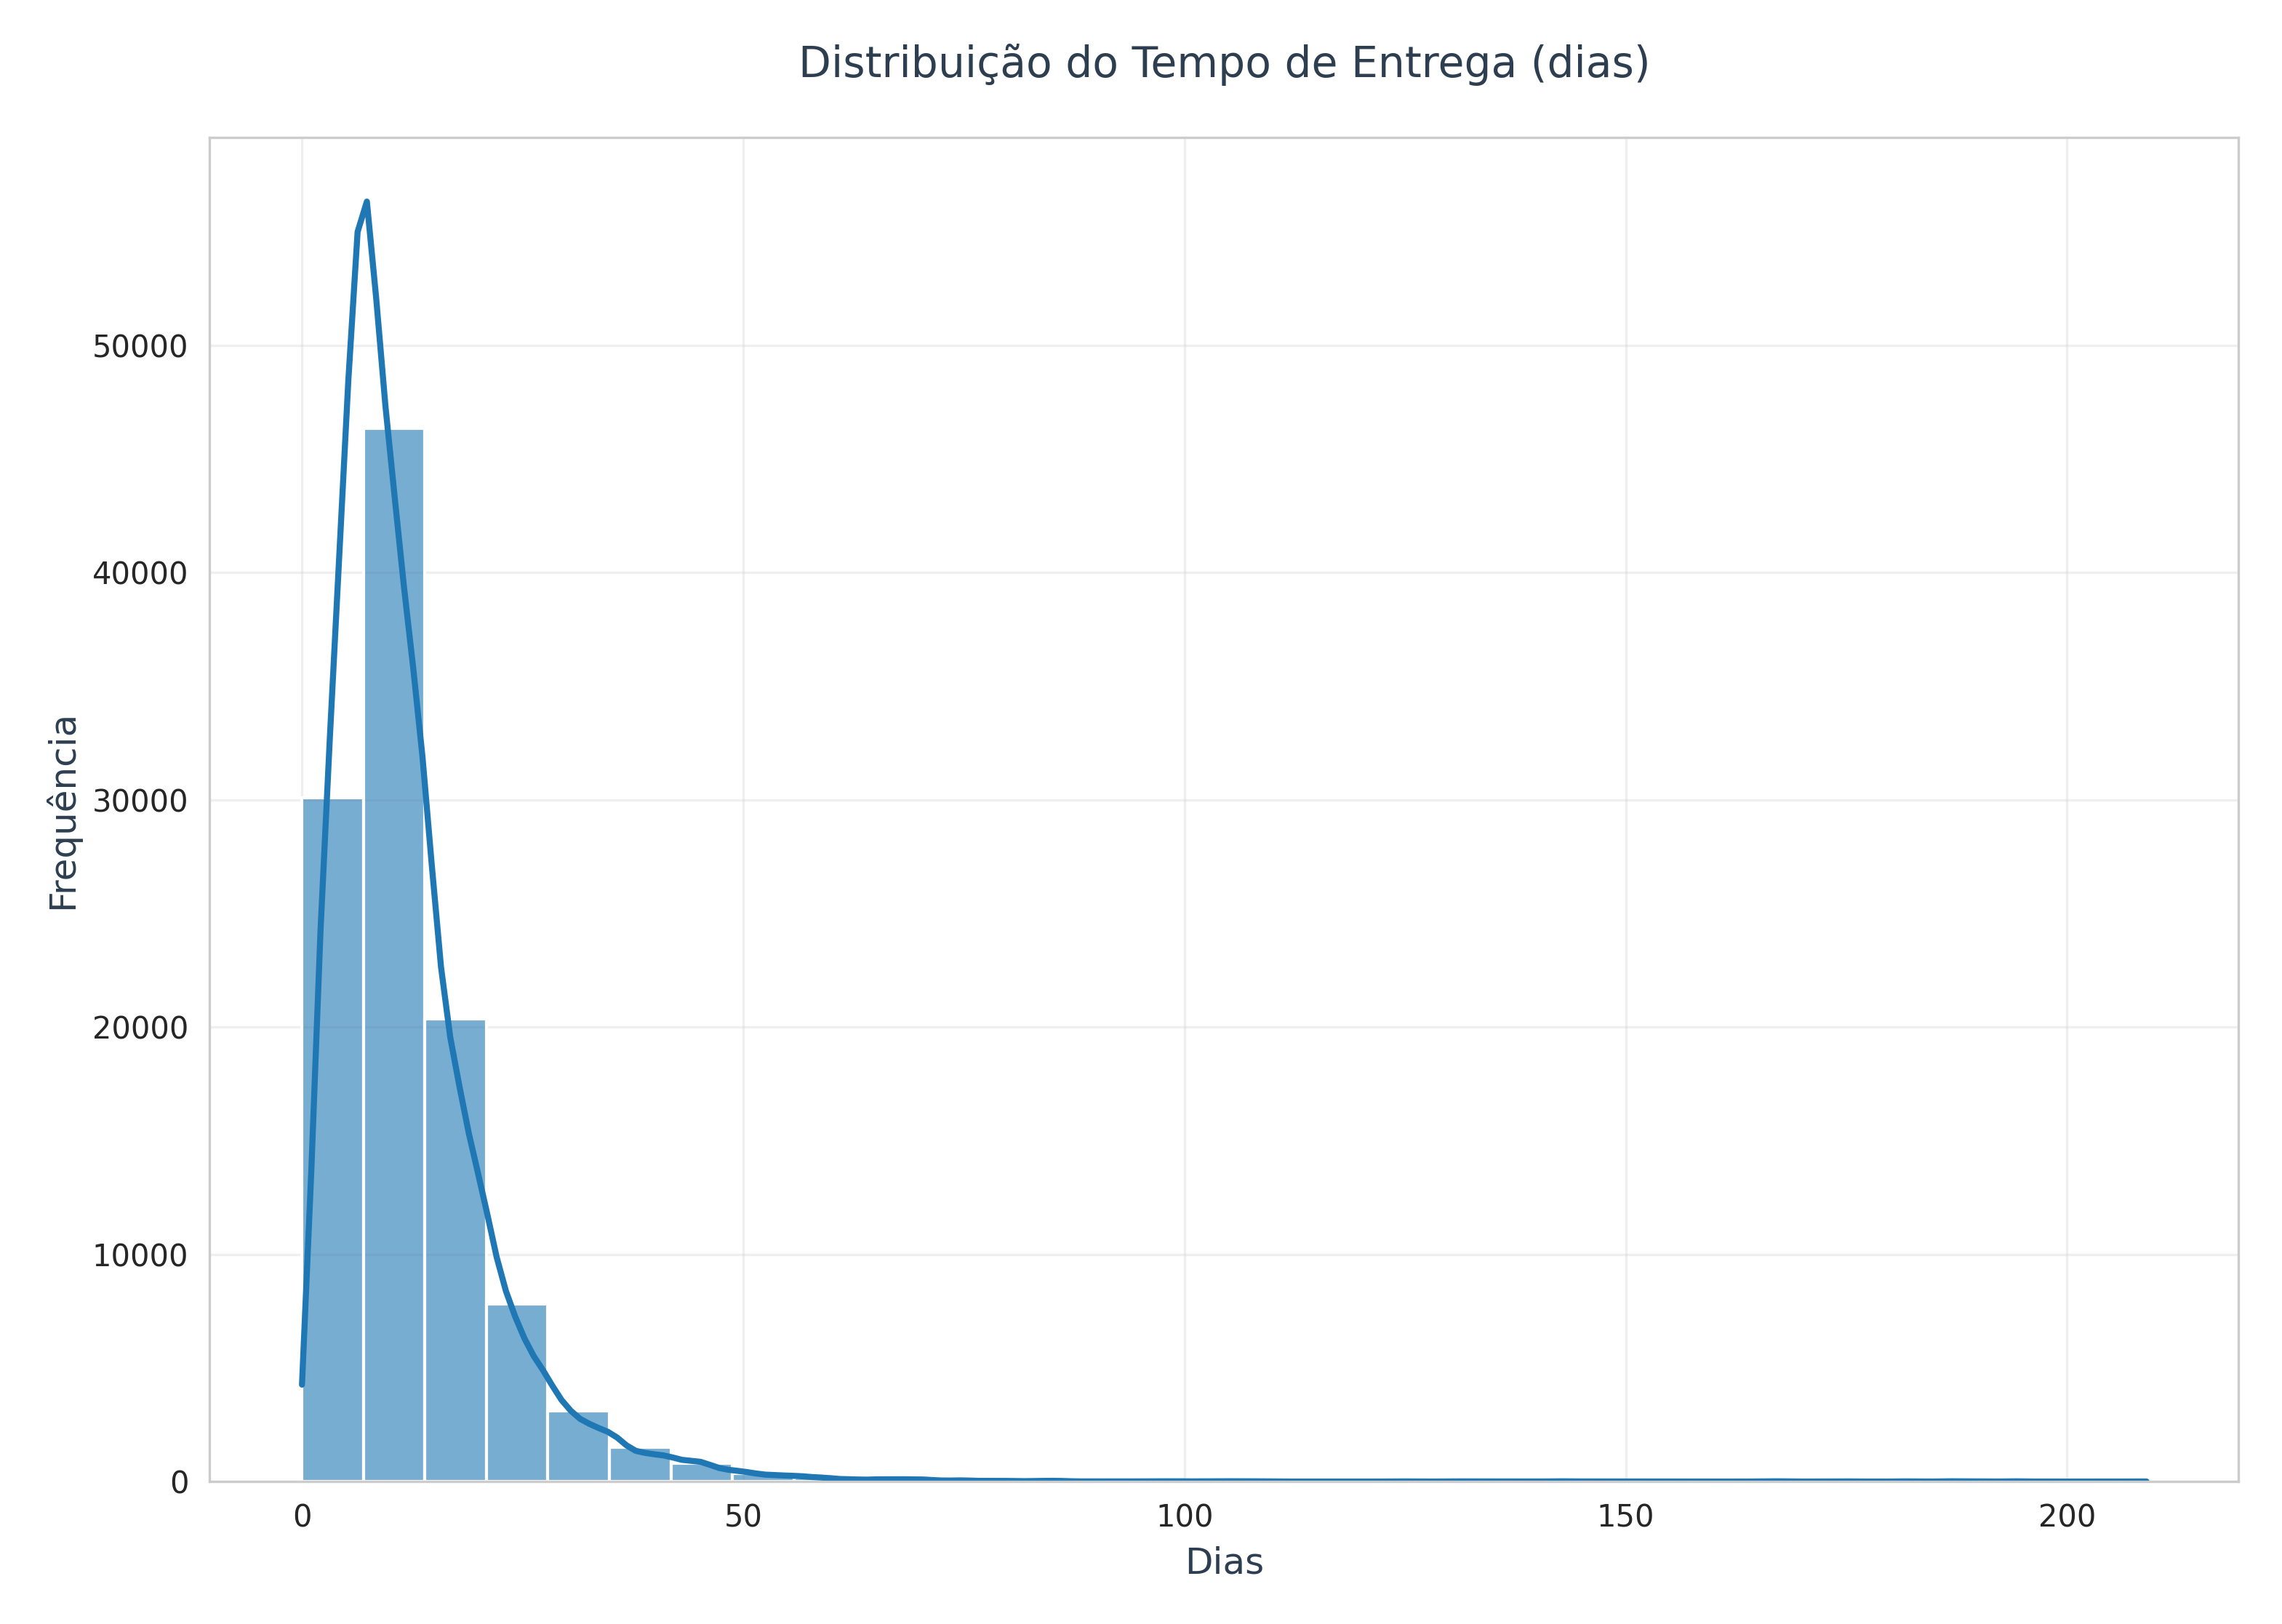

In [ ]:
show_image('./resultado/distribuicao_tempo_entrega.png')

A distribuição é fortemente assimétrica à direita: a maioria das entregas ocorre entre 5 e 15 dias, com pico em torno de 10 dias.

Há um “bulk” concentrado nos primeiros 20 dias (altas barras e densidade elevada), indicando que o prazo médio gira em torno de 10–12 dias.

O cauda longa se estende até ≈ 210 dias, mas com frequência muito baixa, sinalizando atrasos extremos e casos atípicos que devem ser investigados isoladamente.

In [ ]:
@timer_decorator
def analyze_freight_distance(df):
    """
    Analisa a relação entre valor do frete e distância de entrega.
    """
    # Agrupa por estado do cliente e vendedor
    freight_by_state = df.groupby(['customer_state', 'seller_state']).agg({
        'freight_value': 'mean',
        'price': 'mean'
    }).reset_index()

    # Calcula uma distância aproximada baseada em estados diferentes
    freight_by_state['is_same_state'] = freight_by_state['customer_state'] == freight_by_state['seller_state']

    plt.figure(figsize=(12, 8))
    sns.boxplot(data=freight_by_state, x='is_same_state', y='freight_value',
                palette=[COLORS['primary'], COLORS['secondary']])
    plt.title('Valor do Frete por Mesmo Estado', color=COLORS['text'], pad=20)
    plt.xlabel('Mesmo Estado', color=COLORS['text'])
    plt.ylabel('Valor do Frete (R$)', color=COLORS['text'])
    plt.grid(True, alpha=0.3)
    save_file(plt.gcf(), 'frete_vs_estado.png')

    # Análise adicional: frete vs valor do pedido
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=freight_by_state, x='price', y='freight_value',
                   alpha=0.6, color=COLORS['primary'])
    plt.title('Relação entre Valor do Pedido e Frete', color=COLORS['text'], pad=20)
    plt.xlabel('Valor Médio do Pedido (R$)', color=COLORS['text'])
    plt.ylabel('Valor do Frete (R$)', color=COLORS['text'])
    plt.grid(True, alpha=0.3)
    save_file(plt.gcf(), 'frete_vs_valor.png')

analyze_freight_distance(df)


Iniciando analyze_freight_distance...
Arquivo salvo: resultado/frete_vs_estado.png
Arquivo salvo: resultado/frete_vs_valor.png
Tempo de execução de analyze_freight_distance: 1.26 segundos


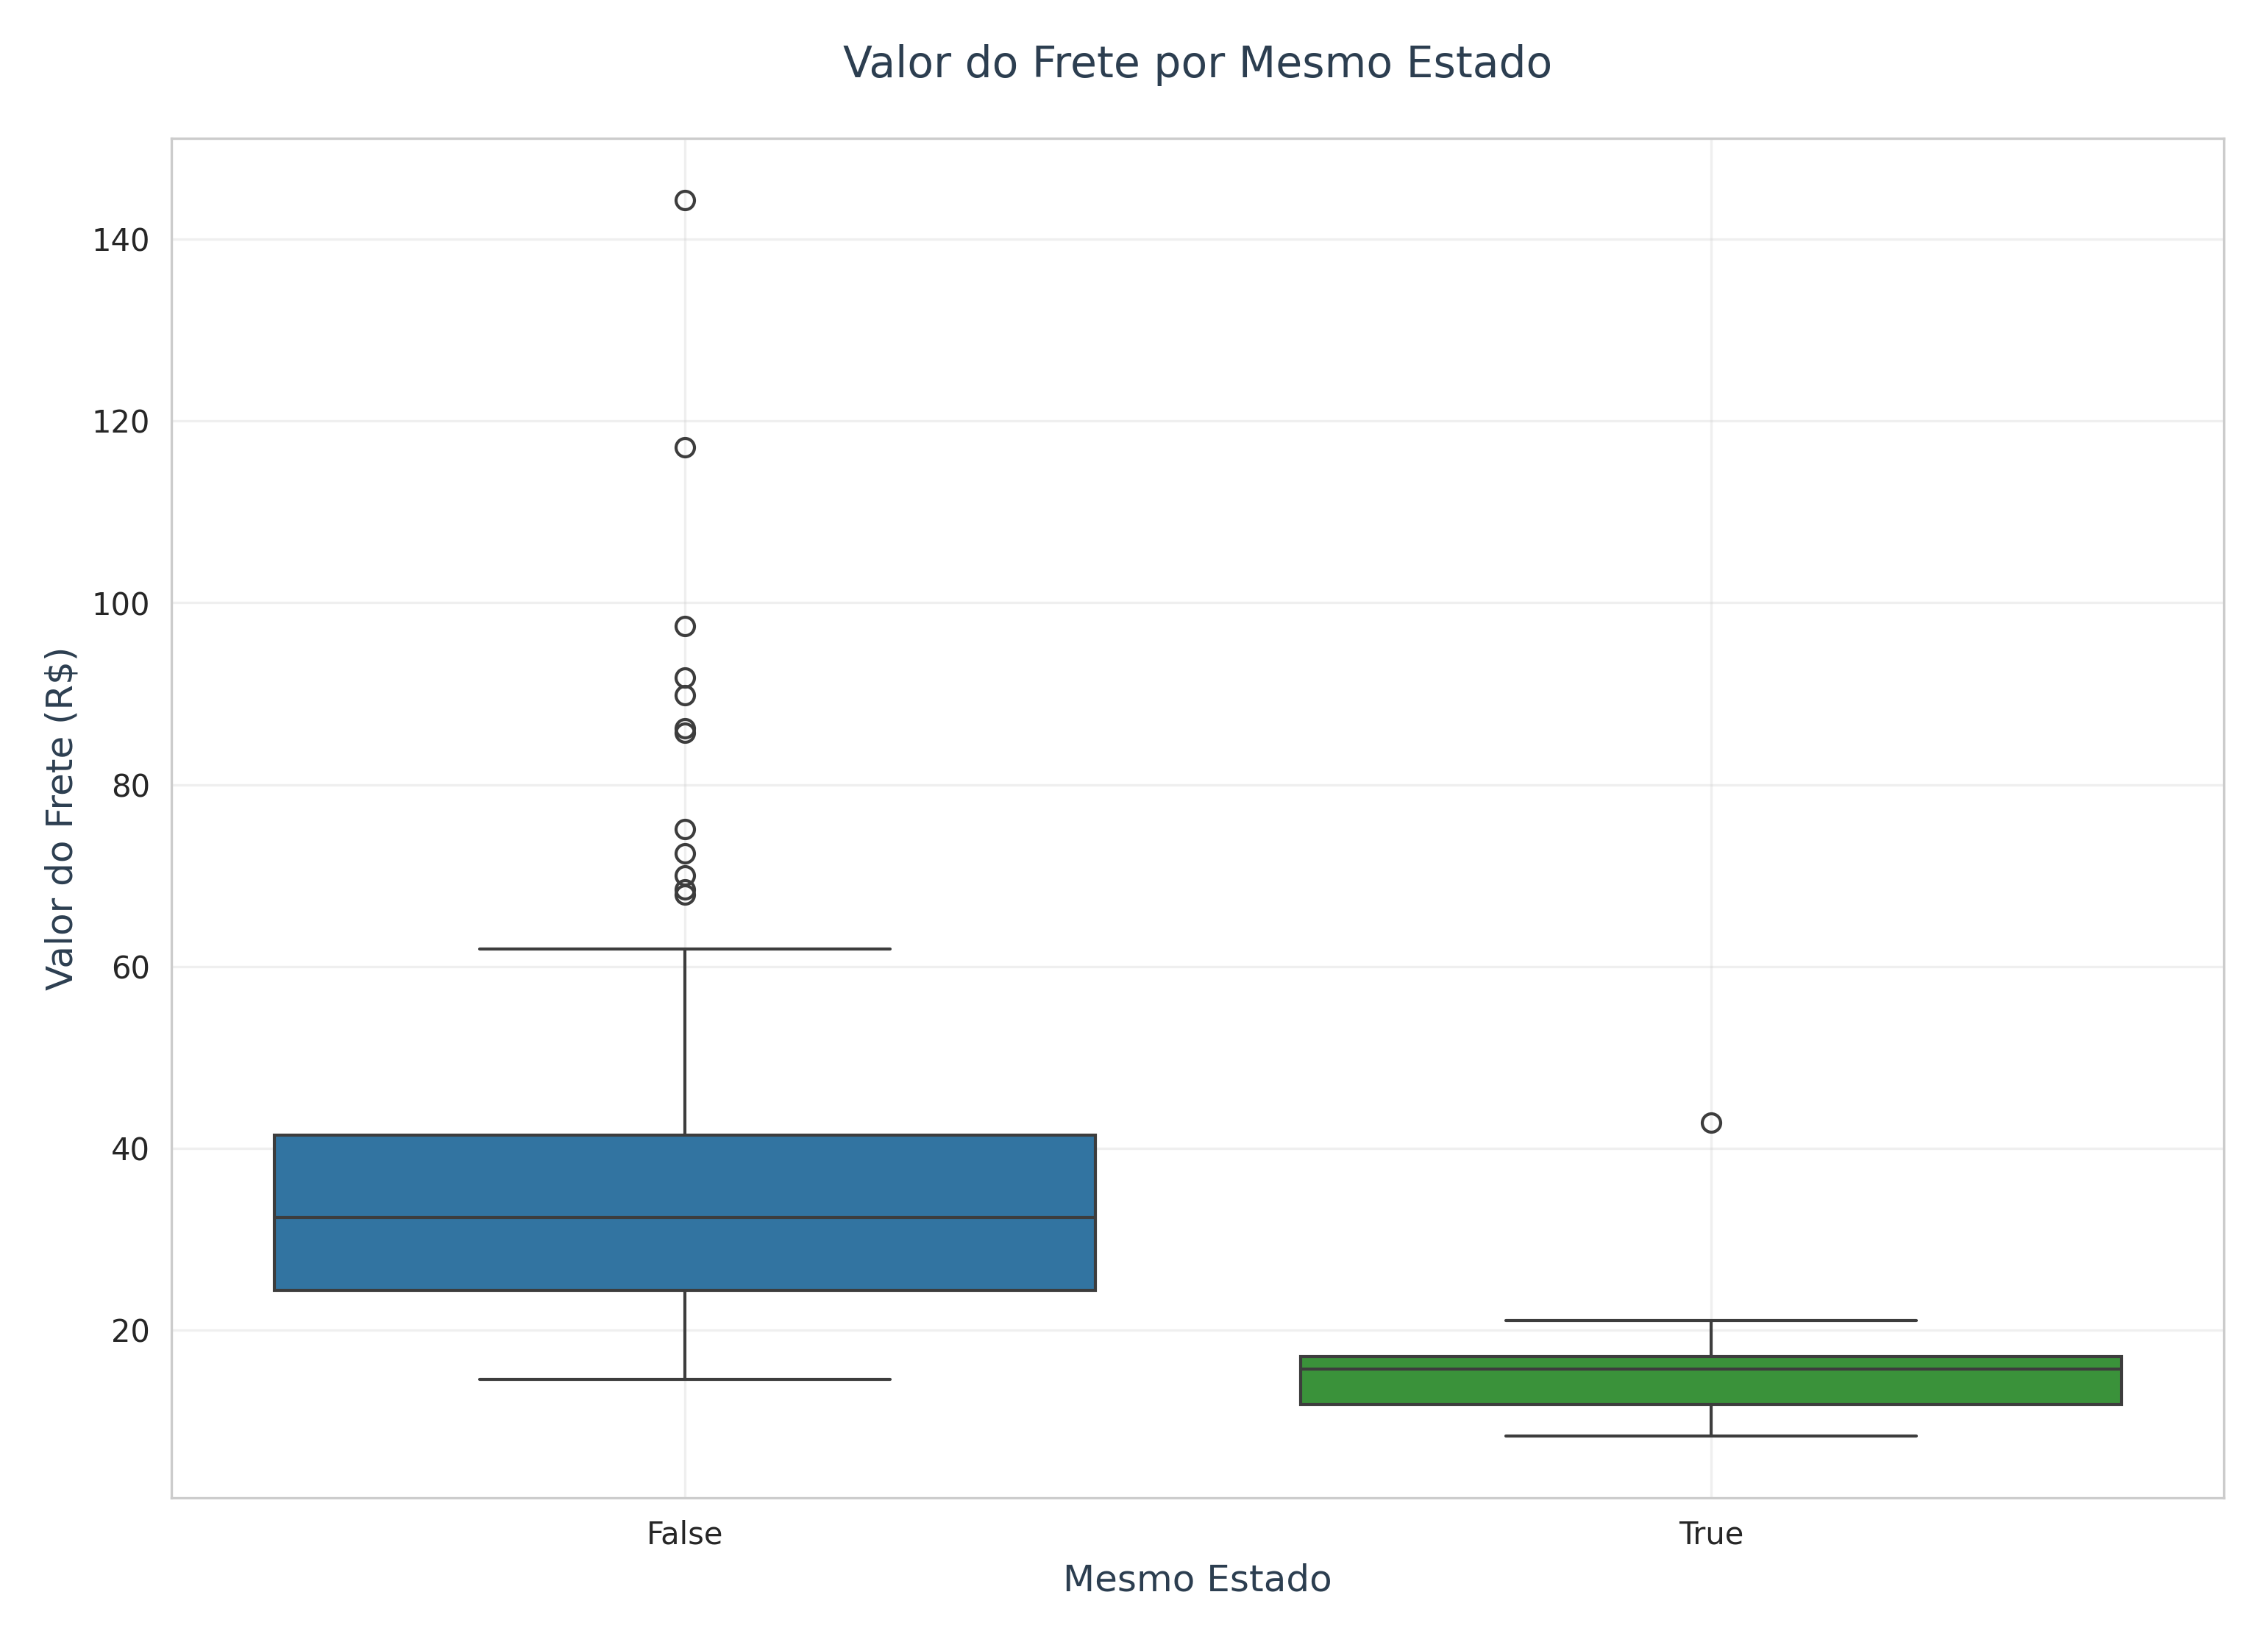

In [ ]:
show_image('./resultado/frete_vs_estado.png')

Mediana cai de ≈ \$ 32 (quando “False” = fora do mesmo estado) para ≈ \$ 15 (quando “True” = mesmo estado), ou seja, transportar para endereços internos custa em média menos da metade.

O IQR (caixa) para “False” estende-se de ≈ 24 a 41, enquanto para “True” vai de ≈ 13 a 17, mostrando menor variabilidade em fretes intrastaduais.

Outliers em “False” alcançam até 145, indicativos de cargas ou distâncias excepcionais; em “True” o máximo observado é ≈ 43.

> Insight: o frete interestadual representa custos significativamente maiores e mais voláteis; estratégias de consolidação ou parcerias locais podem reduzir essas despesas.

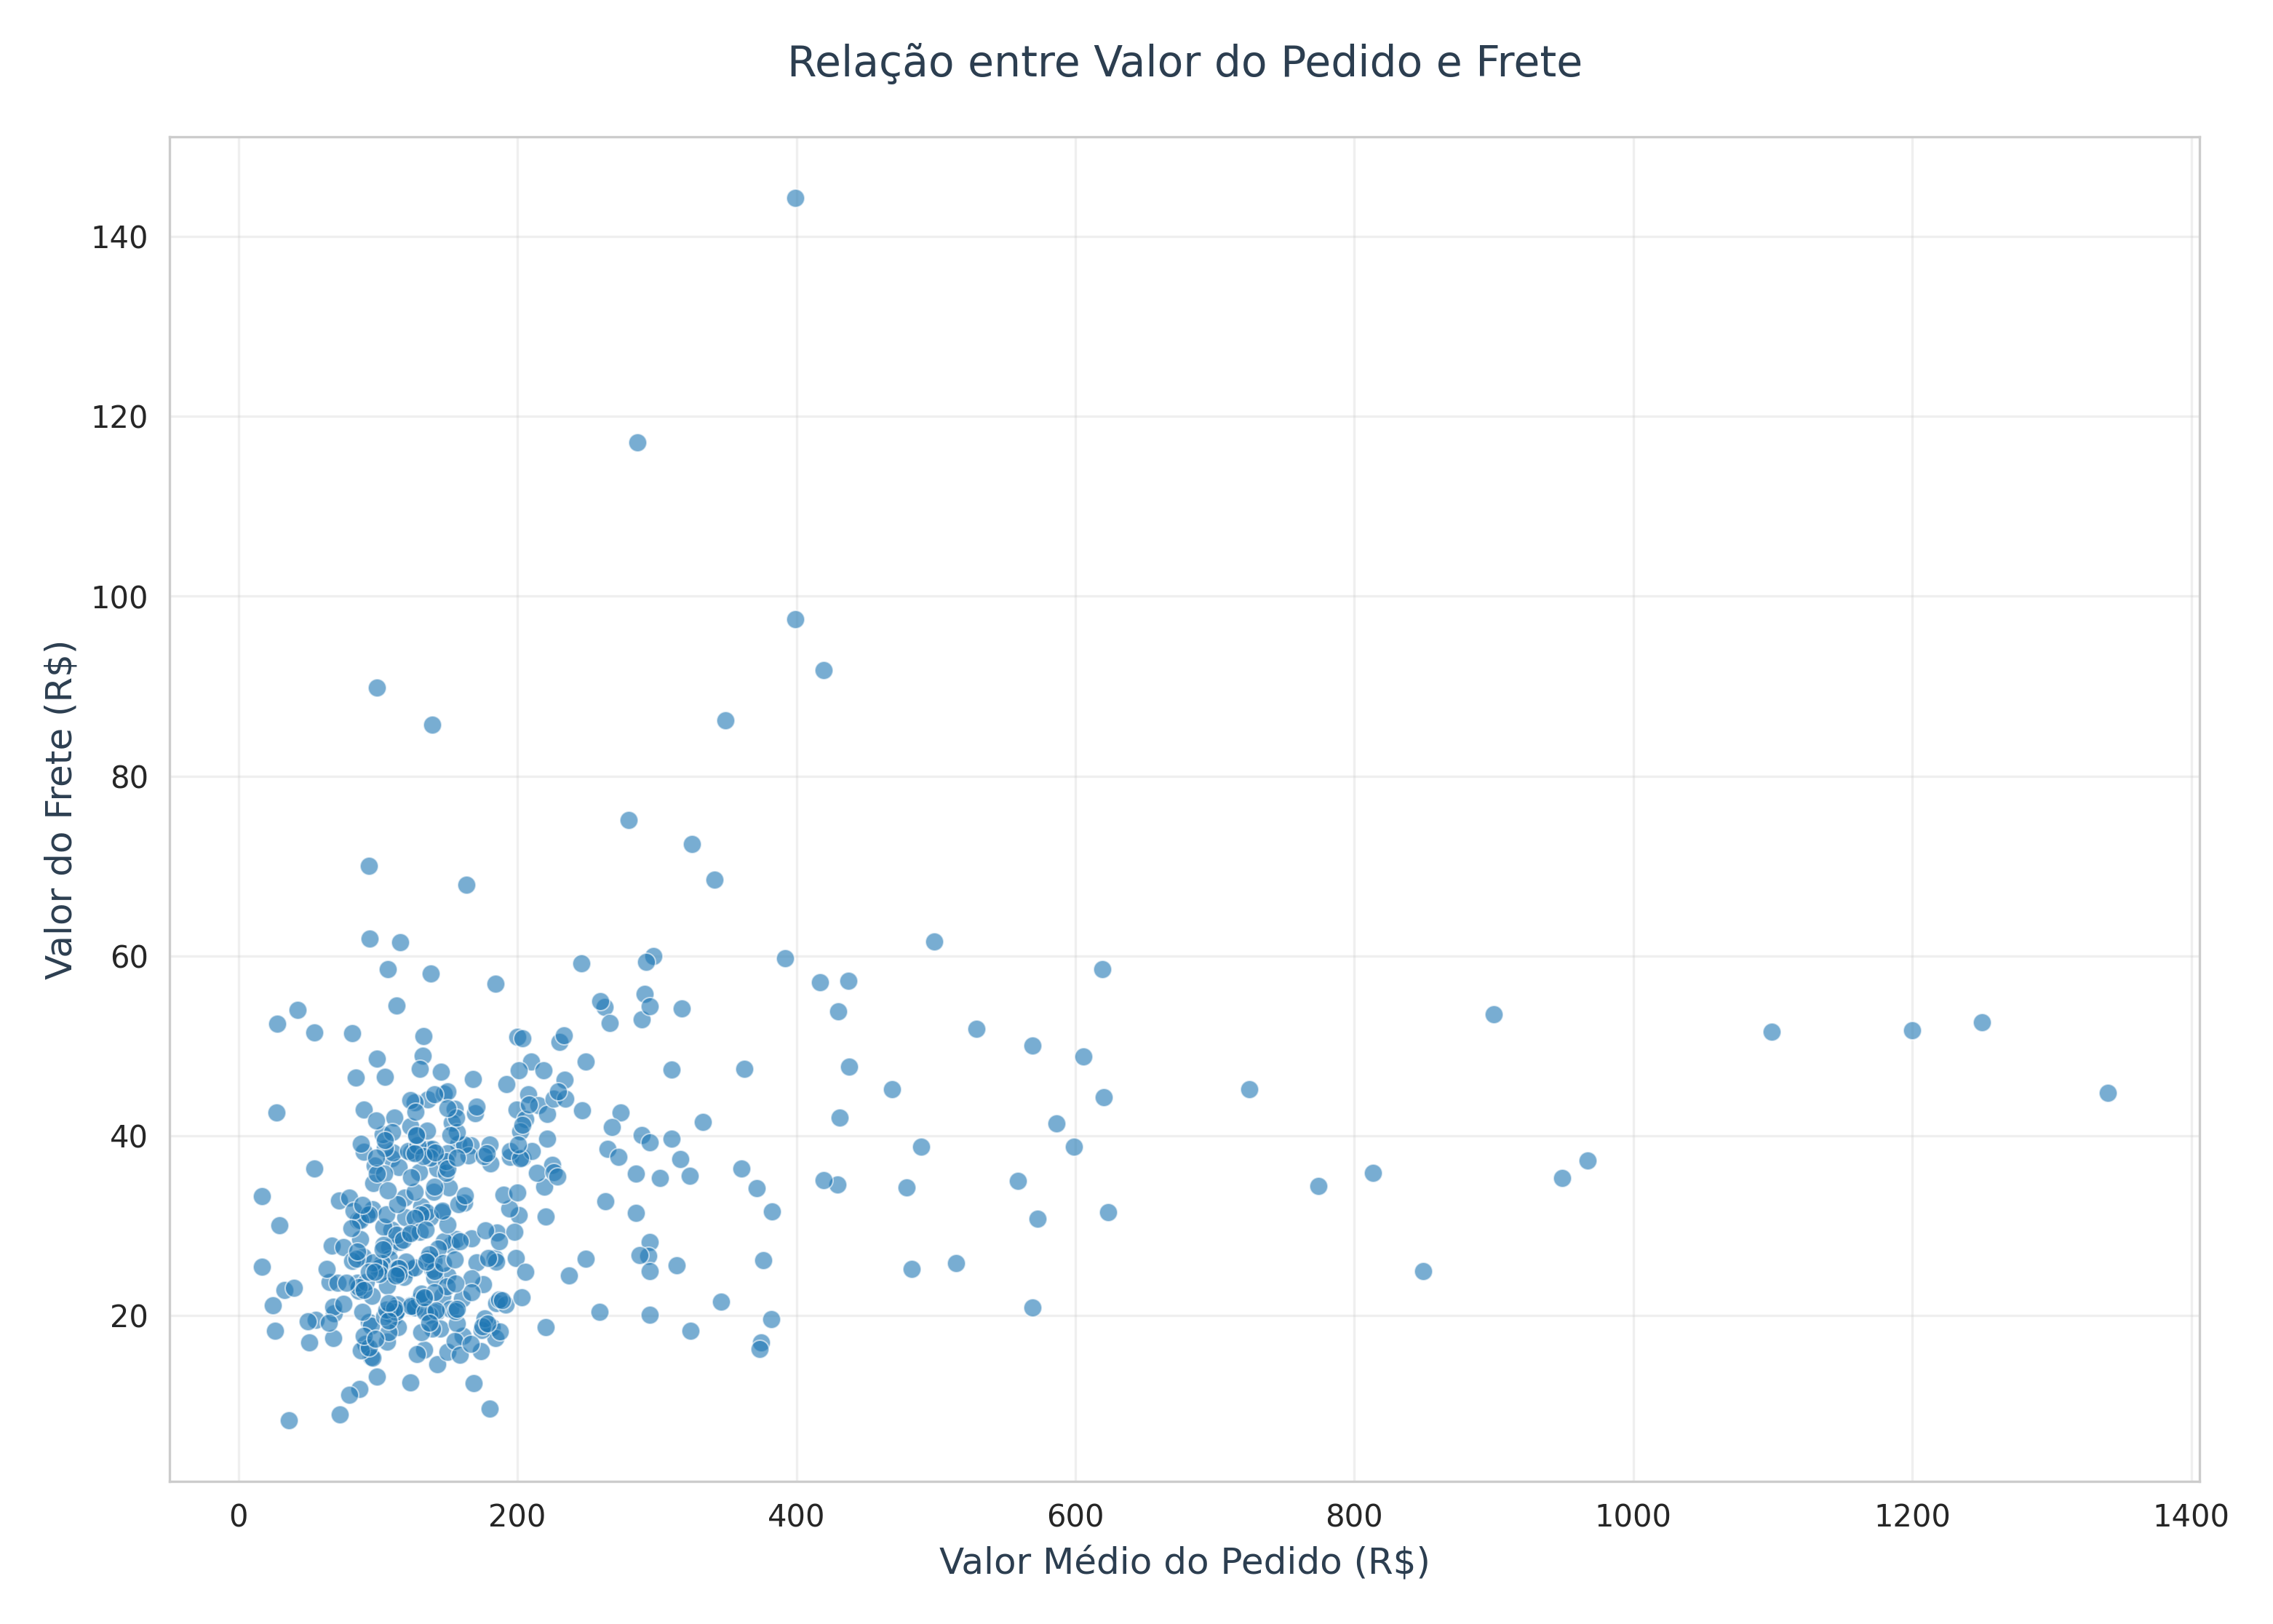

In [ ]:
show_image('./resultado/frete_vs_valor.png')

> O modelo de frete não escala linearmente com o ticket. Uma revisão de faixas de frete ou oferta de frete grátis progressivo (“free shipping” acima de X) pode otimizar a equação custo-benefício tanto para a operação logística quanto para a experiência do cliente.

In [ ]:
@timer_decorator
def analyze_top_categories(df):
    """
    Analisa as categorias de produtos mais vendidas em faturamento.
    """
    cat_sales = df.groupby('product_category_name')['price'].sum().sort_values(ascending=False).reset_index()

    plt.figure(figsize=(12, 8))
    sns.barplot(data=cat_sales.head(10), x='price', y='product_category_name',
                palette='viridis')
    plt.title('Top 10 Categorias por Faturamento', color=COLORS['text'], pad=20)
    plt.xlabel('Faturamento (R$)', color=COLORS['text'])
    plt.ylabel('Categoria', color=COLORS['text'])
    plt.grid(True, alpha=0.3)
    save_file(plt.gcf(), 'top10_categorias_faturamento.png')

analyze_top_categories(df)


Iniciando analyze_top_categories...
Arquivo salvo: resultado/top10_categorias_faturamento.png
Tempo de execução de analyze_top_categories: 0.71 segundos


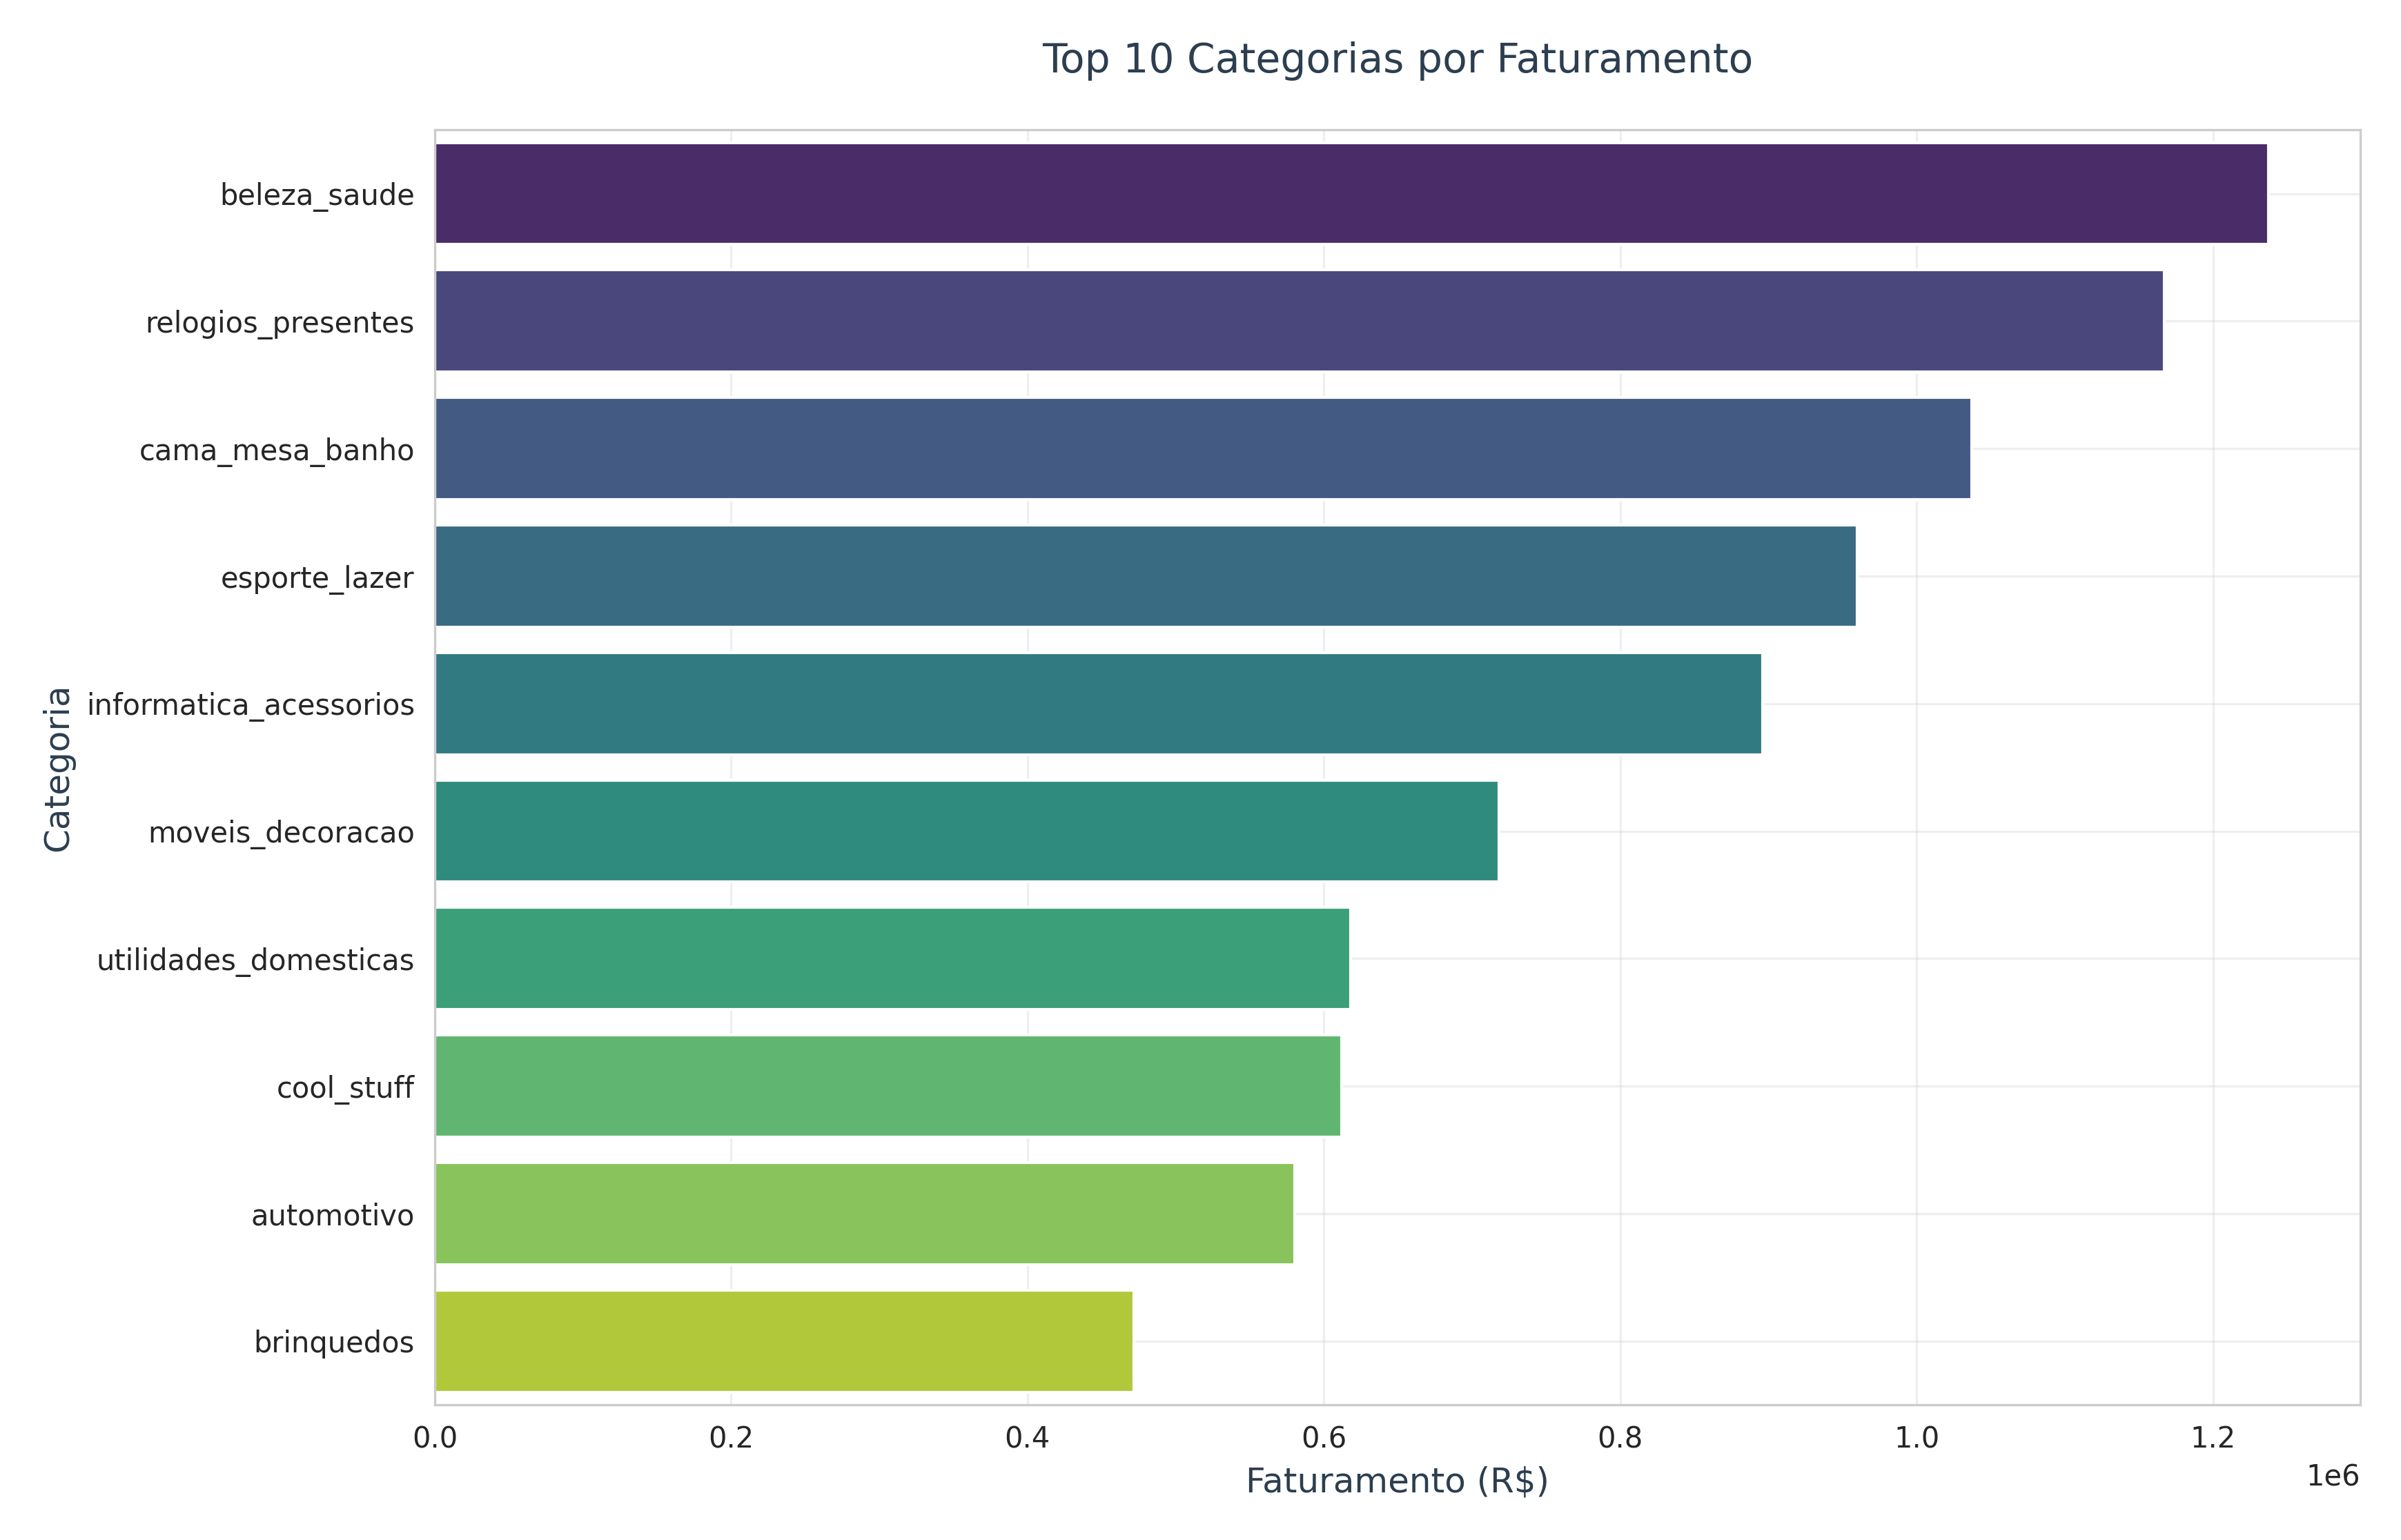

In [ ]:
show_image('./resultado/top10_categorias_faturamento.png')

> Concentre campanhas em “beleza_saude” e “relogios_presentes” para maximizar receita e desenvolva ações de marketing para crescer “automotivo” e “brinquedos”, que têm espaço para expansão

In [ ]:
@timer_decorator
def analyze_state_orders(df):
    """
    Analisa os estados com maior valor médio de pedido.
    """
    order_values = df.groupby(['order_id', 'customer_state'])['price'].sum().reset_index()
    state_avg = order_values.groupby('customer_state')['price'].mean().sort_values(ascending=False).reset_index()

    if not state_avg.empty:
        plt.figure(figsize=(12, 8))
        sns.barplot(data=state_avg.head(10), x='price', y='customer_state',
                    palette='viridis')
        plt.title('Top 10 Estados por Valor Médio de Pedido', color=COLORS['text'], pad=20)
        plt.xlabel('Valor Médio (R$)', color=COLORS['text'])
        plt.ylabel('Estado', color=COLORS['text'])
        plt.grid(True, alpha=0.3)
        save_file(plt.gcf(), 'top10_estados_valor_medio.png')

analyze_state_orders(df)


Iniciando analyze_state_orders...
Arquivo salvo: resultado/top10_estados_valor_medio.png
Tempo de execução de analyze_state_orders: 0.77 segundos


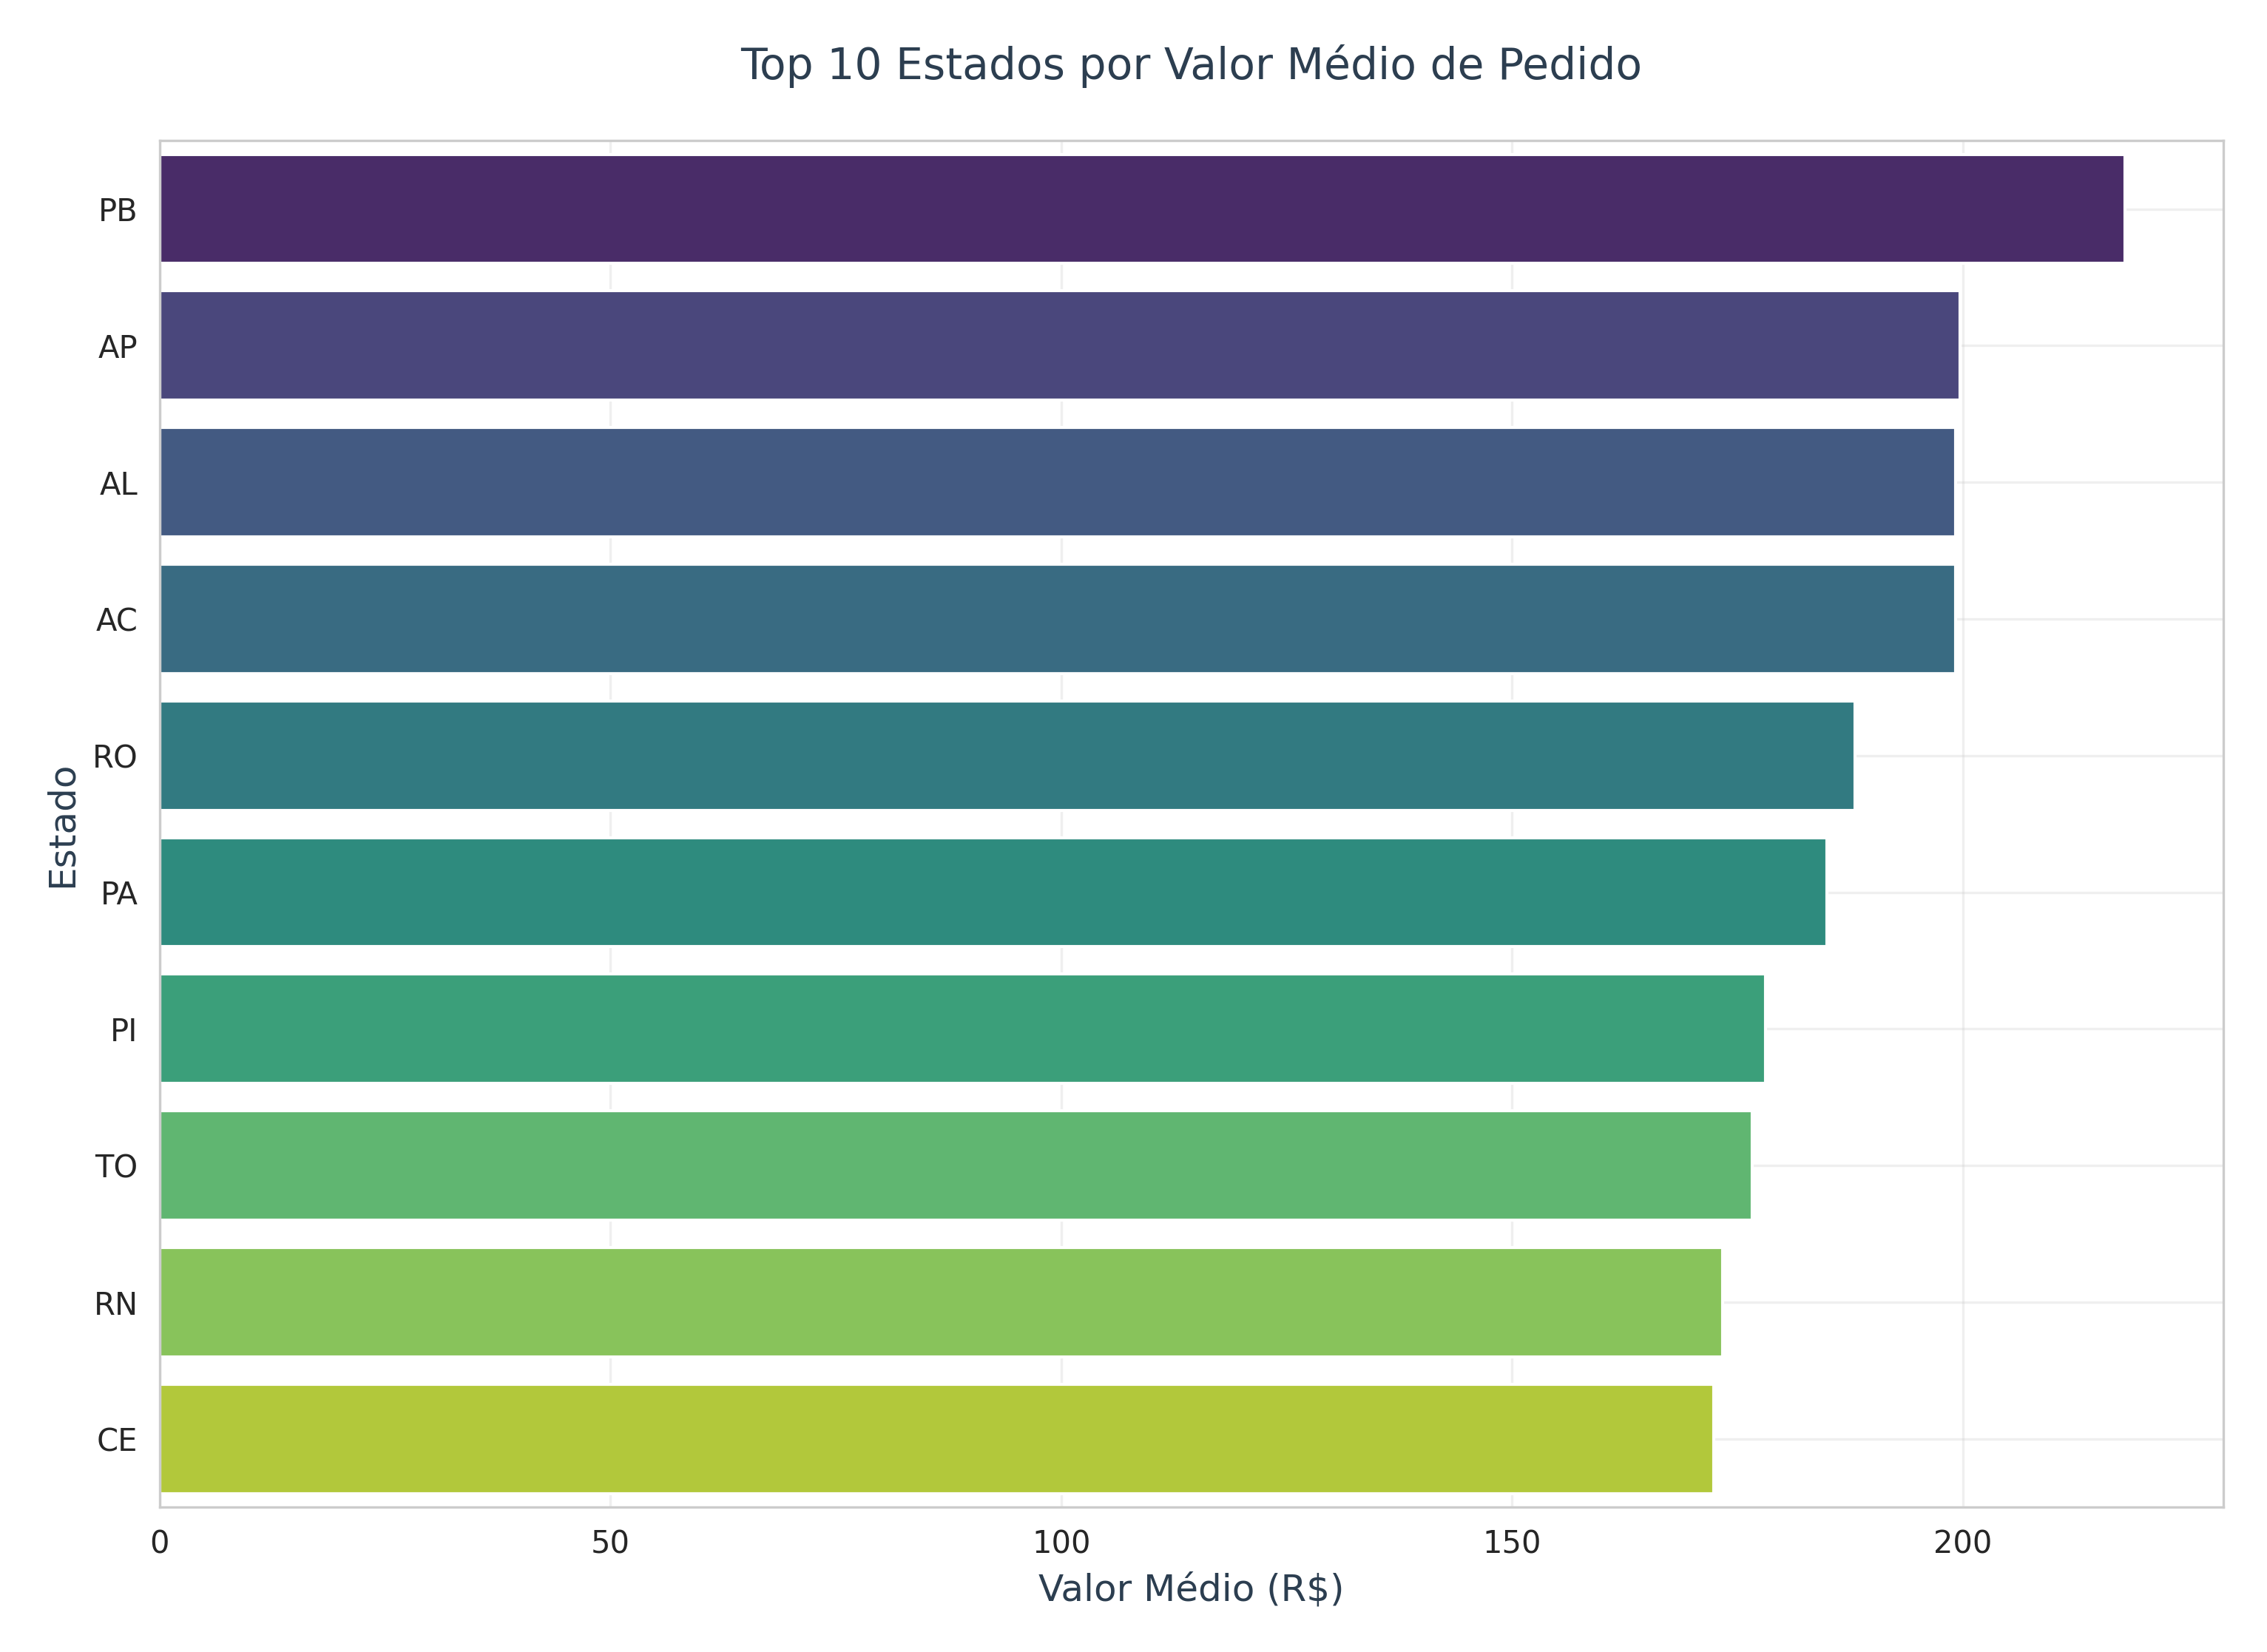

In [ ]:
show_image('./resultado/top10_estados_valor_medio.png')

Liderança do Nordeste/Norte: Paraíba (PB) está no topo com R$ 215, seguida por Amapá (AP), Alagoas (AL) e Acre (AC), todas em torno de R$ 200.

Diferença moderada: o 10º colocado (Ceará, CE) registra R$ 175, portanto há um desnível de cerca de R$ 40 entre o maior e o menor valor médio do top 10.

Possíveis causadores: baixa densidade de pedidos nesses estados pode inflacionar o ticket médio (fretes maiores, menos promoção), enquanto em regiões mais populosas o volume dilui o valor médio.

> Vale investigar se custos logísticos ou perfil de produto nessas unidades federativas estão elevando artificialmente o ticket médio, e se há espaço para campanhas que aumentem o volume sem sacrificar margens.

---
### 💡 3. Soluções para Problemas de Negócio

In [ ]:
@timer_decorator
def analyze_customer_retention(df):
    """
    Analisa a taxa de retenção de clientes.

    Args:
        df (pd.DataFrame): DataFrame com os dados
    """
    # Agrupa por customer_unique_id para identificar clientes únicos
    customer_orders = df.groupby('customer_unique_id').agg({
        'order_id': 'nunique',
        'order_purchase_timestamp': ['min', 'max']
    }).reset_index()

    customer_orders.columns = ['customer_unique_id', 'order_count', 'first_order', 'last_order']

    # Calcula métricas
    total_customers = len(customer_orders)
    recurring_customers = len(customer_orders[customer_orders['order_count'] > 1])
    retention_rate = recurring_customers / total_customers

    print(f"\nAnálise de Retenção de Clientes:")
    print(f"Total de clientes únicos: {total_customers}")
    print(f"Clientes recorrentes: {recurring_customers}")
    print(f"Taxa de retenção: {retention_rate:.2%}")

    # Distribuição de pedidos por cliente
    plt.figure(figsize=(12, 8))
    ax = sns.histplot(data=customer_orders, x='order_count', bins=20,
                     color=COLORS['primary'], kde=True, alpha=0.7)
    plt.title('Distribuição de Pedidos por Cliente', color=COLORS['text'], pad=20)
    plt.xlabel('Número de Pedidos', color=COLORS['text'])
    plt.ylabel('Quantidade de Clientes', color=COLORS['text'])
    plt.grid(True, alpha=0.3)
    # Adicionar textos informativos no gráfico
    plt.text(0.95, 0.95, f'Total de Clientes: {total_customers}\nClientes Recorrentes: {recurring_customers}\nTaxa de Retenção: {retention_rate:.2%}',
             transform=ax.transAxes, fontsize=12, verticalalignment='top',
             horizontalalignment='right', bbox=dict(boxstyle='round', facecolor=COLORS['background'], alpha=0.8))
    save_file(plt.gcf(), 'distribuicao_pedidos_cliente.png')

    # Análise adicional: tempo entre primeiro e último pedido
    customer_orders['days_between_orders'] = (customer_orders['last_order'] - customer_orders['first_order']).dt.days

    plt.figure(figsize=(12, 8))
    sns.histplot(data=customer_orders[customer_orders['order_count'] > 1],
                x='days_between_orders', bins=30,
                color=COLORS['primary'], kde=True, alpha=0.7)
    plt.title('Distribuição do Tempo entre Primeiro e Último Pedido', color=COLORS['text'], pad=20)
    plt.xlabel('Dias entre Pedidos', color=COLORS['text'])
    plt.ylabel('Quantidade de Clientes', color=COLORS['text'])
    plt.grid(True, alpha=0.3)
    save_file(plt.gcf(), 'tempo_entre_pedidos.png')

analyze_customer_retention(df)


Iniciando analyze_customer_retention...

Análise de Retenção de Clientes:
Total de clientes únicos: 93356
Clientes recorrentes: 2801
Taxa de retenção: 3.00%
Arquivo salvo: resultado/distribuicao_pedidos_cliente.png
Arquivo salvo: resultado/tempo_entre_pedidos.png
Tempo de execução de analyze_customer_retention: 2.32 segundos


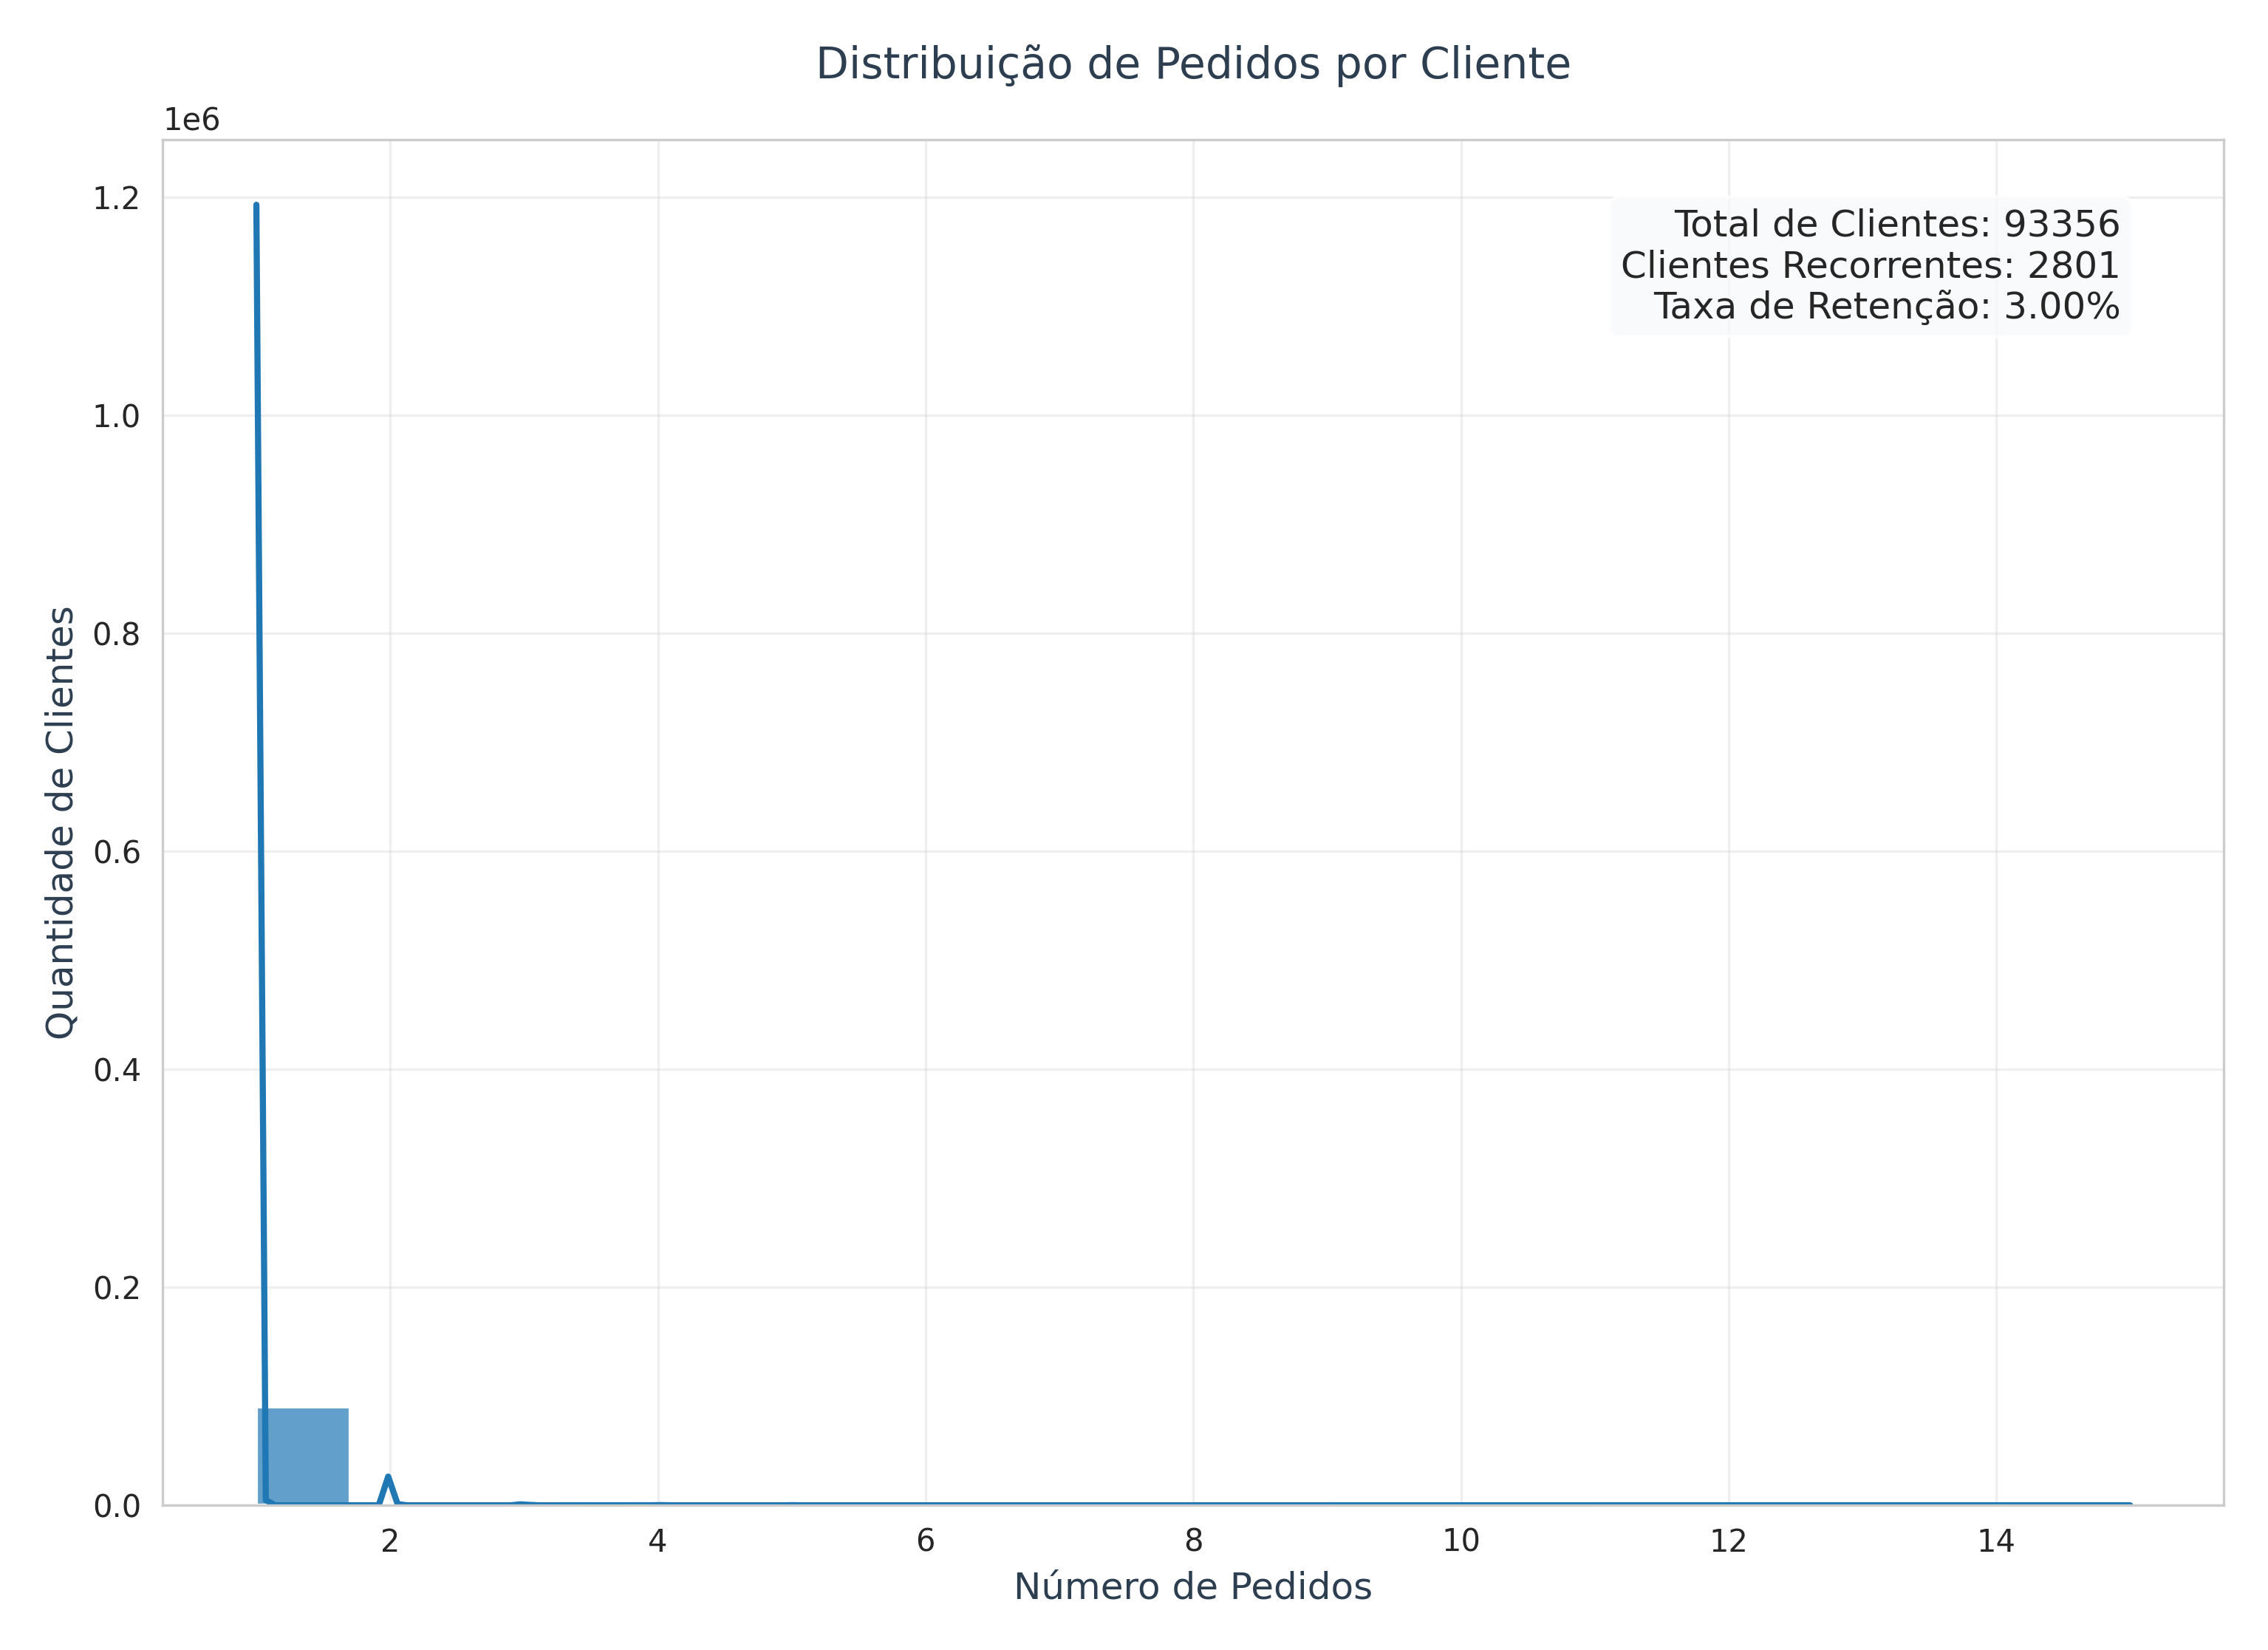

In [ ]:
show_image('./resultado/distribuicao_pedidos_cliente.png')

- **Números-chave**:  
  - **Total de clientes**: 93 356  
  - **Clientes recorrentes** (>1 pedido): 2 801 (≈ 3,00 % de retenção)  
- **Insight**: apenas 3 % da base retorna para novo pedido — há grande oportunidade de elevar a recorrência por meio de programas de fidelização e remarketing.


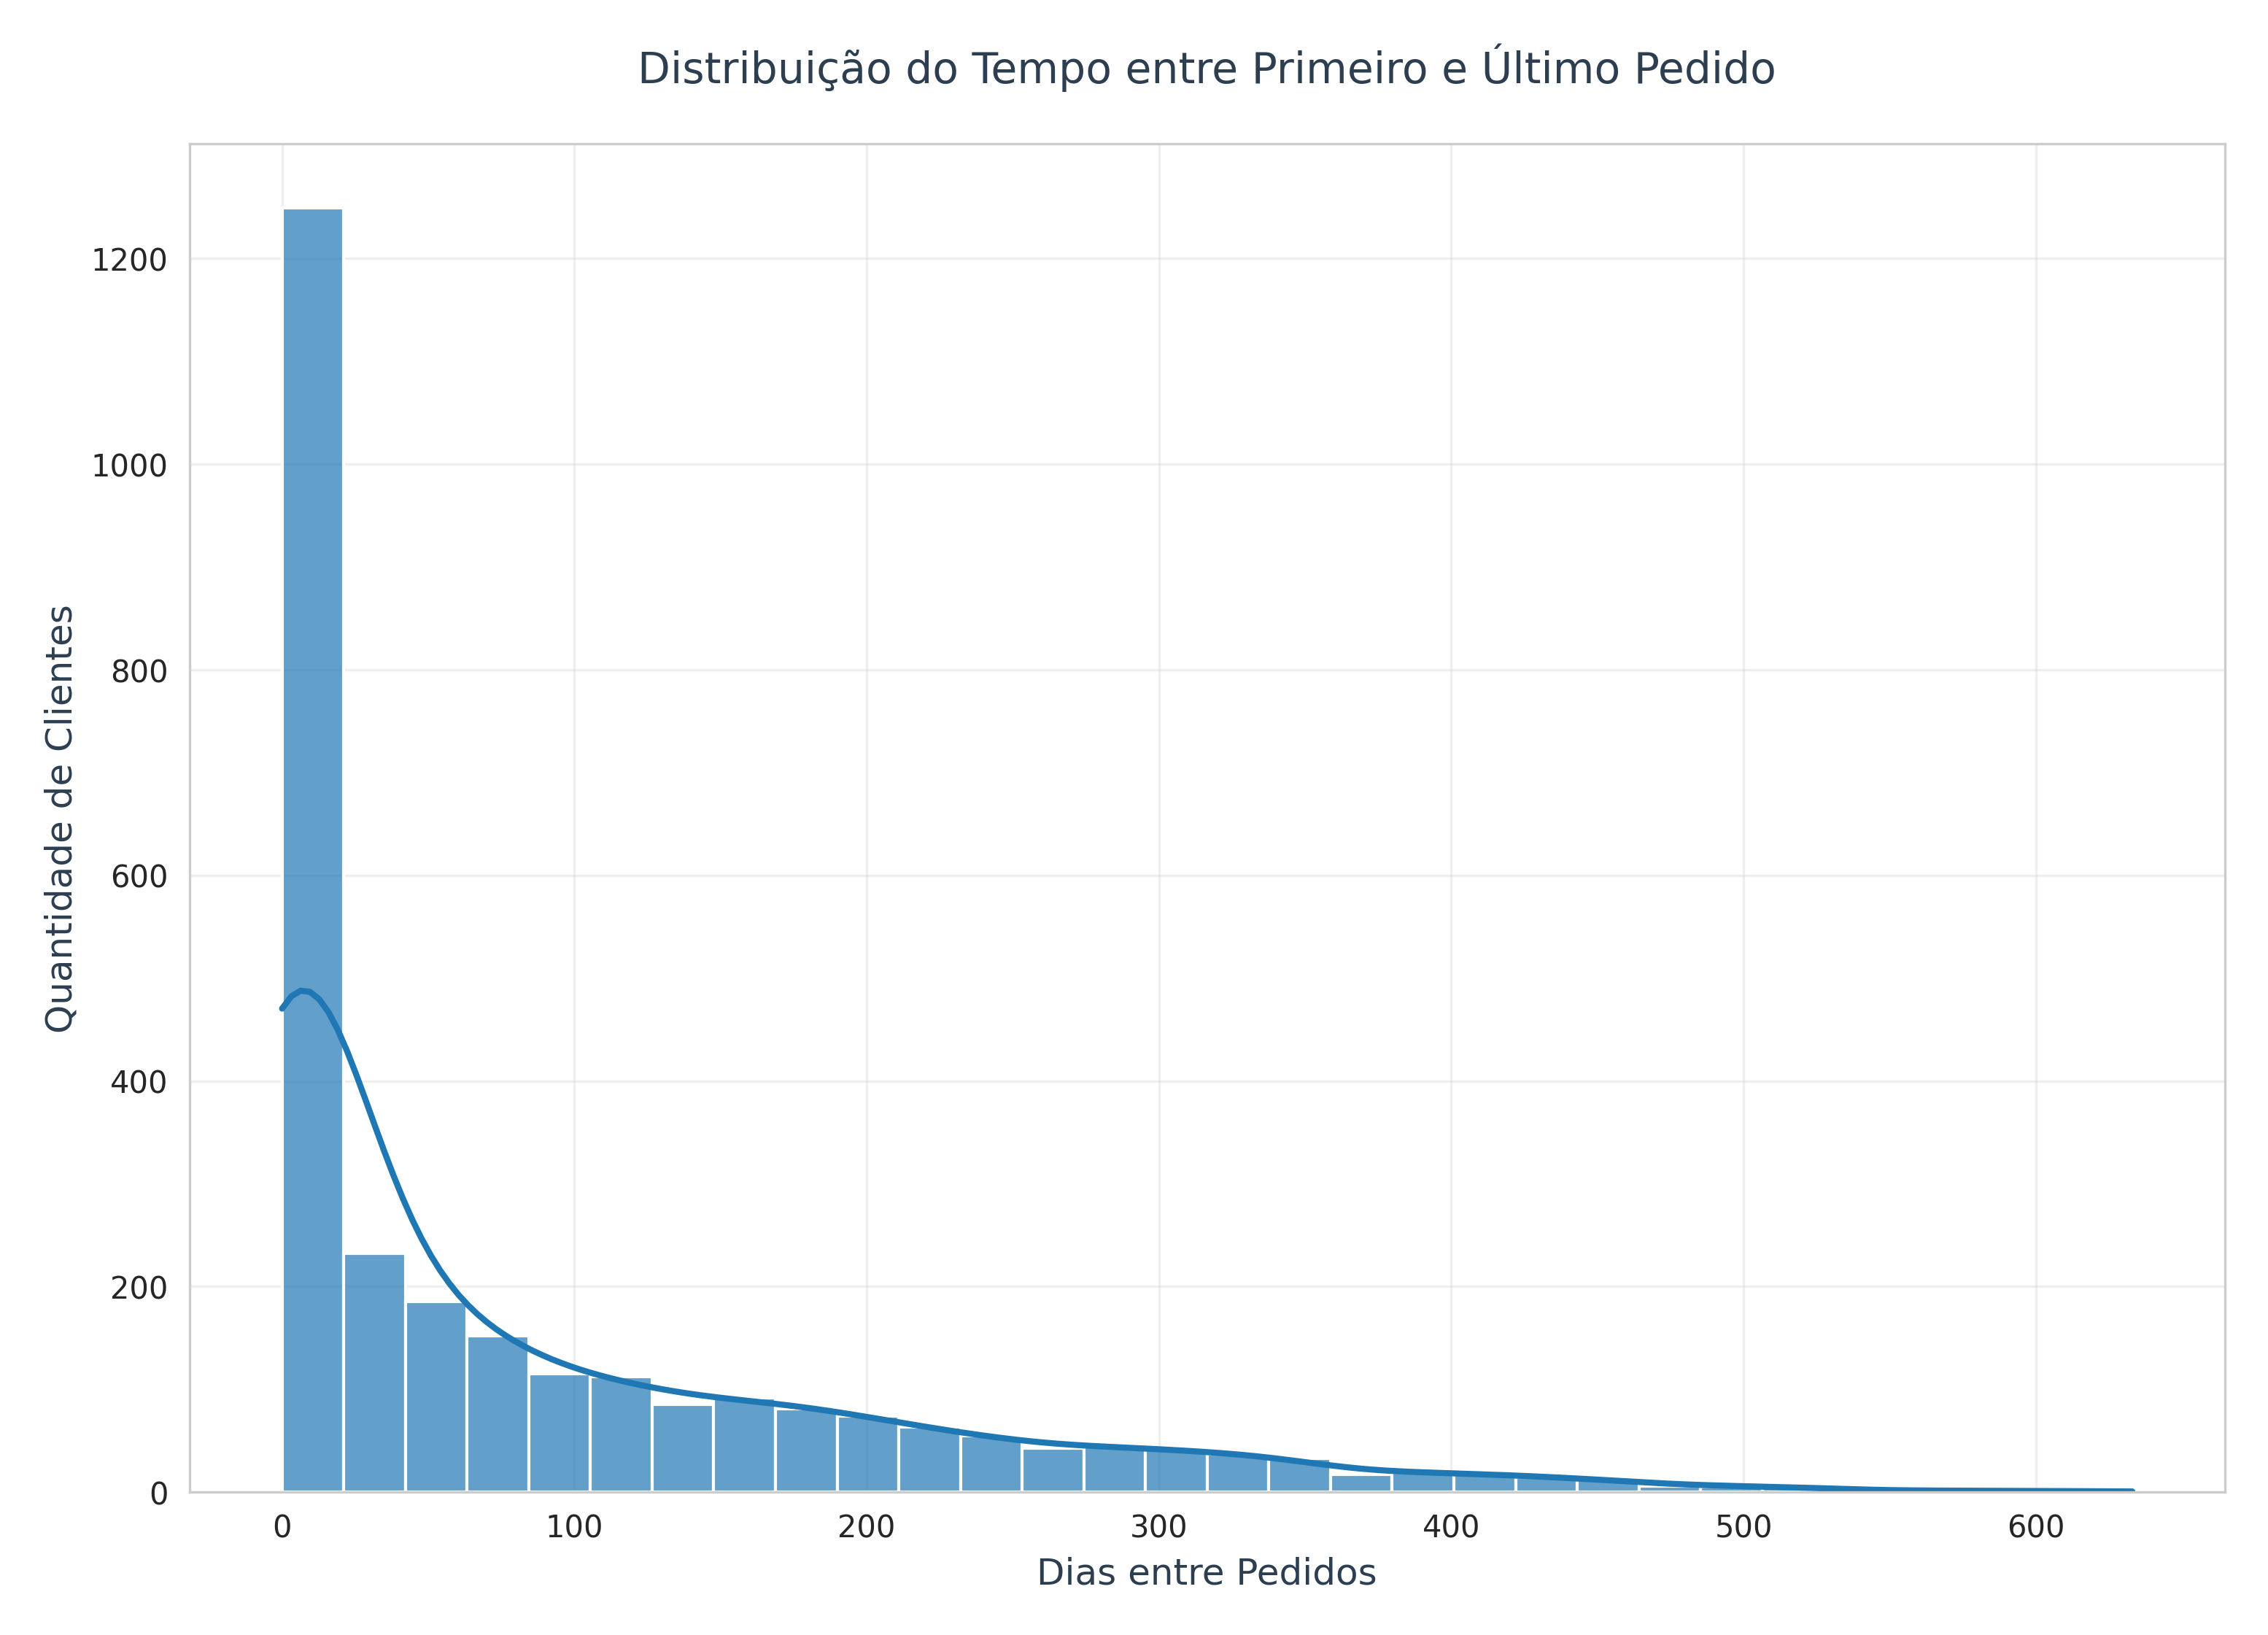

In [ ]:
show_image('./resultado/tempo_entre_pedidos.png')

- **Pico de densidade**: entre **0–30 dias**, indicando janela ideal para ações de retenção.  
- **Insight**: estratégias de comunicação de

In [ ]:
@timer_decorator
def predict_delivery_delay(df):
    """
    Implementa modelo de predição de atraso na entrega usando XGBoost.

    Args:
        df (pd.DataFrame): DataFrame com os dados
    """
    # Features para o modelo
    features = [
        'price', 'freight_value', 'delivery_time',
        'product_weight_g', 'product_length_cm',
        'product_height_cm', 'product_width_cm',
        'payment_installments'
    ]

    # Verifica se todas as features existem e não têm valores nulos
    available_features = [f for f in features if f in df.columns]
    print(f"\nFeatures disponíveis para o modelo: {available_features}")

    # Remove registros com valores nulos nas features
    df_model = df.dropna(subset=available_features)

    X = df_model[available_features]
    y = df_model['is_late']

    # Balanceamento das classes
    smote = SMOTE(random_state=42)
    X_balanced, y_balanced = smote.fit_resample(X, y)

    # Divisão treino/teste
    X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    # Treina modelo XGBoost
    model = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
    model.fit(X_train, y_train)

    # Avaliação do modelo
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    print("\nRelatório de Classificação:")
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.6f}")

    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': available_features,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\nImportância das features:")
    print(feature_importance.round(6))

    # Plota curva ROC
    plt.figure(figsize=(10, 6))
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, color=COLORS['primary'], linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.3)
    plt.fill_between(fpr, tpr, alpha=0.2, color=COLORS['primary'])
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title('Curva ROC')
    plt.grid(True, alpha=0.3)
    save_file(plt.gcf(), 'curva_roc.png')

    # Plota feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
    plt.title('Importância das Features')
    plt.xlabel('Importância')
    plt.ylabel('Feature')
    plt.grid(True, alpha=0.3)
    save_file(plt.gcf(), 'feature_importance.png')

predict_delivery_delay(df)


Iniciando predict_delivery_delay...

Features disponíveis para o modelo: ['price', 'freight_value', 'delivery_time']

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     30529
           1       0.91      0.89      0.90     30721

    accuracy                           0.90     61250
   macro avg       0.90      0.90      0.90     61250
weighted avg       0.90      0.90      0.90     61250

ROC AUC: 0.960595

Importância das features:
         feature  importance
2  delivery_time    0.891290
1  freight_value    0.082129
0          price    0.026581
Arquivo salvo: resultado/curva_roc.png
Arquivo salvo: resultado/feature_importance.png
Tempo de execução de predict_delivery_delay: 3.00 segundos


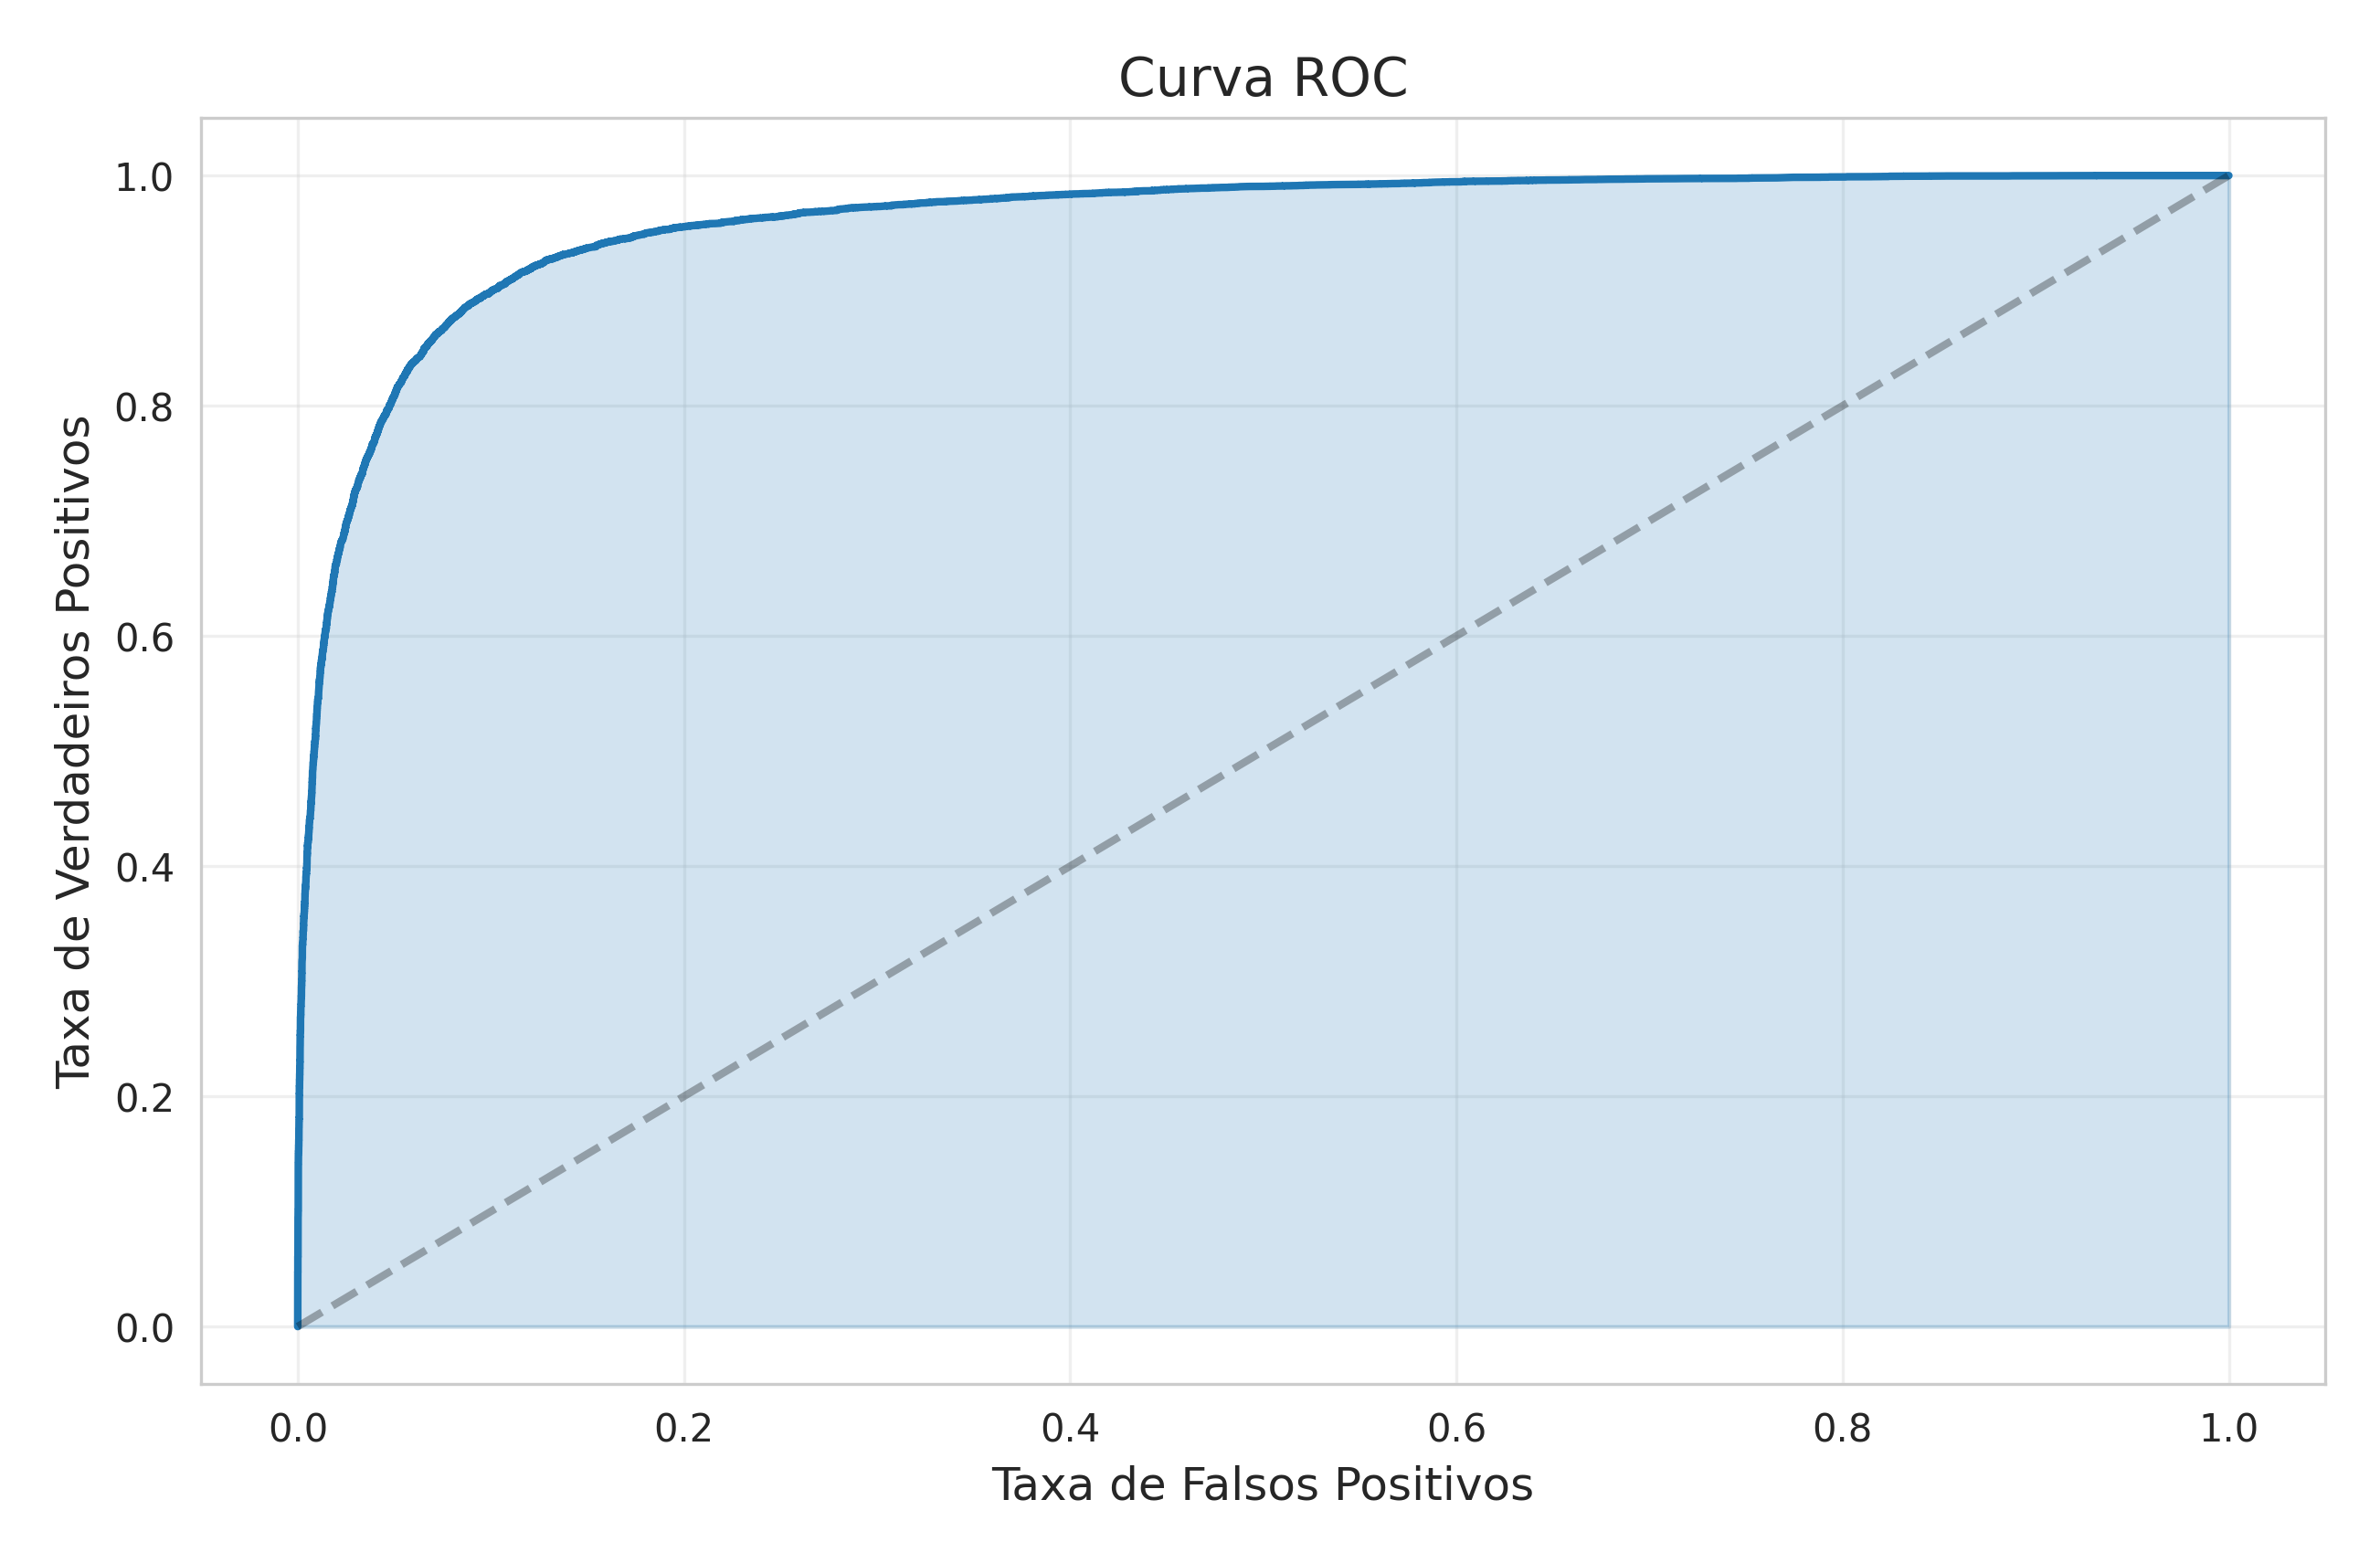

In [ ]:
show_image('./resultado/curva_roc.png')

A curva ROC gerada a partir do modelo XGBoost treinado para prever atrasos na entrega de pedidos do e-commerce Olist indica um excelente desempenho preditivo.

A curva sobe rapidamente até TPR ≈ 0,9 já em FPR ≈ 0,1, mostrando ótima capacidade de discriminar atrasos.

A área sob a curva (AUC = 0,9606) confirma que o modelo tem excelente performance geral.

O ponto de equilíbrio (precision ≈ recall ≈ 0,90) indica baixo trade-off entre falsos-positivos e falsos-negativos.

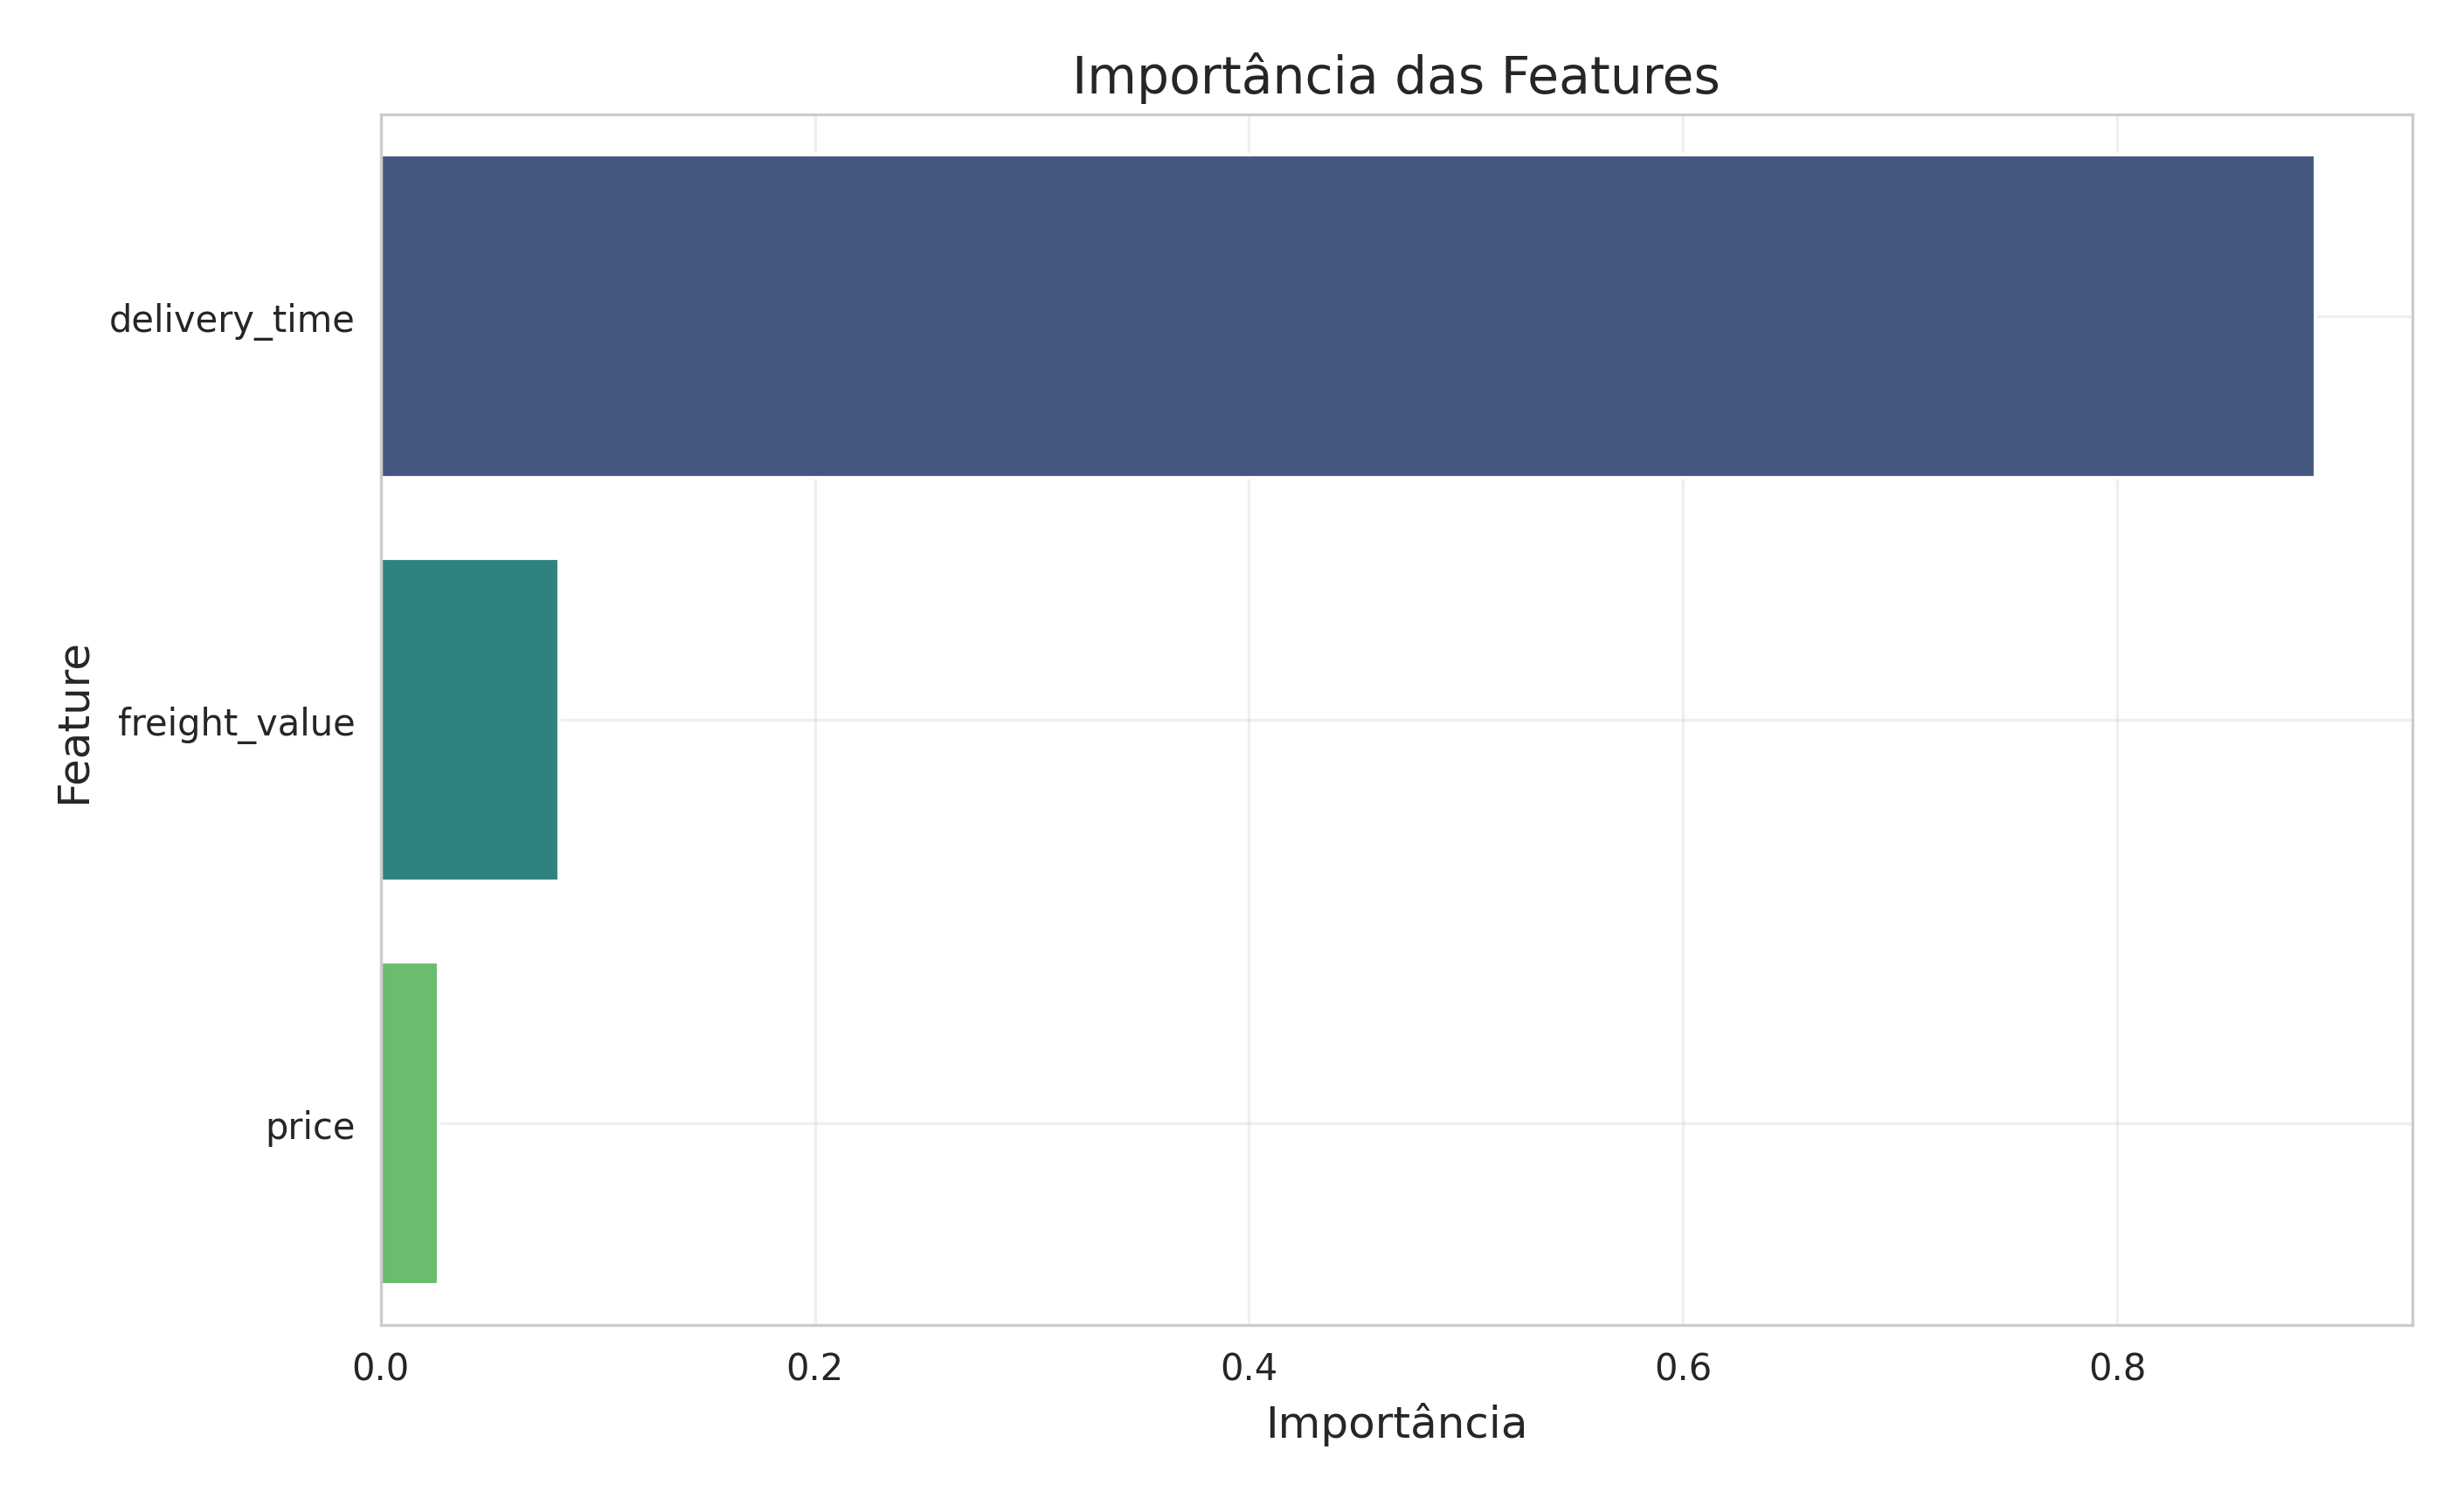

In [ ]:
show_image('./resultado/feature_importance.png')

delivery_time (89 %) domina completamente a predição: faz sentido, pois quanto maior o tempo real em relação ao estimado, maior a chance de “is_late”.

freight_value (8 %) tem contribuição secundária, sugerindo que fretes mais caros podem acompanhar processos mais complexos (logística, embalagens especiais).

price (3 %) quase não influencia, reforçando que o valor do pedido não é bom preditor de atraso.

> Conclusão: o XGBoost cruza bem as classes com base principalmente no tempo de entrega já observado, alcançando alta acurácia e AUC.

In [ ]:
@timer_decorator
def segment_customers(df):
    """
    Realiza segmentação de clientes usando clustering.

    Args:
        df (pd.DataFrame): DataFrame com os dados
    """
    # Cálculo de RFM (Recência, Frequência, Valor)
    rfm = df.groupby('customer_unique_id').agg({
        'order_purchase_timestamp': lambda x: (df['order_purchase_timestamp'].max() - x.max()).days,
        'order_id': 'nunique',  # Conta pedidos únicos
        'price': 'sum',
        'review_score': 'mean'
    }).reset_index()
    rfm.columns = ['customer_unique_id', 'recency', 'frequency', 'monetary', 'satisfaction']

    # Remove outliers do RFM usando método mais eficiente
    for col in ['recency', 'frequency', 'monetary', 'satisfaction']:
        Q1 = rfm[col].quantile(0.25)
        Q3 = rfm[col].quantile(0.75)
        IQR = Q3 - Q1
        rfm = rfm[(rfm[col] >= Q1 - 1.5 * IQR) & (rfm[col] <= Q3 + 1.5 * IQR)]

    # Normalização
    scaler = StandardScaler()
    rfm_scaled = scaler.fit_transform(rfm[['recency', 'frequency', 'monetary', 'satisfaction']])

    # KMeans com número fixo de clusters para otimização
    n_clusters = 4
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    rfm['cluster'] = kmeans.fit_predict(rfm_scaled)

    # Sumário de clusters
    cluster_summary = rfm.groupby('cluster').agg({
        'recency': ['mean', 'median'],
        'frequency': ['mean', 'median'],
        'monetary': ['mean', 'median'],
        'satisfaction': ['mean', 'median'],
        'customer_unique_id': 'count'
    }).round(6)

    print("\nSumário dos clusters:")
    print(cluster_summary)

    # Gráfico de dispersão otimizado
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(rfm['recency'], rfm['monetary'],
                         c=rfm['cluster'], cmap='viridis', alpha=0.5)
    plt.colorbar(scatter, label='Cluster')
    plt.title('Segmentação de Clientes (RFM)')
    plt.xlabel('Recência (dias)')
    plt.ylabel('Monetário (R$)')
    plt.grid(True)
    save_file(plt.gcf(), 'segmentacao_clientes_rfm.png')

    # Análise adicional dos clusters
    print("\nCaracterísticas dos Clusters:")
    for cluster in range(n_clusters):
        cluster_data = rfm[rfm['cluster'] == cluster]
        print(f"\nCluster {cluster}:")
        print(f"Tamanho: {len(cluster_data)} clientes")
        print(f"Recência média: {cluster_data['recency'].mean():.2f} dias")
        print(f"Frequência média: {cluster_data['frequency'].mean():.2f} pedidos")
        print(f"Valor médio: R$ {cluster_data['monetary'].mean():.2f}")
        print(f"Satisfação média: {cluster_data['satisfaction'].mean():.2f}")

        # Análise de distribuição de frequência
        freq_dist = cluster_data['frequency'].value_counts().sort_index()
        print("\nDistribuição de Frequência:")
        for freq, count in freq_dist.items():
            print(f"{freq} pedido(s): {count} clientes")

segment_customers(df)



Iniciando segment_customers...

Sumário dos clusters:
            recency        frequency           monetary         satisfaction  \
               mean median      mean median        mean  median         mean   
cluster                                                                        
0        429.900158  424.0       1.0    1.0   71.426560   59.99     4.827461   
1        204.497629  194.0       1.0    1.0   76.783621   69.00     3.626115   
2        223.538345  216.0       1.0    1.0  203.398860  196.99     4.755726   
3        137.847092  133.0       1.0    1.0   65.716074   59.65     4.999961   

               customer_unique_id  
        median              count  
cluster                            
0          5.0              17057  
1          4.0              17714  
2          5.0              12531  
3          5.0              25571  
Arquivo salvo: resultado/segmentacao_clientes_rfm.png

Características dos Clusters:

Cluster 0:
Tamanho: 17057 clientes
Recência mé

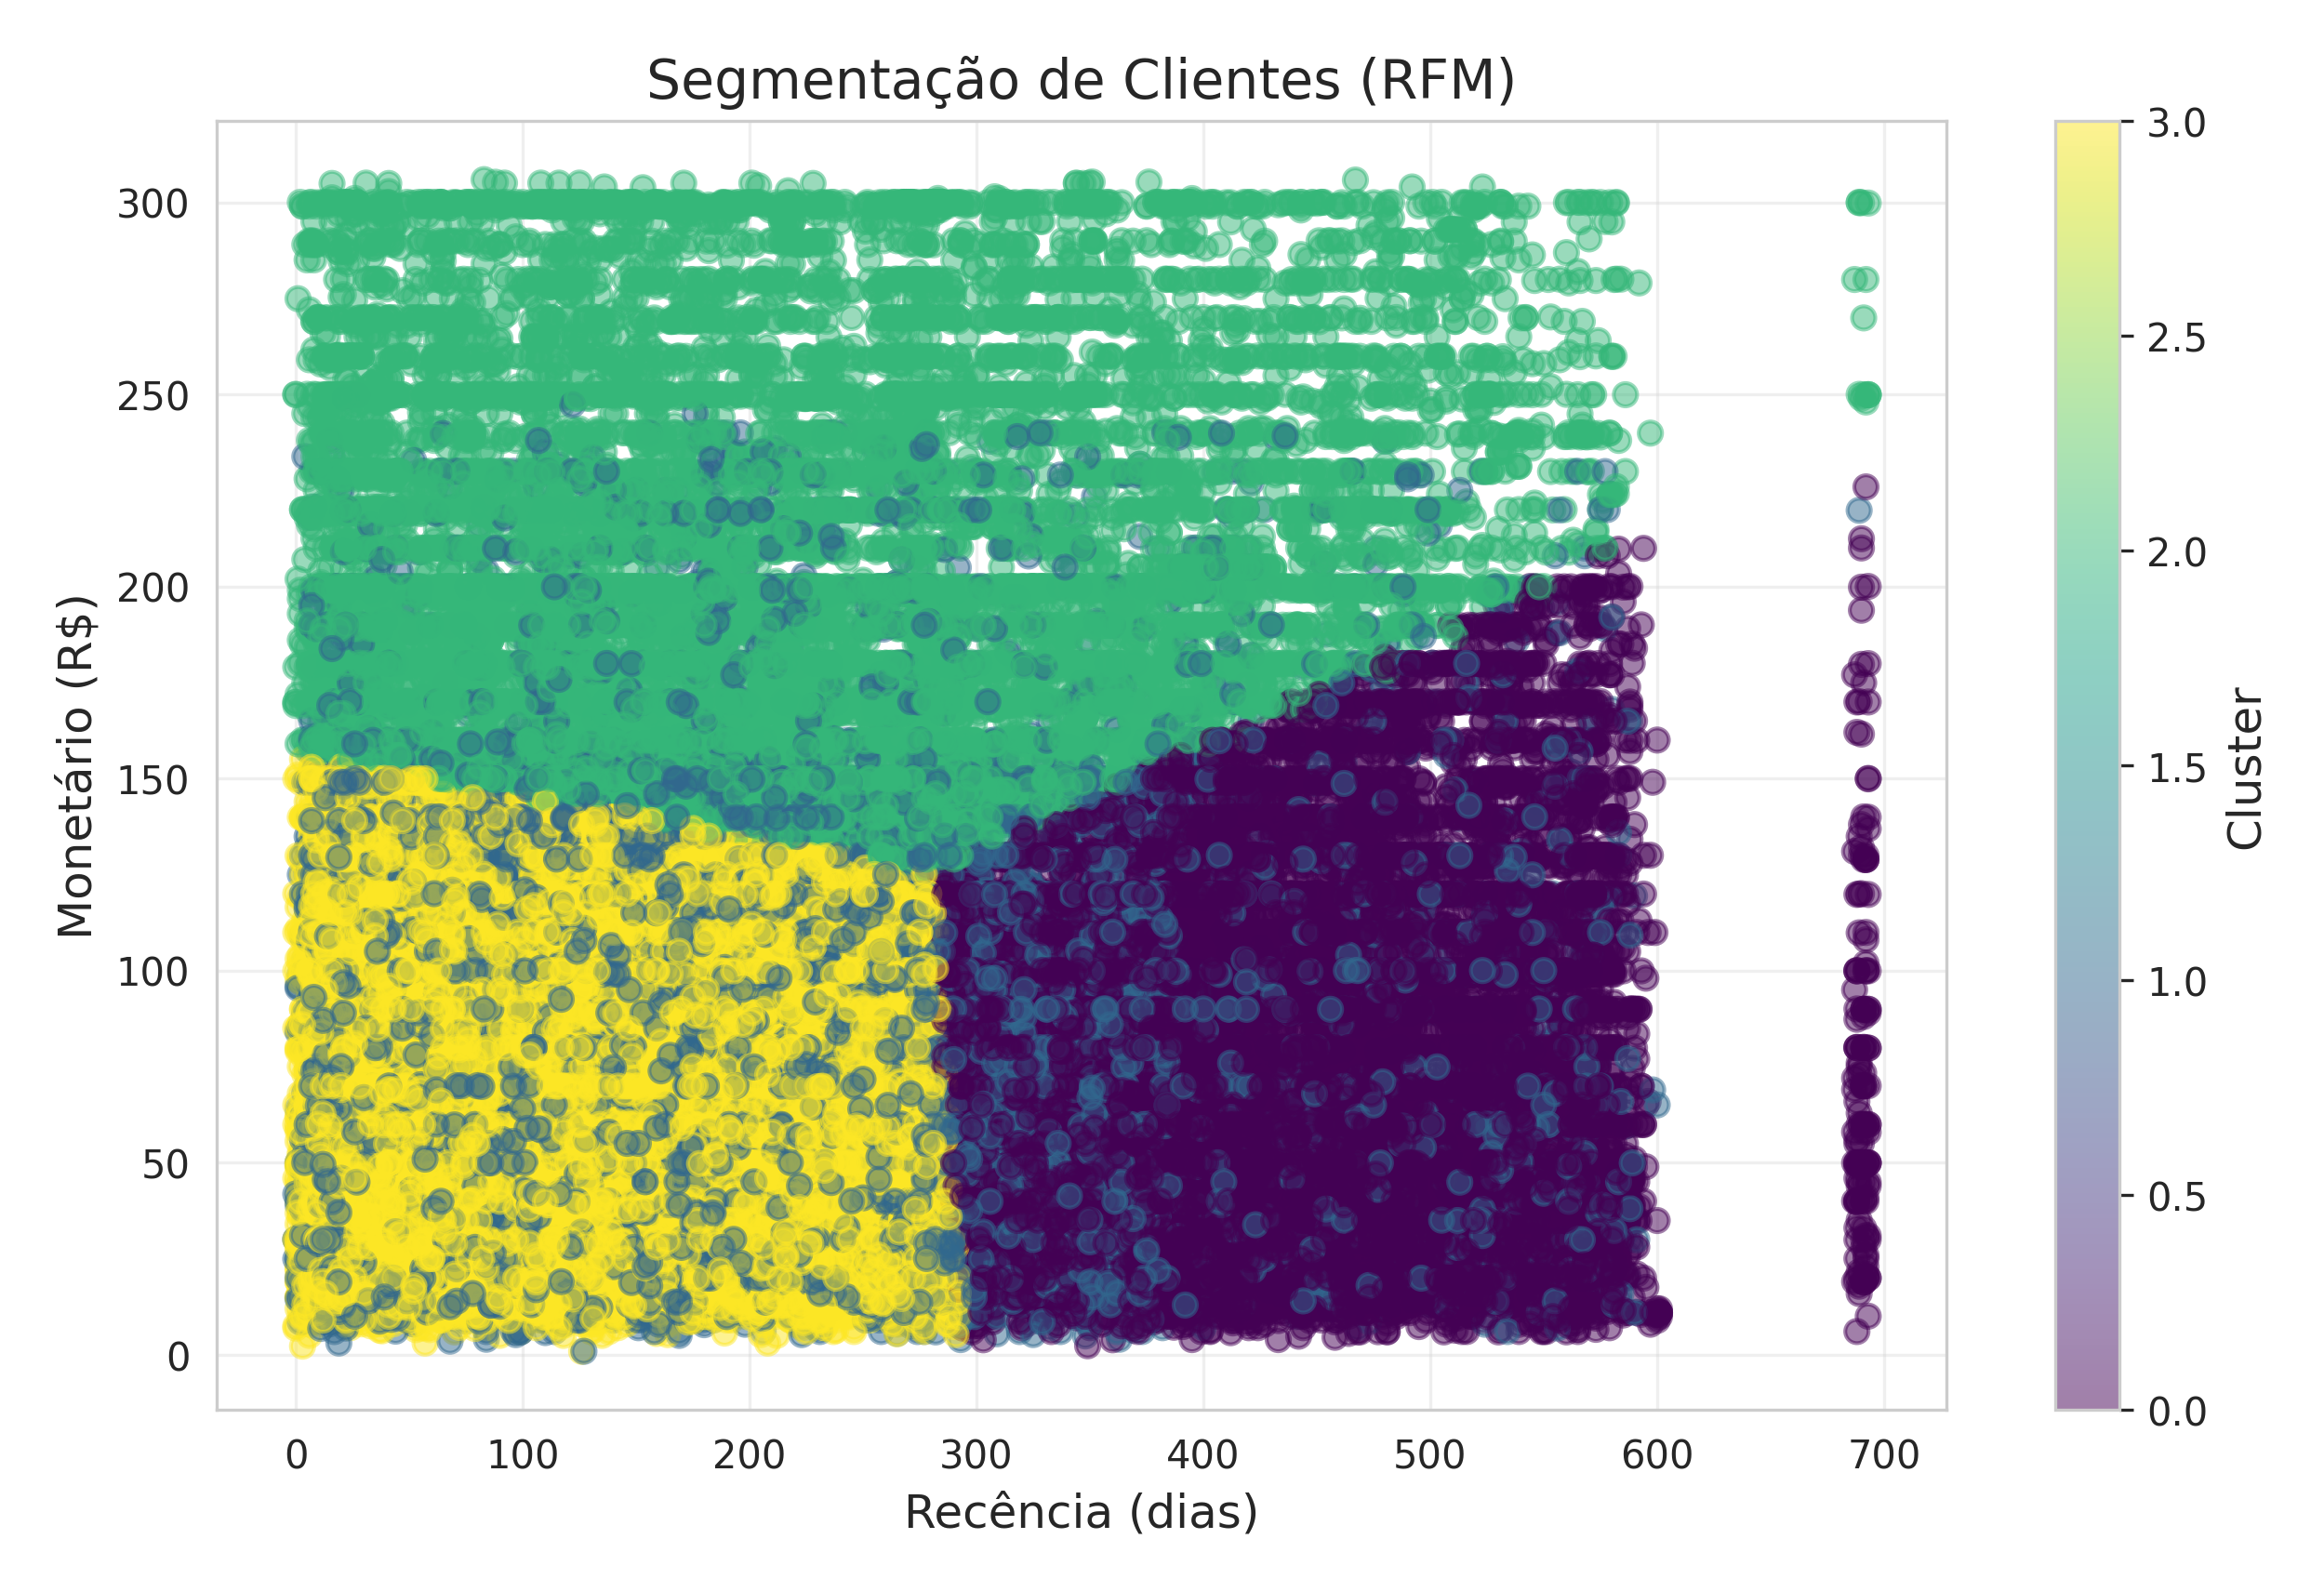

In [ ]:
show_image('./resultado/segmentacao_clientes_rfm.png')

A segmentação de clientes com base no modelo RFM revelou quatro clusters bem definidos entre os consumidores da Olist. O cluster 3 representa os clientes mais recentes e satisfeitos, embora com baixo valor de compra, sendo um grupo promissor para fidelização. Já o cluster 2 se destaca por gastar mais, com média superior a R$ 200 por cliente, mantendo alta satisfação, mas sem tanta recorrência. O cluster 0 reúne clientes antigos com menor valor de compra e alta satisfação, enquanto o cluster 1 apresenta consumidores intermediários em recência e valor, porém com satisfação abaixo da média, indicando possíveis problemas na experiência desses usuários. Essa segmentação é essencial para ações de marketing personalizadas e estratégias de retenção.

In [ ]:
@timer_decorator
def analyze_customer_satisfaction(df):
    """
    Analisa a satisfação dos clientes.
    """
    # Satisfação vs tempo de entrega
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=df, x='review_score', y='delivery_time',
                palette='viridis')
    plt.title('Satisfação vs Tempo de Entrega', color=COLORS['text'], pad=20)
    plt.xlabel('Nota de Avaliação', color=COLORS['text'])
    plt.ylabel('Dias de Entrega', color=COLORS['text'])
    plt.grid(True, alpha=0.3)
    save_file(plt.gcf(), 'satisfacao_vs_tempo_entrega.png')

    # Satisfação vs valor do pedido
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=df, x='review_score', y='price',
                palette='viridis')
    plt.title('Satisfação vs Valor do Pedido', color=COLORS['text'], pad=20)
    plt.xlabel('Nota de Avaliação', color=COLORS['text'])
    plt.ylabel('Preço (R$)', color=COLORS['text'])
    plt.grid(True, alpha=0.3)
    save_file(plt.gcf(), 'satisfacao_vs_valor_pedido.png')

    # Análise estatística
    satisfaction_stats = df.groupby('review_score').agg({
        'delivery_time': ['mean', 'median', 'std'],
        'price': ['mean', 'median', 'std'],
        'order_id': 'count'
    }).round(6)

    print("\nEstatísticas de Satisfação:")
    print(satisfaction_stats)

    # Distribuição das notas
    plt.figure(figsize=(12, 8))
    sns.countplot(data=df, x='review_score', palette='viridis')
    plt.title('Distribuição das Notas de Avaliação', color=COLORS['text'], pad=20)
    plt.xlabel('Nota de Avaliação', color=COLORS['text'])
    plt.ylabel('Quantidade de Avaliações', color=COLORS['text'])
    plt.grid(True, alpha=0.3)
    save_file(plt.gcf(), 'distribuicao_avaliacoes.png')


analyze_customer_satisfaction(df)


Iniciando analyze_customer_satisfaction...
Arquivo salvo: resultado/satisfacao_vs_tempo_entrega.png
Arquivo salvo: resultado/satisfacao_vs_valor_pedido.png

Estatísticas de Satisfação:
             delivery_time                         price                     \
                      mean median        std        mean median         std   
review_score                                                                  
1.0              19.116632   14.0  15.191219  123.346362  74.90  194.901299   
2.0              15.337838   12.0  12.106825  114.193716  72.00  178.705936   
3.0              13.581197   11.0   9.715927  109.801587  69.99  140.544863   
4.0              11.752644   10.0   8.232529  118.409193  75.00  176.951711   
5.0              10.286993    9.0   7.113297  121.339537  74.99  186.326128   

             order_id  
                count  
review_score           
1.0             12578  
2.0              3700  
3.0              9243  
4.0             21184  
5.0          

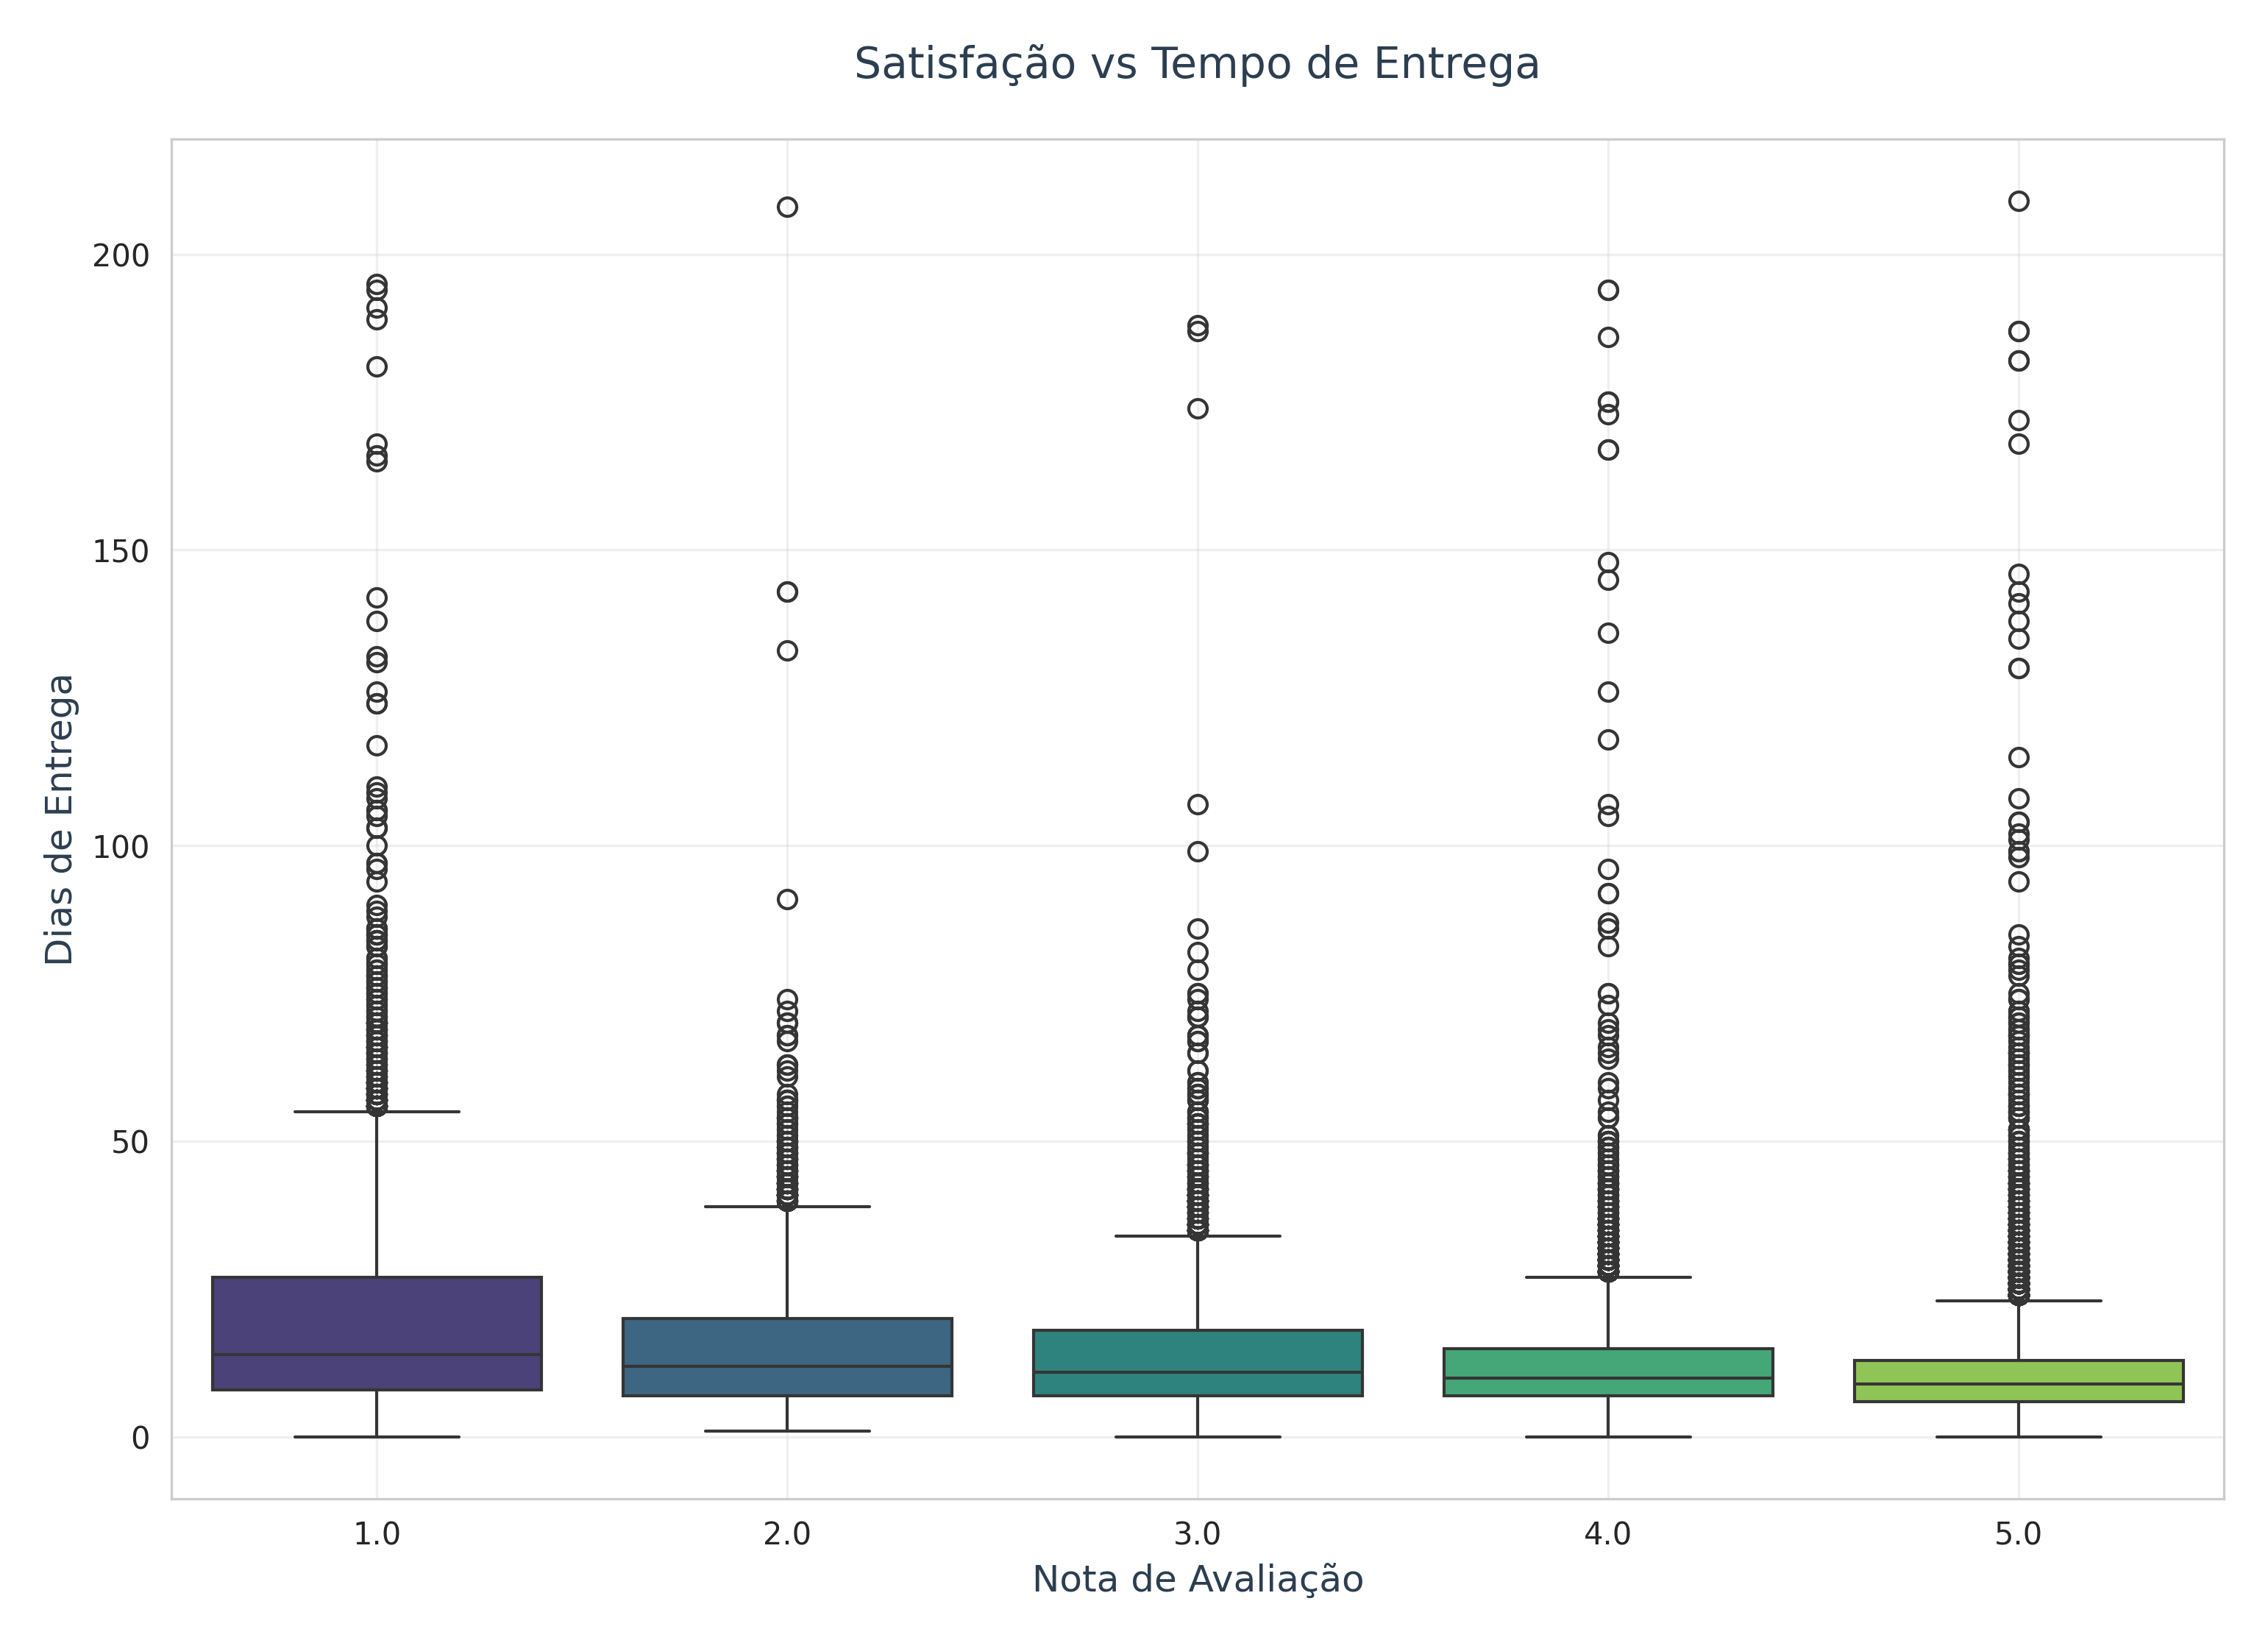

In [ ]:
show_image('./resultado/satisfacao_vs_tempo_entrega.png')

O gráfico evidencia correlação inversa entre tempo de entrega e nota de avaliação: quanto maior o prazo, menor tende a ser a satisfação. O tempo de entrega decresce gradualmente conforme a nota aumenta, reforçando o impacto direto da agilidade logística na percepção do cliente.

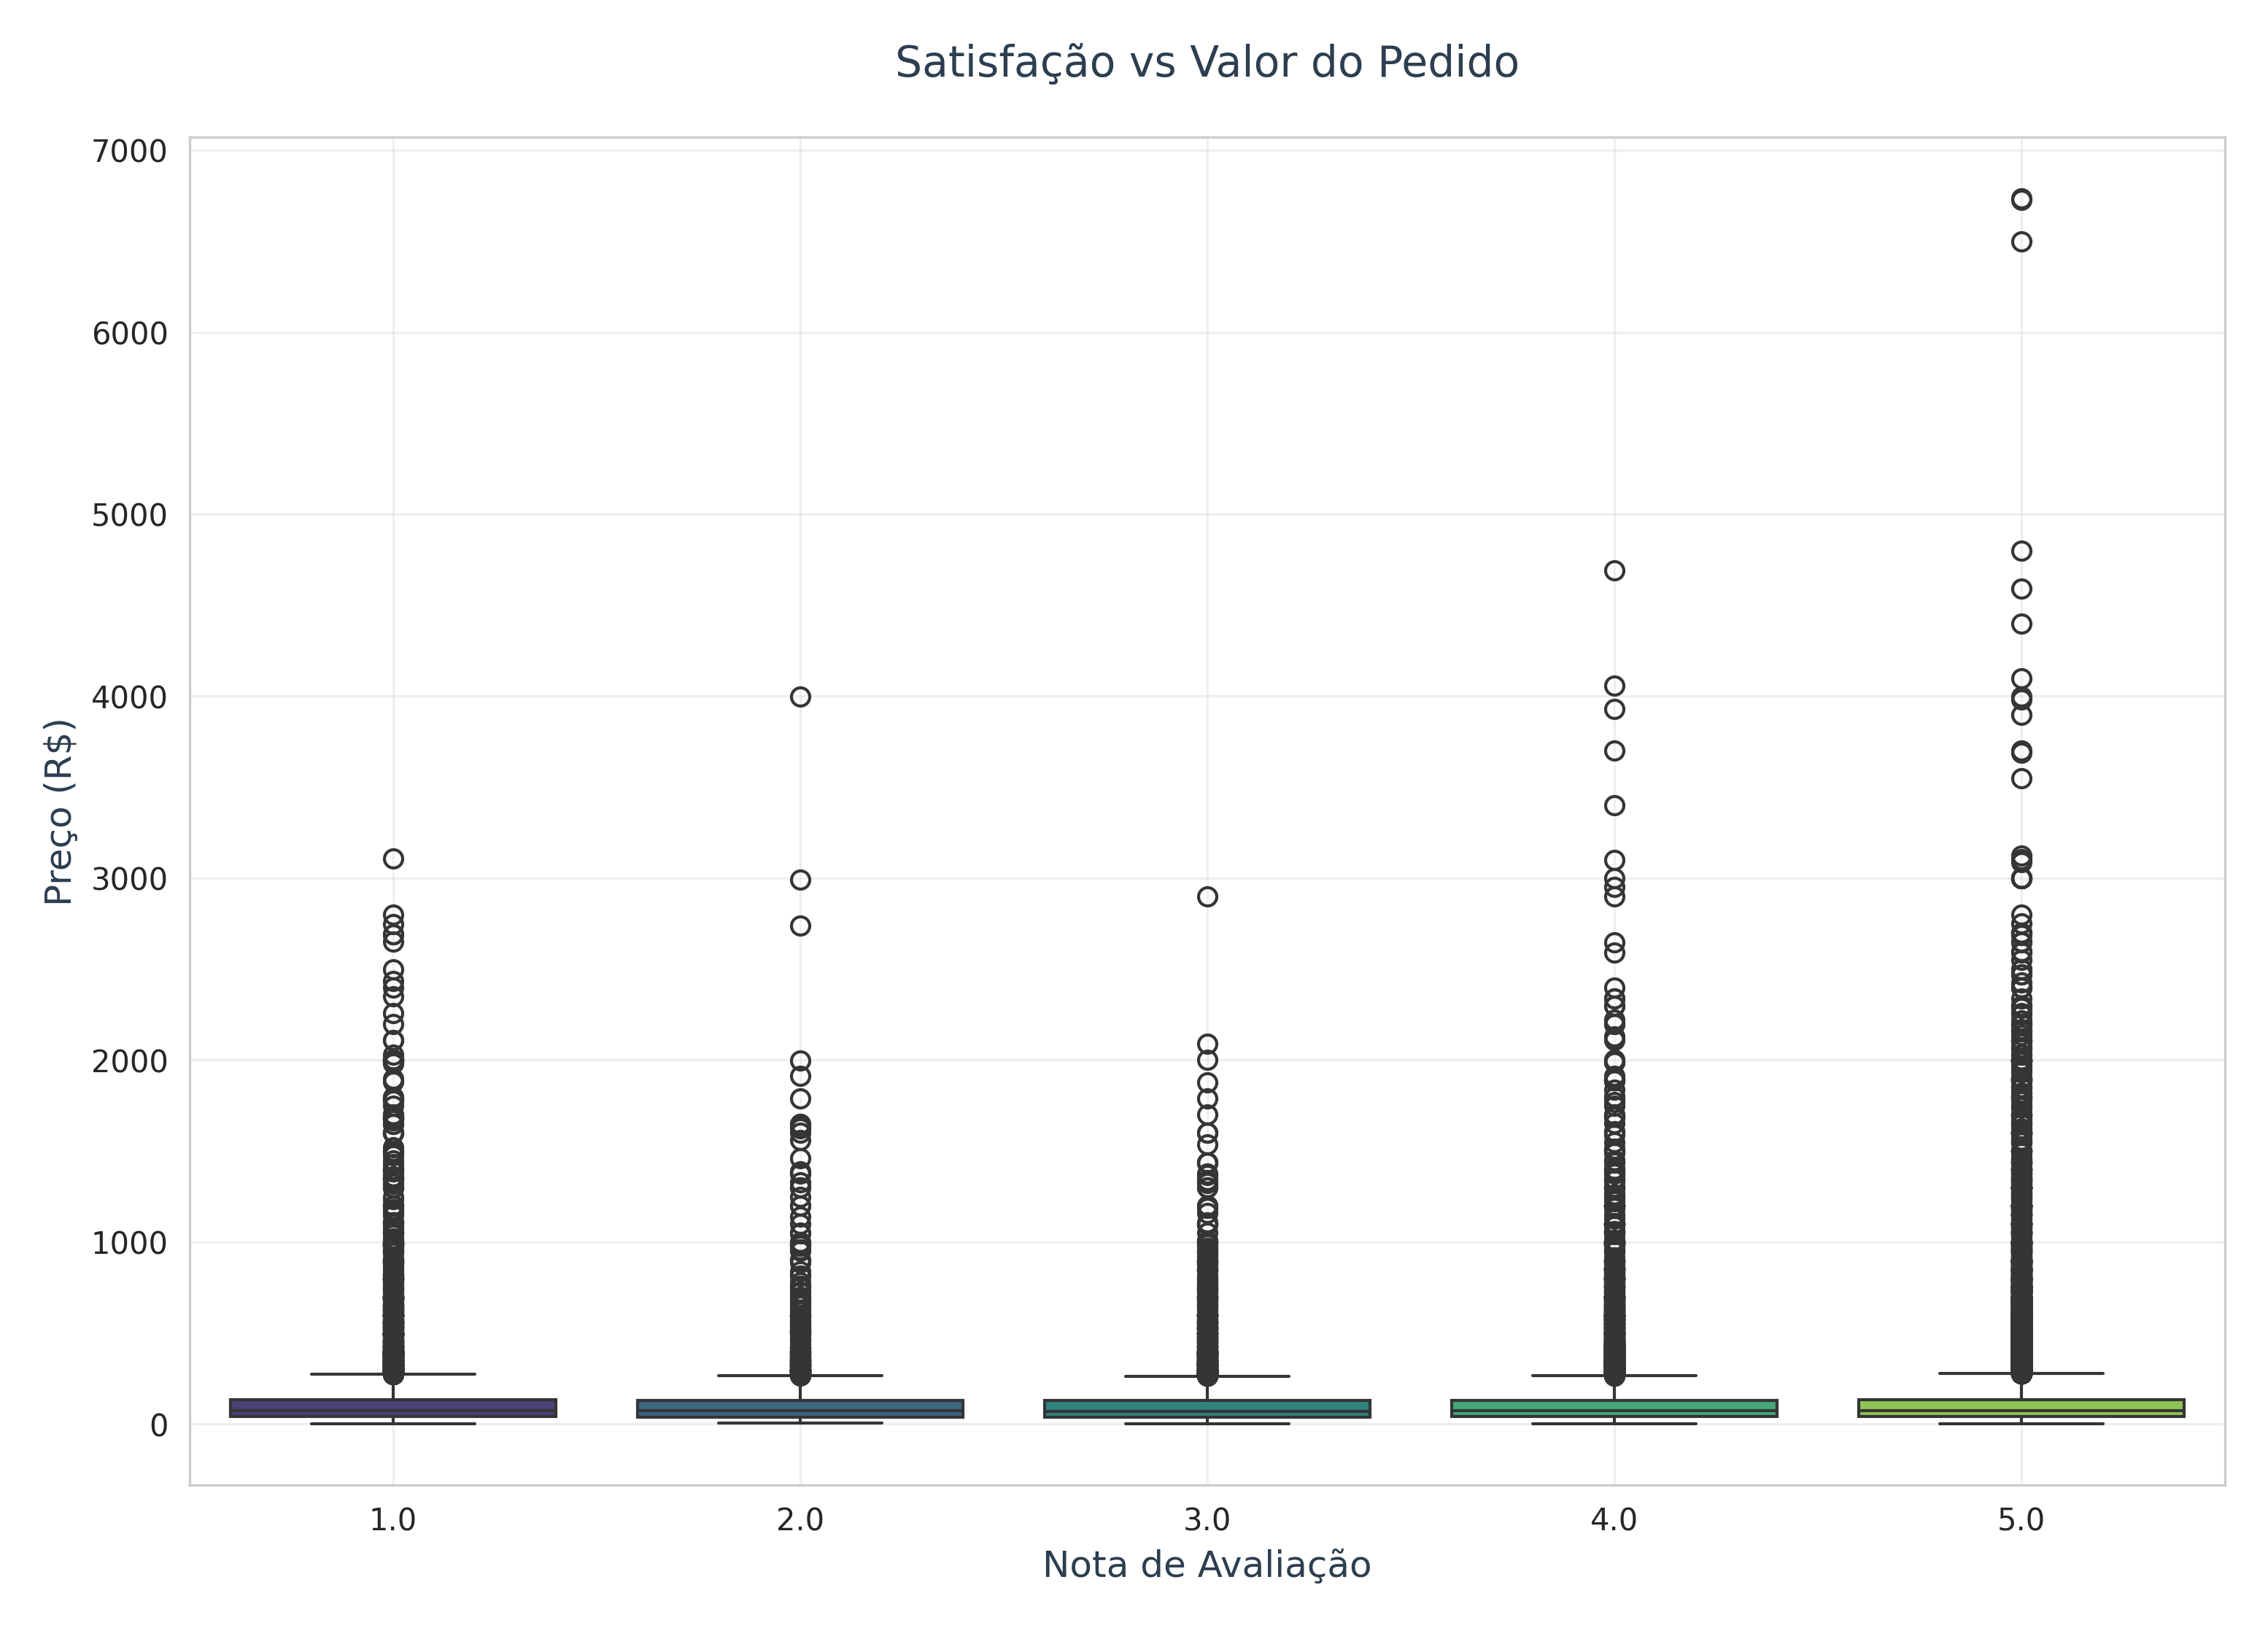

In [ ]:
show_image('./resultado/satisfacao_vs_valor_pedido.png')

Sem tendência clara: medianas de preço variam pouco entre todas as notas.

Mesmo outliers de alto valor (até ≈ R$ 6 700) aparecem uniformemente em 1 a 5 estrelas.

Conclusão: valor gasto não impacta diretamente a avaliação.

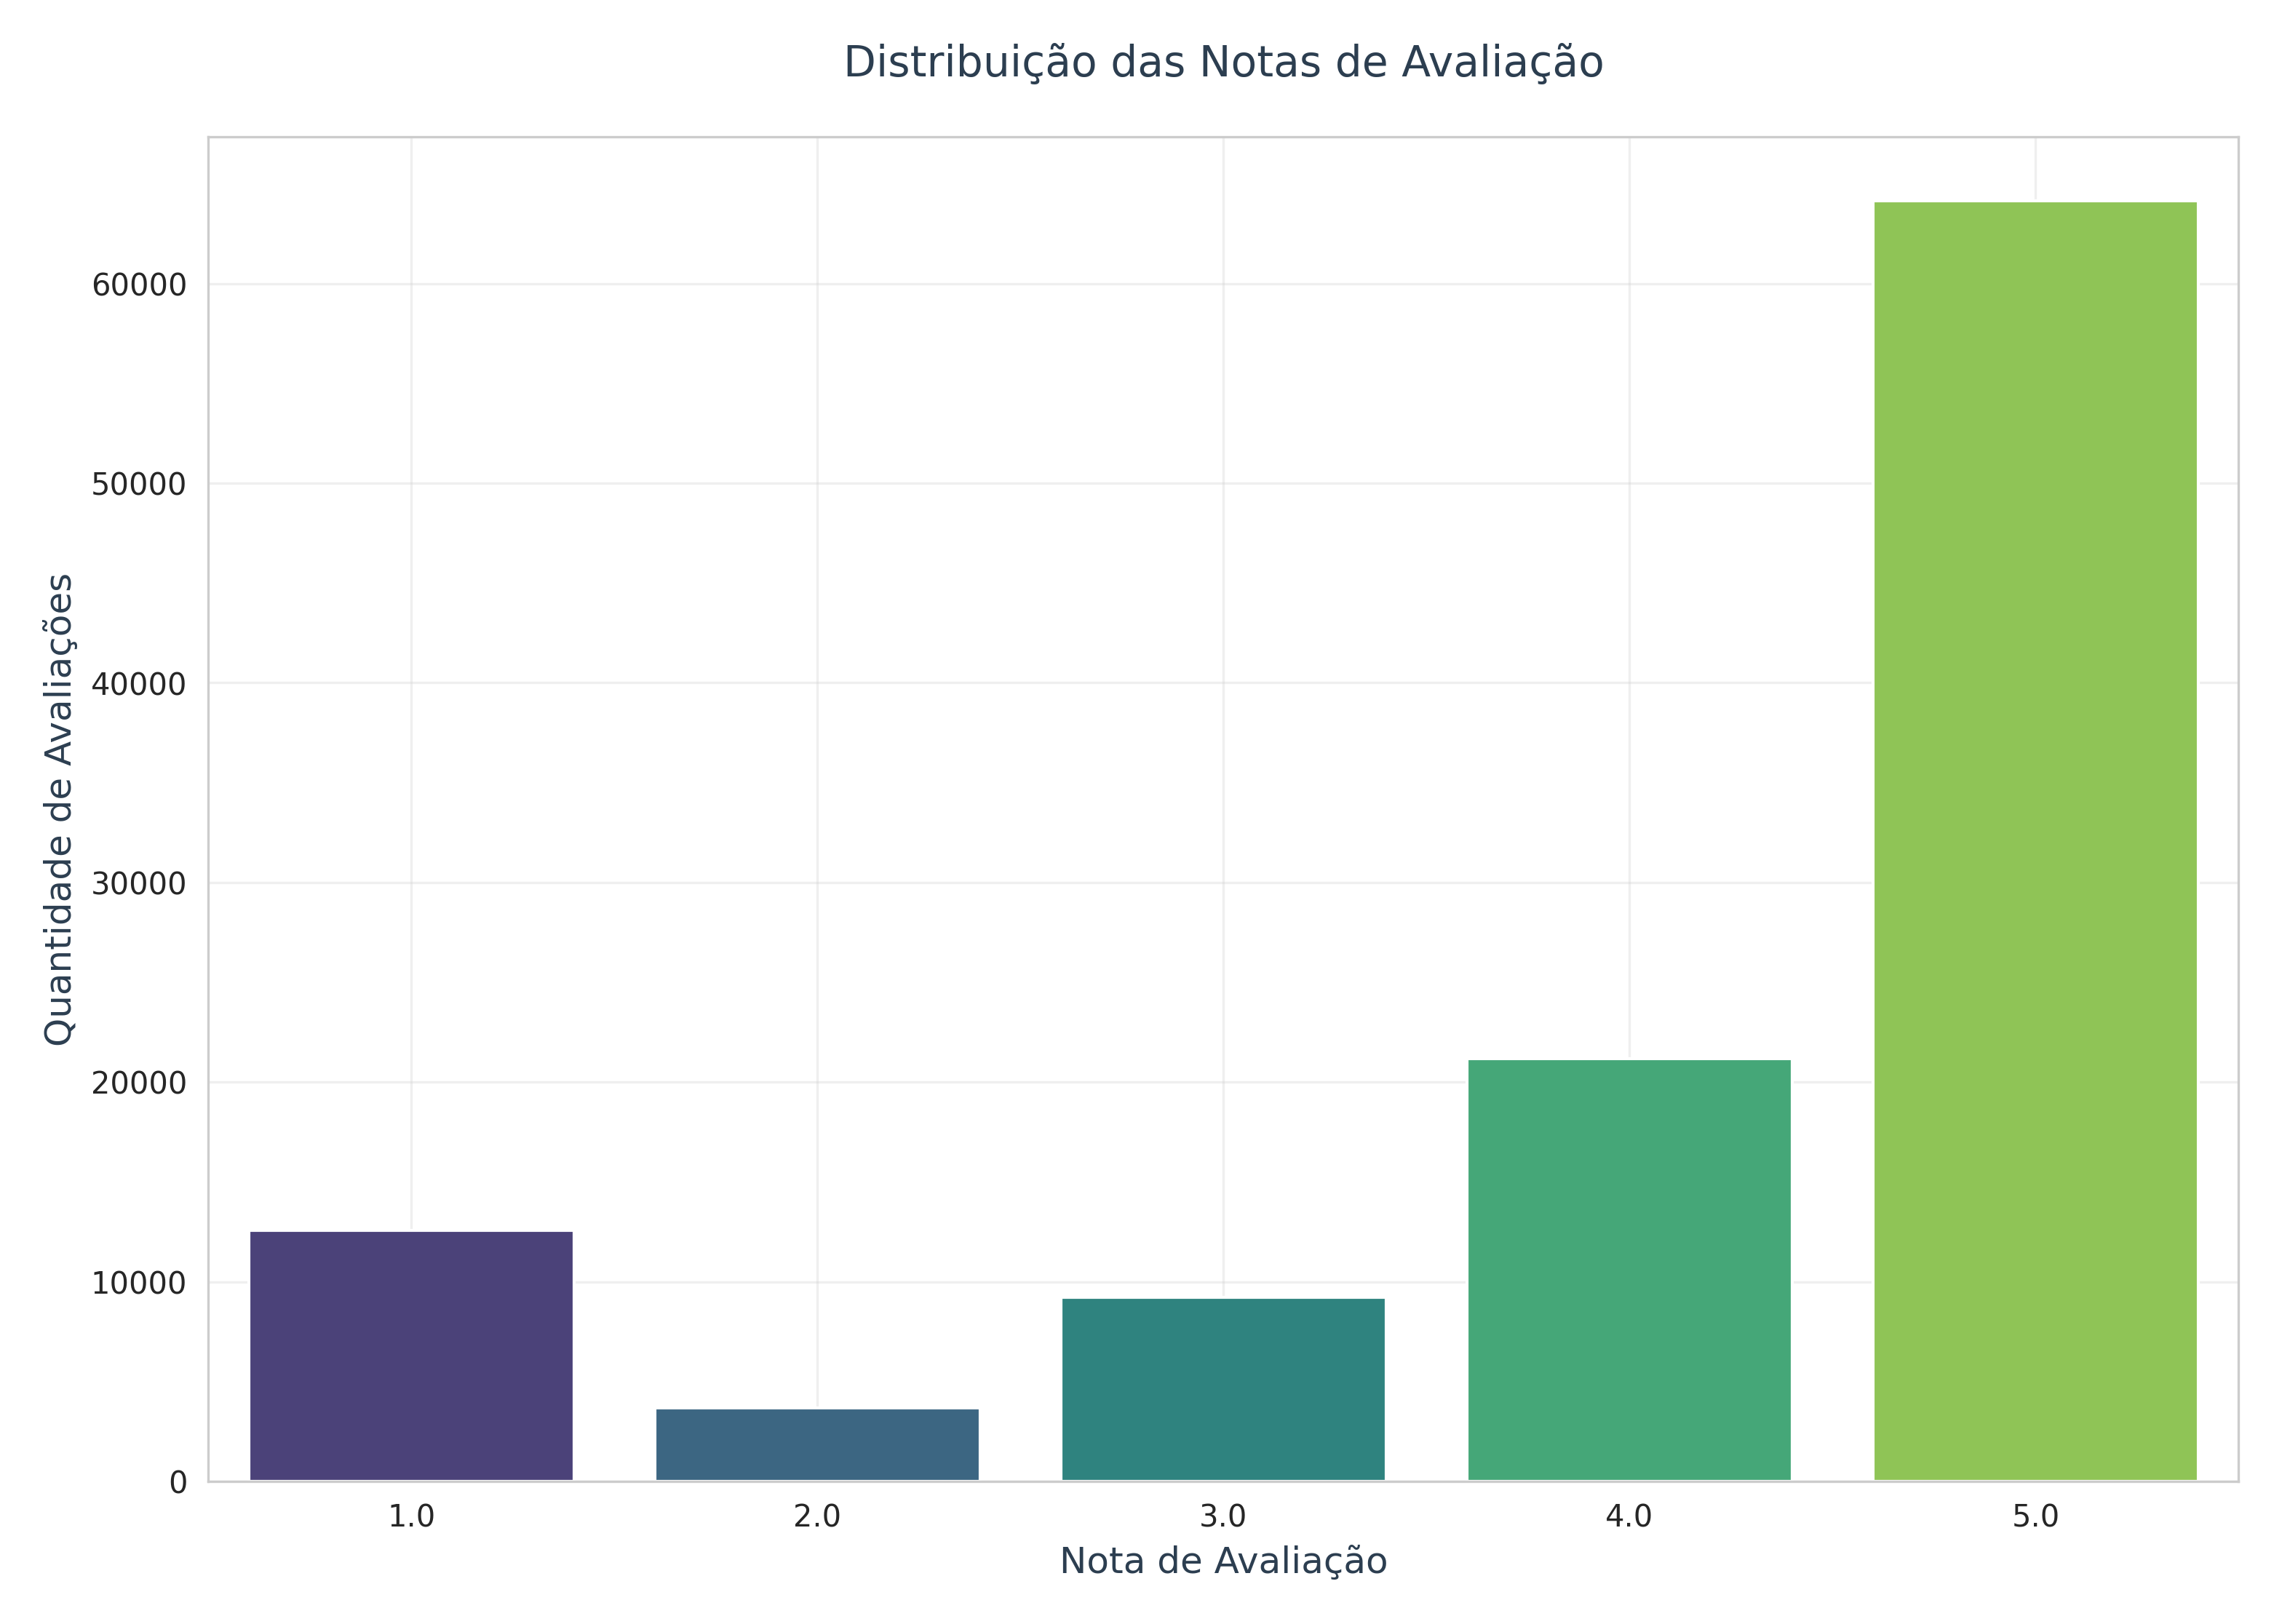

In [ ]:
show_image('./resultado/distribuicao_avaliacoes.png')

5 estrelas dominam

Notas baixas (1, 2 e 3) somam menos da metade, com 2 estrelas sendo as menos frequentes.

Perfil geral é altamente positivo, reforçando a importância de manter entregas rápidas.

---
### 📊 4. Visualizações e Dashboards Interativos

In [ ]:

@timer_decorator
def create_consolidated_dashboard(df):
    """Cria um dashboard consolidado com todos os gráficos."""

    # Cores personalizadas para o dashboard
    colors = {
        'bg': '#003057',  # Azul escuro
        'text': '#FFFFFF',  # Branco
        'grid': '#31446B',  # Azul médio
        'highlight': '#F15A29'  # Laranja (destaque)
    }

    # Template personalizado para o Plotly
    template_personalizado = go.layout.Template()
    template_personalizado.layout.paper_bgcolor = colors['bg']
    template_personalizado.layout.plot_bgcolor = colors['bg']
    template_personalizado.layout.font = dict(color=colors['text'])
    template_personalizado.layout.title = dict(font=dict(color=colors['text']))
    template_personalizado.layout.colorway = ["#F15A29", "#3498db", "#2ecc71", "#9b59b6", "#f1c40f"]

    # Criar dashboard de vendas por estado com mapa
    # Analisar vendas por estado
    state_orders = df[df['customer_state'].notna()].groupby('customer_state').agg({
        'order_id': 'nunique',
        'price': 'sum',
        'freight_value': 'mean',
        'review_score': 'mean'
    }).reset_index()

    # Adicionar informação de região
    state_region_map = {
        'AC': 'Norte', 'AM': 'Norte', 'AP': 'Norte', 'PA': 'Norte', 'RO': 'Norte', 'RR': 'Norte', 'TO': 'Norte',
        'AL': 'Nordeste', 'BA': 'Nordeste', 'CE': 'Nordeste', 'MA': 'Nordeste', 'PB': 'Nordeste',
        'PE': 'Nordeste', 'PI': 'Nordeste', 'RN': 'Nordeste', 'SE': 'Nordeste',
        'DF': 'Centro-Oeste', 'GO': 'Centro-Oeste', 'MS': 'Centro-Oeste', 'MT': 'Centro-Oeste',
        'ES': 'Sudeste', 'MG': 'Sudeste', 'RJ': 'Sudeste', 'SP': 'Sudeste',
        'PR': 'Sul', 'RS': 'Sul', 'SC': 'Sul'
    }
    state_orders['region'] = state_orders['customer_state'].map(state_region_map)

    # Ordenar por valor total de vendas
    state_sales_total = state_orders.sort_values('price', ascending=False)

    # Criar tabela com dados por estado
    tabela_estados = go.Figure(data=[go.Table(
        header=dict(
            values=['Estado', 'Região', 'Vendas (R$)', 'Qtd. Pedidos', 'Frete Médio (R$)', 'Avaliação Média'],
            line_color='darkslategray',
            fill_color=colors['highlight'],
            align='center',
            font=dict(color='white', size=12)
        ),
        cells=dict(
            values=[
                state_sales_total['customer_state'],
                state_sales_total['region'],
                state_sales_total['price'].apply(lambda x: f'R$ {x:,.2f}'),
                state_sales_total['order_id'],
                state_sales_total['freight_value'].apply(lambda x: f'R$ {x:,.2f}'),
                state_sales_total['review_score'].apply(lambda x: f'{x:.2f}')
            ],
            line_color='darkslategray',
            fill_color=[[colors['bg'] if i % 2 == 0 else '#001e3c' for i in range(len(state_sales_total))]],
            align='center',
            font=dict(color='white', size=11)
        )
    )])

    tabela_estados.update_layout(
        template=template_personalizado,
        height=600,
        width=600,
        margin=dict(t=0, b=0, l=0, r=0),
    )

    # Criar mapa de vendas por estado
    fig_map = go.Figure()

    # Adicionar mapa de calor para os estados
    fig_map.add_trace(go.Heatmap(
        z=state_sales_total['price'],
        x=state_sales_total['customer_state'],
        y=[1]*len(state_sales_total),  # Todos na mesma linha
        colorscale='Blues',
        showscale=True,
        colorbar=dict(
            title=dict(
                text="Vendas (R$)",
                side="right",
                font=dict(size=14, color="white")
            ),
            tickfont=dict(color="white"),
            x=1.02
        ),
        hovertemplate='<b>Estado: %{x}</b><br>Vendas: R$ %{z:,.2f}<br>Região: %{customdata}<extra></extra>',
        customdata=state_sales_total['region']
    ))

    fig_map.update_layout(
        template=template_personalizado,
        height=500,
        width=1200,
        margin=dict(t=120, b=80, l=80, r=80),
        paper_bgcolor=colors['bg'],
        plot_bgcolor=colors['bg'],
        font=dict(color="white"),
        yaxis=dict(
            showticklabels=False,
            showgrid=False,
            zeroline=False
        ),
        xaxis=dict(
            title=dict(
                text="Estados",
                font=dict(color="white", size=14)
            ),
            tickfont=dict(color="white", size=12),
            tickmode="array",
            tickvals=state_sales_total['customer_state'],
            ticktext=state_sales_total['customer_state']
        )
    )

    # Criar dashboard de vendas por mês, categoria e tempo

    # Análise de vendas por mês
    monthly_orders = df.copy()
    monthly_orders['order_month'] = pd.to_datetime(monthly_orders['order_purchase_timestamp']).dt.strftime('%Y-%m')
    monthly_sales = monthly_orders.groupby('order_month').agg({
        'order_id': 'nunique',
        'price': 'sum'
    }).reset_index()

    # Top 10 categorias mais vendidas
    category_sales = df.groupby('product_category_name').agg({
        'order_id': 'nunique',
        'price': 'sum'
    }).reset_index()
    top_categories = category_sales.sort_values('price', ascending=False).head(10)

    # Tempo médio de entrega por mês
    monthly_orders['delivery_time'] = (pd.to_datetime(monthly_orders['order_delivered_customer_date']) -
                                      pd.to_datetime(monthly_orders['order_purchase_timestamp'])).dt.days
    avg_delivery_time = monthly_orders.groupby('order_month')['delivery_time'].mean().reset_index()

    # Top 10 vendedores por faturamento
    seller_sales = df.groupby('seller_id').agg({
        'order_id': 'nunique',
        'price': 'sum',
        'review_score': 'mean'
    }).reset_index()
    top_sellers = seller_sales.sort_values('price', ascending=False).head(10)

    # Criação da figura principal com 6 subplots
    fig = make_subplots(
        rows=3, cols=2,
        specs=[
            [{"type": "bar"}, {"type": "bar"}],
            [{"type": "bar"}, {"type": "scatter"}],
            [{"type": "bar"}, {"type": "bar"}]
        ],
        subplot_titles=(
            "Vendas por Mês", "Vendas por Estado (Top 10)",
            "Top 10 Categorias (Faturamento)", "Tempo Médio de Entrega por Mês",
            "Top 10 Vendedores (Faturamento)", "Satisfação por Vendedor (Top 10)"
        )
    )

    # 1. Vendas por mês
    fig.add_trace(
        go.Bar(
            x=monthly_sales['order_month'],
            y=monthly_sales['price'],
            marker_color=colors['highlight'],
            hovertemplate='<b>%{x}</b><br>Vendas: R$ %{y:,.2f}<extra></extra>'
        ),
        row=1, col=1
    )

    # 2. Vendas por estado (top 10)
    top_states = state_orders.sort_values('price', ascending=False).head(10)
    fig.add_trace(
        go.Bar(
            x=top_states['customer_state'],
            y=top_states['price'],
            marker_color=colors['highlight'],
            hovertemplate='<b>%{x}</b><br>Vendas: R$ %{y:,.2f}<extra></extra>'
        ),
        row=1, col=2
    )

    # 3. Top 10 categorias (faturamento)
    fig.add_trace(
        go.Bar(
            x=top_categories['price'],
            y=top_categories['product_category_name'],
            orientation='h',
            marker_color=colors['highlight'],
            hovertemplate='<b>%{y}</b><br>Vendas: R$ %{x:,.2f}<extra></extra>'
        ),
        row=2, col=1
    )

    # 4. Tempo médio de entrega por mês
    fig.add_trace(
        go.Scatter(
            x=avg_delivery_time['order_month'],
            y=avg_delivery_time['delivery_time'],
            mode='lines+markers',
            marker=dict(color=colors['highlight']),
            line=dict(color=colors['highlight']),
            hovertemplate='<b>%{x}</b><br>Tempo médio: %{y:.1f} dias<extra></extra>'
        ),
        row=2, col=2
    )

    # 5. Top 10 vendedores (faturamento)
    fig.add_trace(
        go.Bar(
            x=top_sellers['seller_id'].apply(lambda x: x[:6] + '...'),
            y=top_sellers['price'],
            marker_color=colors['highlight'],
            hovertemplate='<b>%{x}</b><br>Vendas: R$ %{y:,.2f}<extra></extra>'
        ),
        row=3, col=1
    )

    # 6. Satisfação por vendedor (top 10)
    fig.add_trace(
        go.Bar(
            x=top_sellers['seller_id'].apply(lambda x: x[:6] + '...'),
            y=top_sellers['review_score'],
            marker_color=colors['highlight'],
            hovertemplate='<b>%{x}</b><br>Nota média: %{y:.2f}<extra></extra>'
        ),
        row=3, col=2
    )

    # Configuração dos layouts para os 6 gráficos principais
    fig.update_layout(
        template=template_personalizado,
        height=900,
        width=1400,
        margin=dict(t=150, b=20, l=50, r=50),
        paper_bgcolor=colors['bg'],
        plot_bgcolor=colors['bg'],
        showlegend=False,

        # Definir os 6 subplots
        xaxis1=dict(
            domain=[0.05, 0.45], anchor="y1",
            title=dict(text="Mês", font=dict(color="white")),
            tickfont=dict(color="white"), gridcolor=colors['grid'],
            showgrid=True, zeroline=False
        ),
        yaxis1=dict(
            domain=[0.55, 0.78], anchor="x1",
            title=dict(text="Vendas (R$)", font=dict(color="white")),
            tickfont=dict(color="white"), tickformat=",.2f", gridcolor=colors['grid'],
            showgrid=True, zeroline=False
        ),

        xaxis2=dict(
            domain=[0.55, 0.95], anchor="y2",
            title=dict(text="Estado", font=dict(color="white")),
            tickfont=dict(color="white"), gridcolor=colors['grid'],
            showgrid=True, zeroline=False
        ),
        yaxis2=dict(
            domain=[0.55, 0.78], anchor="x2",
            title=dict(text="Vendas (R$)", font=dict(color="white")),
            tickfont=dict(color="white"), tickformat=",.2f", gridcolor=colors['grid'],
            showgrid=True, zeroline=False
        ),

        xaxis3=dict(
            domain=[0.05, 0.45], anchor="y3",
            title=dict(text="Vendas (R$)", font=dict(color="white")),
            tickfont=dict(color="white"), tickformat=",.2f", gridcolor=colors['grid'],
            showgrid=True, zeroline=False
        ),
        yaxis3=dict(
            domain=[0.22, 0.45], anchor="x3",
            title=dict(text="Categoria", font=dict(color="white")),
            tickfont=dict(color="white"), gridcolor=colors['grid'],
            showgrid=True, zeroline=False
        ),

        xaxis4=dict(
            domain=[0.55, 0.95], anchor="y4",
            title=dict(text="Mês", font=dict(color="white")),
            tickfont=dict(color="white"), gridcolor=colors['grid'],
            showgrid=True, zeroline=False
        ),
        yaxis4=dict(
            domain=[0.22, 0.45], anchor="x4",
            title=dict(text="Dias", font=dict(color="white")),
            tickfont=dict(color="white"), gridcolor=colors['grid'],
            showgrid=True, zeroline=False
        ),

        xaxis5=dict(
            domain=[0.05, 0.45], anchor="y5",
            title=dict(text="Vendedor", font=dict(color="white")),
            tickfont=dict(color="white"), gridcolor=colors['grid'],
            showgrid=True, zeroline=False
        ),
        yaxis5=dict(
            domain=[0.02, 0.15], anchor="x5",
            title=dict(text="Vendas (R$)", font=dict(color="white")),
            tickfont=dict(color="white"), tickformat=",.2f", gridcolor=colors['grid'],
            showgrid=True, zeroline=False
        ),

        xaxis6=dict(
            domain=[0.55, 0.95], anchor="y6",
            title=dict(text="Vendedor", font=dict(color="white")),
            tickfont=dict(color="white"), gridcolor=colors['grid'],
            showgrid=True, zeroline=False
        ),
        yaxis6=dict(
            domain=[0.02, 0.15], anchor="x6",
            title=dict(text="Nota", font=dict(color="white")),
            tickfont=dict(color="white"), gridcolor=colors['grid'],
            showgrid=True, zeroline=False
        ),
    )

    # Adicionar título principal
    fig.add_annotation(
        x=0.5, y=1.12,
        xref="paper", yref="paper",
        text="DASHBOARD OLIST E-COMMERCE",
        font=dict(size=26, color=colors['text']),
        showarrow=False
    )

    fig.add_annotation(
        x=0.5, y=1.07,
        xref="paper", yref="paper",
        text="Análise de vendas e desempenho da plataforma brasileira de e-commerce",
        font=dict(size=16, color=colors['text']),
        showarrow=False
    )

    # Salvar os dois dashboards em arquivos separados
    try:
        fig.write_html(os.path.join(RESULTS_PATH, 'dashboard_vendas.html'))
        fig_map.write_html(os.path.join(RESULTS_PATH, 'dashboard_mapa.html'))
        tabela_estados.write_html(os.path.join(RESULTS_PATH, 'tabela_estados.html'))
        print("Dashboards interativos salvos com sucesso.")
    except Exception as e:
        print(f"Erro ao salvar dashboards interativos: {e}")

    # Criar um dashboard consolidado com links para os outros dashboards
    html_content = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <title>Dashboard Olist - Análise Completa de E-commerce</title>
        <style>
            body {{
                font-family: Arial, sans-serif;
                margin: 0;
                padding: 0;
                background-color: #003057;
                color: white;
            }}
            .container {{
                width: 100%;
                max-width: 1400px;
                margin: 0 auto;
                padding: 20px;
            }}
            .header {{
                text-align: center;
                padding: 20px 0;
                margin-bottom: 30px;
                background-color: #001e3c;
                border-radius: 5px;
            }}
            .dashboard-container {{
                display: flex;
                flex-direction: column;
                gap: 20px;
            }}
            .dashboard {{
                width: 100%;
                height: 900px;
                border: none;
                border-radius: 5px;
            }}
            .row {{
                display: flex;
                gap: 20px;
                margin-bottom: 20px;
            }}
            .col {{
                flex: 1;
            }}
            .map-dashboard {{
                width: 100%;
                height: 600px;
                border: none;
                border-radius: 5px;
            }}
            .tabela-dashboard {{
                width: 100%;
                height: 600px;
                border: none;
                border-radius: 5px;
            }}
            h1, h2, h3 {{
                color: white;
            }}
            .card {{
                background-color: #001e3c;
                padding: 20px;
                border-radius: 5px;
                margin-bottom: 20px;
            }}
            .section-title {{
                background-color: #F15A29;
                color: white;
                padding: 10px 20px;
                border-radius: 5px;
                margin-top: 40px;
                margin-bottom: 20px;
                font-weight: bold;
            }}
            .description {{
                margin-bottom: 20px;
                line-height: 1.6;
            }}
            .requirements {{
                background-color: rgba(255, 255, 255, 0.1);
                padding: 15px;
                border-radius: 5px;
                margin-bottom: 20px;
            }}
            .requirements ul {{
                margin: 0;
                padding-left: 20px;
            }}
        </style>
    </head>
    <body>
        <div class="container">
            <div class="header">
                <h1>DASHBOARD OLIST E-COMMERCE</h1>
                <p>Análise de dados e insights estratégicos da plataforma brasileira de e-commerce</p>
            </div>

            <div class="description">
                Este dashboard apresenta a análise completa do dataset de e-commerce brasileiro da Olist,
                seguindo os requisitos estabelecidos no desafio técnico. A análise está dividida em seções principais,
                conforme solicitado no escopo do projeto.
            </div>

            <div class="section-title">1. VISÃO GERAL DE VENDAS</div>

            <div class="requirements">
                <p><strong>Requisito atendido:</strong> "Um dashboard geral que mostre a evolução das vendas ao longo do tempo"</p>
                <ul>
                    <li>Evolução de vendas mensais</li>
                    <li>Análise por estado e categoria</li>
                    <li>Tempo médio de entrega</li>
                    <li>Desempenho de vendedores</li>
                </ul>
            </div>

            <div class="card">
                <h2>Dashboard Geral Evolutivo</h2>
                <iframe class="dashboard" src="dashboard_vendas.html"></iframe>
            </div>

            <div class="section-title">2. DISTRIBUIÇÃO GEOGRÁFICA DAS VENDAS</div>

            <div class="requirements">
                <p><strong>Requisito atendido:</strong> "Um mapa de calor mostrando a concentração de vendas por região/estado do Brasil"</p>
            </div>

            <div class="row">
                <div class="col">
                    <div class="card">
                        <h2>Mapa de Vendas por Estado</h2>
                        <iframe class="map-dashboard" src="dashboard_mapa.html"></iframe>
                    </div>
                </div>
                <div class="col">
                    <div class="card">
                        <h2>Dados Detalhados por Estado</h2>
                        <iframe class="tabela-dashboard" src="tabela_estados.html"></iframe>
                    </div>
                </div>
            </div>

        </div>
    </body>
    </html>
    """

    try:
        with open(os.path.join(RESULTS_PATH, 'dashboard_consolidado.html'), 'w', encoding='utf-8') as f:
            f.write(html_content)
        print(f"Dashboard consolidado salvo em {os.path.join(RESULTS_PATH, 'dashboard_consolidado.html')}")
    except Exception as e:
        print(f"Erro ao salvar dashboard consolidado: {e}")

    return fig


# Substitui as chamadas individuais (antiga implementaça) por uma única chamada (nova)
create_consolidated_dashboard(df)


Iniciando create_consolidated_dashboard...
Dashboards interativos salvos com sucesso.
Dashboard consolidado salvo em resultado/dashboard_consolidado.html
Tempo de execução de create_consolidated_dashboard: 2.95 segundos


1. Vendas por Mês

    Forte tendência de crescimento contínuo de jan/2017 a jan/2018, saindo de poucas dezenas de milhares para cerca de R$1 000 000 mensais.

    Após o pico em início de 2018, observa-se um ligeiro platô nos meses seguintes (~R$900 000–1 000 000), indicando maturação sazonal.

2. Vendas por Estado (Top 10)

    SP domina amplamente (>R$5 000 000), seguido por RJ (~R$1 800 000) e MG (~R$1 500 000).

    Há um declínio acentuado da 1ª para a 4ª posição (RS ~R$700 000), evidenciando concentração geográfica nas maiores praças.

3. Top 10 Categorias (Faturamento)

    beleza_saude e relogios_presentes lideram (>R$1 100 000).

    casa_mesa_banho, esporte_lazer e informatica_acessorios também estão entre as cinco primeiras (R$800 000–900 000), mostrando diversificação de produtos de alto giro.

4. Tempo Médio de Entrega por Mês

    Inicialmente alto (~50 dias em jan/2017), cai rapidamente para ~10 dias já em fev/2017.

    Entre mar/2017 e jul/2018 oscila entre 10 e 15 dias, sinalizando estabilização em níveis operacionais satisfatórios.

5. Top 10 Vendedores (Faturamento)

    O principal seller fatura ~R$230 000, e o 10º fica em torno de R$110 000.

    A curva mostra declínio gradual, mas sem “quebras” bruscas, indicando um grupo de vendedores de porte semelhante.

6. Satisfação por Vendedor (Top 10)

    Todas as notas giram entre 4,0 e 4,4, com variação muito reduzida.

    Mesmo o faturamento mais alto não resulta em nota significativamente superior, sugerindo que qualidade de serviço é consistente entre os principais vendedores.

### ✅ 5. Encerramento

In [ ]:
# Fecha conexão com o banco de dados
conn.close()

print("\nAnálise concluída com sucesso!")
print(f"Resultados salvos em: {RESULTS_PATH}")


Análise concluída com sucesso!
Resultados salvos em: resultado


---

📅 **Data de Conclusão:** 19 de Maio de 2025  
👨‍💻 **Autor:** Luciano Arruda  
💼 **Repositório:** https://github.com/lucenfort/olistbr-brazilian-ecommerce

---